# Trabajo practico Nro 3, haciendo ciencia de datos

## Introduccion

En este informe intentaremos predecir la falta de pago de las tarjetas de credito de clientes de American Express. Para ello usaremos un dataset reducido del provisto por la empresa en [esta competencia](https://www.kaggle.com/competitions/amex-default-prediction/overview/description).

Para este trabajo primero vamos a reducir el [dataset original de entrenamiento](https://www.kaggle.com/competitions/amex-default-prediction/data?select=train_data.csv) en un 95% para poder analizarlo completamente desde Kaggle.

El dataset original cuenta con informacion del perfil de varios clientes dividido en 18 meses, cada registro del dataset es una abstraccion del resumen de la tarjeta de credito de un cliente para una fecha dada. y si el cliente no paga 120 dias despues de haber recibido su ultimo resumen se lo considera un cliente moroso.

Como nuestro dataset reducido solo considera un 5% de los registros del dataset original, no vamos a poder ver en detalle cada resumen de cada cliente, por lo que nuestro analisis se limitara a lo que podemos observar con el dataset reducido.

## Dependencias

Para el analisis de datos y prediccion de morosos, haremos uso de las siguientes bibliotecas

In [1]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.9/989.9 kB 13.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import scipy.stats as st
import sklearn as sk
import visualkeras
import tensorflow as tf
import plotly.graph_objects as go
import xgboost as xgb
import math
import io
import warnings
from math import pi
from tensorflow import keras
from sklearn import svm, preprocessing
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, make_scorer,classification_report, precision_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from plotly.subplots import make_subplots
from keras.models import Model
from keras.layers import Dense, Input, Dropout
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

warnings.filterwarnings('ignore')
tf.random.set_seed(42)

## Anexo - Generacion del dataset reducido

Dejamos el algoritmo utilizado para la generacion del dataset reducido. Se hace uso de la funcion ***sample_without_replacement*** con un *random state* particular de nuestro grupo. Con ello mantenemos la proporcion original del dataset y nos permite realizar un analisis mas cercano al que se haria con el dataset original.

```py
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.utils.random import sample_without_replacement
from pathlib import Path

filename = '.../train_data.csv'

def row_count():
    with open(filename) as f:
        return sum(1 for line in f)

state = (31416 * 9) % 1000 #Grupo 9
count = row_count()
keep_rows = sample_without_replacement(n_population=count, n_samples=int(count * (0.05)), random_state=state)
keep_rows = np.insert(keep_rows, 0,0, axis=0)
data = pd.read_csv(filename, skiprows=lambda x: x not in keep_rows)
filepath = Path('.../reduced_data.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
data.to_csv(filepath)
```

Cargamos el dataset reducido y dropeamos la primer columna, que duplica la informacion del index.

In [3]:
data = pd.read_csv('../input/amexreducido/reduced_data.csv')

data.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
data

customer_ID         S_2  \
0       000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  2017-10-23   
1       000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-11-10   
2       0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...  2017-10-15   
3       0000f99513770170a1aba690daeeb8a96da4a39f11fc27...  2017-03-15   
4       00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...  2017-07-01   
...                                                   ...         ...   
276567  ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...  2018-02-23   
276568  ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...  2017-09-21   
276569  ffff9984b999fccb2b6127635ed0736dda94e544e67e02...  2018-02-06   
276570  ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...  2017-04-24   
276571  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2017-06-19   

             P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
0       0.606677  0.033809  0.025544  0.815019  0.000523  0.172446  0.003708   
1       0.407172  0.001548  0.106145  0.048557  0.001353  0.330037  0.009187   
2       1.005125  0.215301  0.099128  0.082039  0.005363  0.092882  0.001929   
3       0.400025  0.000278  0.954861  0.023890  0.003140       NaN  0.008421   
4       0.311111  0.592908  0.096867  0.040793  0.002294  0.460324  0.009938   
...          ...       ...       ...       ...       ...       ...       ...   
276567  0.812465  0.002464  0.016056  1.003230  0.007137  0.136428  0.000088   
276568  0.864945  0.036332  0.359523  0.041615  0.008703  0.194697  0.007207   
276569  0.786806  0.236684  0.016190  1.001367  0.008386  0.070241  0.000588   
276570  0.852883  0.005489  0.000281  0.813544  0.000149  0.368054  0.001709   
276571  1.005768  0.206469  0.029999  0.620975  0.008176  0.033445  0.003778   

             B_3  ...  D_136  D_137  D_138     D_139     D_140     D_141  \
0       0.000053  ...    NaN    NaN    NaN  0.008022  0.004774  0.004846   
1       0.223204  ...    NaN    NaN    NaN  0.000510  0.001478  0.009909   
2       0.158300  ...    NaN    NaN    NaN  0.006687  0.007377  0.008373   
3       1.175081  ...    NaN    NaN    NaN  1.002518  0.001170  0.870115   
4       0.223131  ...    NaN    NaN    NaN  0.001164  0.001779  0.004852   
...          ...  ...    ...    ...    ...       ...       ...       ...   
276567  0.009943  ...    NaN    NaN    NaN  0.009720  0.009944  0.001952   
276568  0.269648  ...    NaN    NaN    NaN  0.005813  0.002701  0.004963   
276569  0.000675  ...    NaN    NaN    NaN  0.006160  0.009230  0.009029   
276570  0.070558  ...    NaN    NaN    NaN  1.006073  0.006703  0.932688   
276571  0.038097  ...    NaN    NaN    NaN  0.007099  0.004032  0.006044   

           D_142     D_143     D_144     D_145  
0            NaN  0.000654  0.001793  0.006356  
1            NaN  0.004614  0.007917  0.006711  
2            NaN  0.009990  0.002785  0.009664  
3       0.141214  1.003923  0.008945  0.736632  
4            NaN  0.006252  0.008367  0.005460  
...          ...       ...       ...       ...  
276567       NaN  0.007779  0.005021  0.005594  
276568       NaN  0.008592  0.009413  0.007067  
276569       NaN  0.009720  0.007795  0.006619  
276570  0.402209  1.004450  0.007339  0.186192  
276571       NaN  0.009316  0.002273  0.002568  

[276572 rows x 190 columns]

Tambien cargamos el dataset de labels, con la variable objetivo **target**

| _Variable_              	| _Tipo_                	| _Descripción_                                                   	|
|-------------------------	|-----------------------	|-----------------------------------------------------------------	|
| Target             	| Cualitstiva binaria                      	| Indica si un cliente es moroso                                                 	|

In [5]:
labels = pd.read_csv("../input/amex-default-prediction/train_labels.csv")
labels

customer_ID  target
0       0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       0
1       00000fd6641609c6ece5454664794f0340ad84dddce9a2...       0
2       00001b22f846c82c51f6e3958ccd81970162bae8b007e8...       0
3       000041bdba6ecadd89a52d11886e8eaaec9325906c9723...       0
4       00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...       0
...                                                   ...     ...
458908  ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...       0
458909  ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...       0
458910  ffff9984b999fccb2b6127635ed0736dda94e544e67e02...       0
458911  ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...       1
458912  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...       0

[458913 rows x 2 columns]

## Ciencia de datos

### Introducción al dataset
A continuación exploraremos el dataset para tener una mejor comprensión de sus variables. Hacemos un merge entre los datos y la variable objetivo para analizarlas en conjunto.

In [6]:
data_analysis = pd.merge(data, labels, on='customer_ID', how='inner')

**Variables del dataset segun su representacion**

| _Nomenclatura_	| _Representa_	| _Numeracion_                      	|
|------------------	|--------------	|-----------------------------------	|
|D_*            	| Delincuencia	| D_39 - D_145 (96 variables)       	|
|S_*            	| Gasto     	| S_2 - S_27 (22 variables)         	|
|P_*            	| Pago      	| P_2 - P_4 (3 variables)           	|
|B_*            	| Balance      	| B_1 - B_42 (40 variables)         	|
|R_*            	| Riesgo      	| R_1 - R_28 (28 variables)         	|
|               	|           	| **Total: 189 variables**           	|

In [7]:
categories=['Delincuencia', 'Gasto','Pago','Balance','Riesgo']
values= [len(data.filter(regex='D_').columns), len(data.filter(regex='S_').columns),len(data.filter(regex='P_').columns), len(data.filter(regex='B_').columns),len(data.filter(regex='R_').columns)]


fig = go.Figure()
fig.add_trace(go.Pie(values = values,labels = categories,hole = 0.6, 
                     hoverinfo ='label+percent', textfont=dict(color="white")))
fig.update_layout(title='Distribución de las categorías de las variables', 
                  legend=dict(traceorder='reversed',y=1.05,x=0),
                  uniformtext_minsize=15, uniformtext_mode='hide',width=700)
fig.show()

**De las variables anteriormente descriptas, las siguientes son informadas como categoricas segun American Express**

| _Variable_    	| _Tipo de variable_	| _Valores_                |
|------------------	|-------------------	|--------------------------|
|B_30            	| Cualitativa ordinal	| {0, 1, 2}                |
|B_38            	| Cualitativa ordinal  	| {1, 2, 3, 4, 5, 6, 7}    |
|D_114            	| Cualitativa binaria  	| {0, 1}                   |
|D_116            	| Cualitativa binaria  	| {0, 1}                   |
|D_117            	| Cualitativa ordinal  	| {-1, 1, 2, 3, 4, 5, 6}   |
|D_120            	| Cualitativa binaria  	| {0, 1}                   |
|D_126             	| Cualitativa ordinal  	| {-1, 0, 1}               | 
|D_63             	| Cualitativa nominal  	| {CL, CO, CR, XL, XM, XZ} |
|D_64             	| Cualitativa nominal  	| {-1, O, R, U}            |
|D_66              	| Cualitativa binaria  	| {0, 1}                   |
|D_68             	| Cualitativa ordinal  	| {0, 1, 2, 3, 4, 5, 6}    |
|**Total: 10 variables**               	| | |

**Analisis de variables categoricas**

In [8]:
categorical = data_analysis.nunique().sort_values(ascending=True).reset_index(name='count').head(15)

A continuacion vemos las 15 variables con menor cantidad de valores diferentes, notamos que hay algunas variables que tienen pocos valores pero que no estan informadas en el detalle del dataset como categoricas, de igual manera las analizaremos en conjunto.

In [9]:
categorical

index  count
0     D_87      1
1   target      2
2     D_66      2
3     B_31      2
4    D_114      2
5    D_120      2
6    D_116      2
7     B_30      3
8    D_126      3
9     D_64      4
10    D_63      6
11    D_68      7
12    B_38      7
13   D_117      7
14    D_88    314

In [10]:
categorical = categorical.head(14)
categorical_columns = categorical['index'].values
categorical

index  count
0     D_87      1
1   target      2
2     D_66      2
3     B_31      2
4    D_114      2
5    D_120      2
6    D_116      2
7     B_30      3
8    D_126      3
9     D_64      4
10    D_63      6
11    D_68      7
12    B_38      7
13   D_117      7

En los siguientes histogramas vemos la frecuencia de los valores de cada variable segun el target (en rojo estan los morosos y en azul los pagos). Observamos que las variables *D_87* y *B_31* tienen frecuencias particulares. Por un lado *D_87* tiene mayoria de valores nulos y *B_31* mayormente el valor 1

In [11]:
categorical_ignore_target = [x for x in categorical_columns if x != "target"]
fig = make_subplots(rows=5, cols=3, 
                    subplot_titles=categorical_ignore_target, 
                    vertical_spacing=0.1)
pal, color=['#48D0FF','#A61B1B'], ['#6FD6FF','#C12323']
row=0
c=[1,2,3]*5
plot_df=data_analysis[categorical_columns]
for i,col in enumerate(categorical_ignore_target):
    if i%3==0:
        row+=1
    df=plot_df.replace(np.nan, 'NA').replace('', 'NA').groupby(col)['target'].value_counts().rename('count').reset_index()
    x_label = [str(int(item)) if isinstance(item, (int, float)) else str(item) for item in df[col].drop_duplicates().reset_index()[col].values]
    fig.add_trace(go.Bar(x=x_label, y=df[df.target==1]['count'],
                         marker_color=pal[1], marker_line=dict(color=pal[1],width=2), 
                         hovertemplate='Impagos. Frecuencia = %{y}',
                         name='Impago', showlegend=(True if i==0 else False)),
                  row=row, col=c[i])
    fig.add_trace(go.Bar(x=x_label, y=df[df.target==0]['count'],
                         marker_color=pal[0], marker_line=dict(color=pal[0],width=2),
                         hovertemplate='Pagos. Frecuencia = %{y}',
                         name='Pago', showlegend=(True if i==0 else False)),
                  row=row, col=c[i])
    if i%3==0:
        fig.update_yaxes(title='Frecuencia',row=row,col=c[i])
fig.update_layout(legend=dict(orientation="h",yanchor="bottom",y=1.03,xanchor="right",x=0.85),
                  barmode='group',height=1500,width=900)
fig.show()

**Analisis de la distribucion de resumenes por fecha**

En el siguiente grafico podemos observar como se distribuye el porcentaje de deudores y no deudores por fecha de resumen. Notamos que se trata de una distribucion casi uniforme, por lo que podemos considerar que la distribucion de resumenes de clientes deudores y no deudores es uniforme para todo el dataset, con valores cercanos al 80% de resumenes de clientes no deudores cada fecha

In [12]:
target=pd.DataFrame(data={'Deudores':data_analysis.groupby('S_2')['target'].mean()*100})
target['Pagos']=np.abs(data_analysis.groupby('S_2')['target'].mean()-1)*100
fig=go.Figure()
fig.add_trace(go.Bar(x=target.index, y=target.Pagos, name='Pagos',
                     text=target.Pagos, marker=dict(color=color[0],line=dict(color=pal[0],width=1.5)),
                     hovertemplate = "<b>%{x}</b><br>Clientes pagos: %{y:.2f}%"))
fig.add_trace(go.Bar(x=target.index, y=target.Deudores, name='Deudores',
                     marker=dict(color=color[1],line=dict(color=pal[1],width=1.5)),
                     hovertemplate = "<b>%{x}</b><br>Default accounts: %{y:.2f}%"))
fig.update_layout(barmode='relative', yaxis_ticksuffix='%', width=1400,
                  legend=dict(orientation="h", traceorder="reversed", yanchor="bottom",y=1.1,xanchor="left", x=0))
fig.show()

**Analisis del balance de los datos**

Observamos que existe un desbalanceo de los datos con una tendencia a clientes que no tienen deudas. Esto ya se podia presuponer del grafico anterior, ya que cada dia se cuenta con mas resumenes de clientes no deudores que de clientes deudores.

In [13]:
target=data_analysis.target.value_counts(normalize=True)
target.rename(index={1:'Deudores',0:'Pagos'},inplace=True)
pal, color=['#48D0FF','#A61B1B'], ['#6FD6FF','#C12323']
fig=go.Figure()
fig.add_trace(go.Pie(labels=target.index, values=target*100, hole=.45, 
                     showlegend=True,sort=False, 
                     marker=dict(colors=color,line=dict(color=pal,width=2.5)),
                     hovertemplate = "Clientes %{label}: %{value:.2f}%<extra></extra>"))
fig.update_layout(title='Balance de los datos', 
                  legend=dict(traceorder='reversed',y=1.05,x=0),
                  uniformtext_minsize=15, uniformtext_mode='hide',width=700)
fig.show()

**Análisis de las variables de pago**

Analizamos el dataset enfocandonos en las variables de pago.

In [14]:
data_analysis_p = data_analysis.filter(regex='P_')
data_analysis_p.head()

P_2       P_3       P_4
0  0.606677  0.625043  0.008033
1  0.407172  0.460513  0.958510
2  1.005125  0.610162  0.003287
3  0.400025  0.493678  0.000238
4  0.311111  0.512139  0.963224

In [15]:
data_analysis_p.describe().applymap("{0:.2f}".format)

P_2        P_3        P_4
count  274282.00  261473.00  276572.00
mean        0.66       0.60       0.14
std         0.24       0.17       0.34
min        -0.40      -1.13       0.00
25%         0.48       0.54       0.00
50%         0.69       0.62       0.01
75%         0.86       0.68       0.01
max         1.01       1.98       1.26

Distribucion de las variables de pago segun la situacion de la deuda impaga o paga de cada cliente. Notamos que la variable P_2 tiene distribuciones distintas cuando se trata de clientes deudores y pagos, mientras que P_3 y P_4 tienen distribuciones parecidas.

Esto puede indicarnos que P_2 puede llegar a ser un factor interesante para decidir la situación de la deuda.

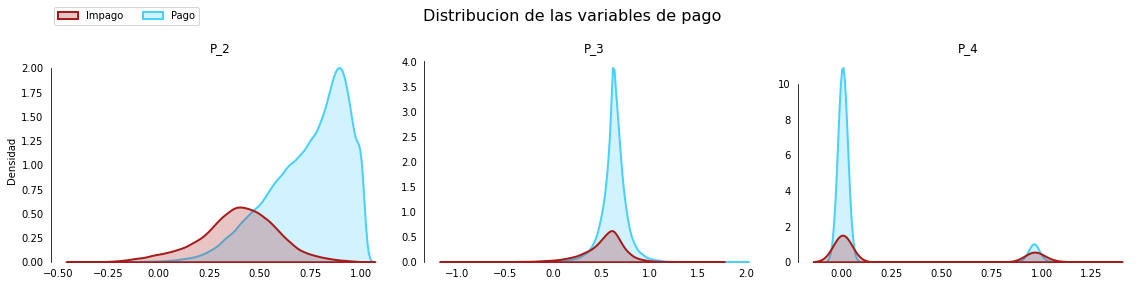

In [16]:
cols=[col for col in data_analysis.columns if (col.startswith(('P','t')))]
plot_df=data_analysis[cols]
fig, ax = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Distribucion de las variables de pago',fontsize=16)
for i, col in enumerate(plot_df.columns[:-1]):
    sns.kdeplot(x=col, hue='target', palette=pal[::-1], hue_order=[1,0], 
                label=['Impago','Pago'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[i])
    ax[i].tick_params(left=False,bottom=False)
    ax[i].set(title='{}'.format(col), xlabel='', ylabel=('Densidad' if i==0 else ''))
handles, _ = ax[0].get_legend_handles_labels() 
fig.legend(labels=['Impago','Pago'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 1))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

Vemos tambien que P_4 se comporta casi como una variable discreta, tomando valores muy cercanos a 0 o muy cercanos a 1.

Ahora analizaremos la correlación entre las variables de pago y la variable objetivo

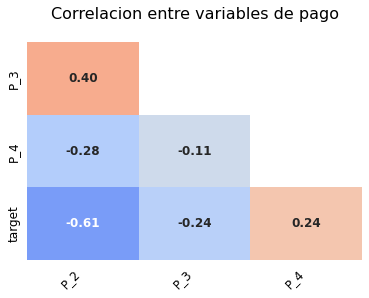

In [17]:
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots()   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':12,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlacion entre variables de pago\n', fontsize=16)
fig.show()

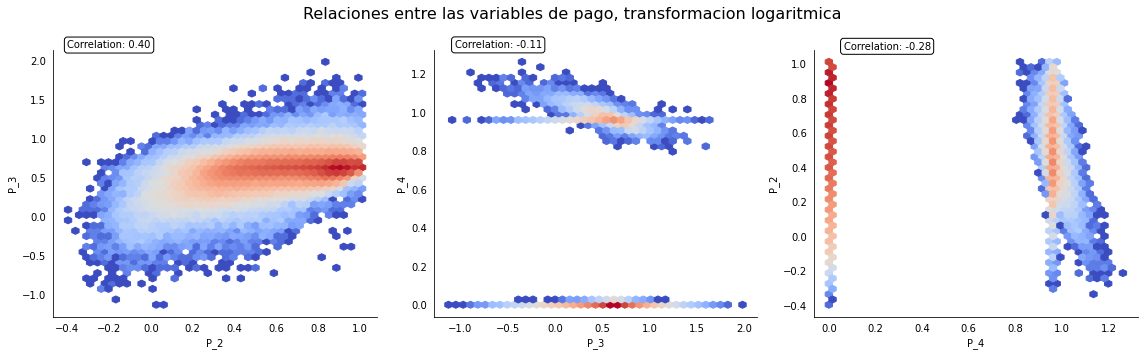

In [18]:
fig, ax = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Relaciones entre las variables de pago, transformacion logaritmica',fontsize=16)
ax[0].hexbin(x='P_2', y='P_3', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[0].text(-.2,2.2, 'Correlation: {:.2f}'.format(plot_df[['P_2','P_3']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[0].set(xlabel='P_2',ylabel='P_3')
ax[1].hexbin(x='P_3', y='P_4', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[1].text(-.6,1.35, 'Correlation: {:.2f}'.format(plot_df[['P_3','P_4']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[1].set(xlabel='P_3',ylabel='P_4')
ax[2].hexbin(x='P_4', y='P_2', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[2].text(.25,1.1, 'Correlation: {:.2f}'.format(plot_df[['P_4','P_2']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[2].set(xlabel='P_4',ylabel='P_2')
for i in range(3):
    ax[i].tick_params(left=False,bottom=False)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

Analizamos los nulos y vemos que no representan una gran cantidad respecto a la totalidad del dataset

In [19]:
null_p=round((data_analysis_p.isna().sum()/data_analysis_p.shape[0]*100),2).sort_values(ascending=False).astype(str)+('%')
null_p=null_p.to_frame().rename(columns={0:'Nulos'})
null_p

Nulos
P_3  5.46%
P_2  0.83%
P_4   0.0%

**Análisis de las variables de riesgo**

Analizamos el dataset enfocandonos en las variables de pago.

In [20]:
data_analysis_r = data_analysis.filter(regex='R_')

In [21]:
data_analysis_r.head()

R_1       R_2       R_3       R_4       R_5       R_6       R_7  \
0  0.000523  0.007256  0.100216  0.008654  0.001531  0.004678  0.007279   
1  0.001353  0.002758  0.403231  0.001245  0.003838  0.002758  0.009286   
2  0.005363  0.009494  0.005410  0.002155  0.007631  0.006482  0.004142   
3  0.003140  0.009562  0.002011  0.003510  0.007657  0.008440  0.002413   
4  0.002294  0.000224  0.009458  0.009815  0.003009  0.003825  0.009460   

        R_8       R_9      R_10  ...      R_19      R_20      R_21      R_22  \
0  0.004401       NaN  0.008209  ...  0.001594  0.004098  0.005808  0.005206   
1  0.003402       NaN  0.004122  ...  0.006698  0.004263  0.006092  0.009296   
2  0.006154       NaN  0.002810  ...  0.004743  0.002488  0.009322  0.007025   
3  0.006285       NaN  0.007660  ...  0.003104  0.008280  0.002895  0.008769   
4  0.005437  0.167479  0.003390  ...  0.003107  0.009465  0.003264  0.009742   

       R_23      R_24      R_25      R_26      R_27      R_28  
0  0.001998  0.005628  0.009813       NaN  1.000463  0.005287  
1  0.008139  0.005886  0.005215       NaN  1.004238  0.001165  
2  0.004480  0.000019  0.007587       NaN  1.006115  0.007438  
3  0.004728  0.002298  0.001351  0.005327  0.016974  0.007980  
4  0.002701  0.003714  0.001767  0.044458  0.020793  0.000394  

[5 rows x 28 columns]

Analizamos las distribuciones de variables para las de riesgo. De nuevo vemos distribuciones parecidas entre los clientes deudores y no deudores. Observamos tambien variables con valores atipicos muy marcados, con máximos muy alejados de su media y cuartiles.

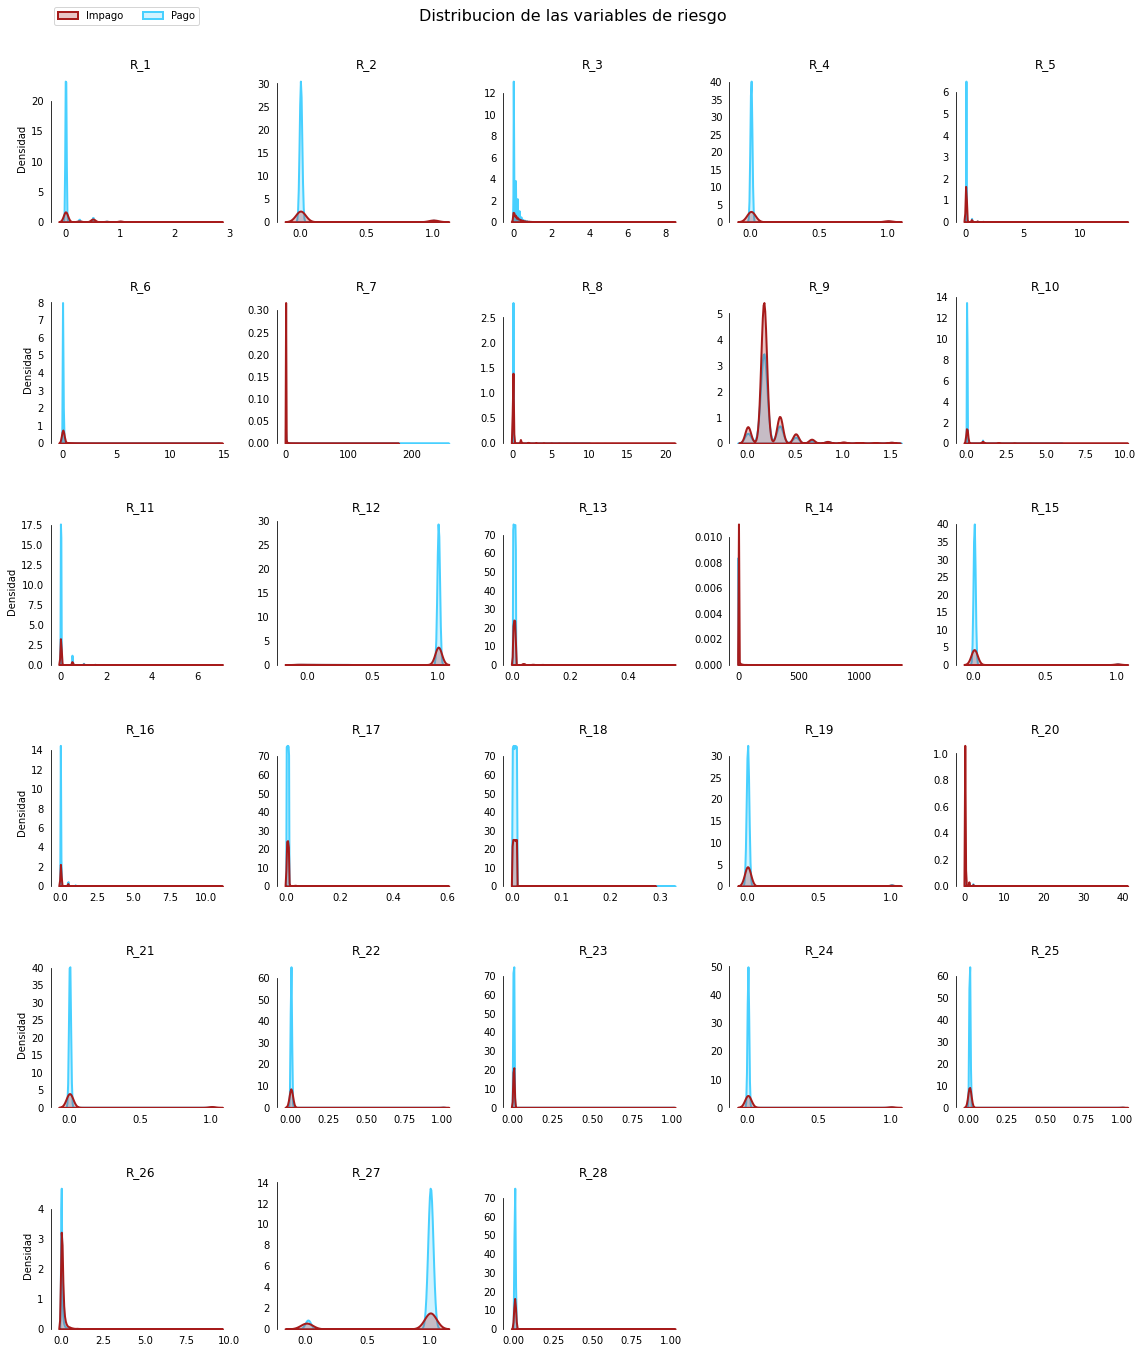

In [22]:
cols=[col for col in data_analysis.columns if (col.startswith(('R','t'))) & (col not in categorical_ignore_target)]
plot_df=data_analysis[cols]
fig, ax = plt.subplots(6,5, figsize=(16,24))
fig.suptitle('Distribucion de las variables de riesgo',fontsize=16)
row=0
col=[0,1,2,3,4]*6
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='target', palette=pal[::-1], hue_order=[1,0], 
                label=['Impago','Pago'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Densidad' if i%5==0 else ''))
for i in range(3,5):
    ax[5,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Impago','Pago'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.984))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

In [23]:
data_analysis_r[['R_5', 'R_7', 'R_8', 'R_14', 'R_26', 'R_20']].describe().applymap("{0:.2f}".format)

R_5        R_7        R_8       R_14      R_26       R_20
count  276572.00  276572.00  276572.00  276572.00  30568.00  276568.00
mean        0.03       0.09       0.04       0.23      0.08       0.04
std         0.25       1.63       0.31       7.35      0.26       0.40
min         0.00       0.00       0.00       0.00      0.00       0.00
25%         0.00       0.00       0.00       0.00      0.01       0.00
50%         0.01       0.01       0.01       0.01      0.04       0.01
75%         0.01       0.01       0.01       0.01      0.08       0.01
max        14.01     259.49      21.00    1337.05      9.51      41.00

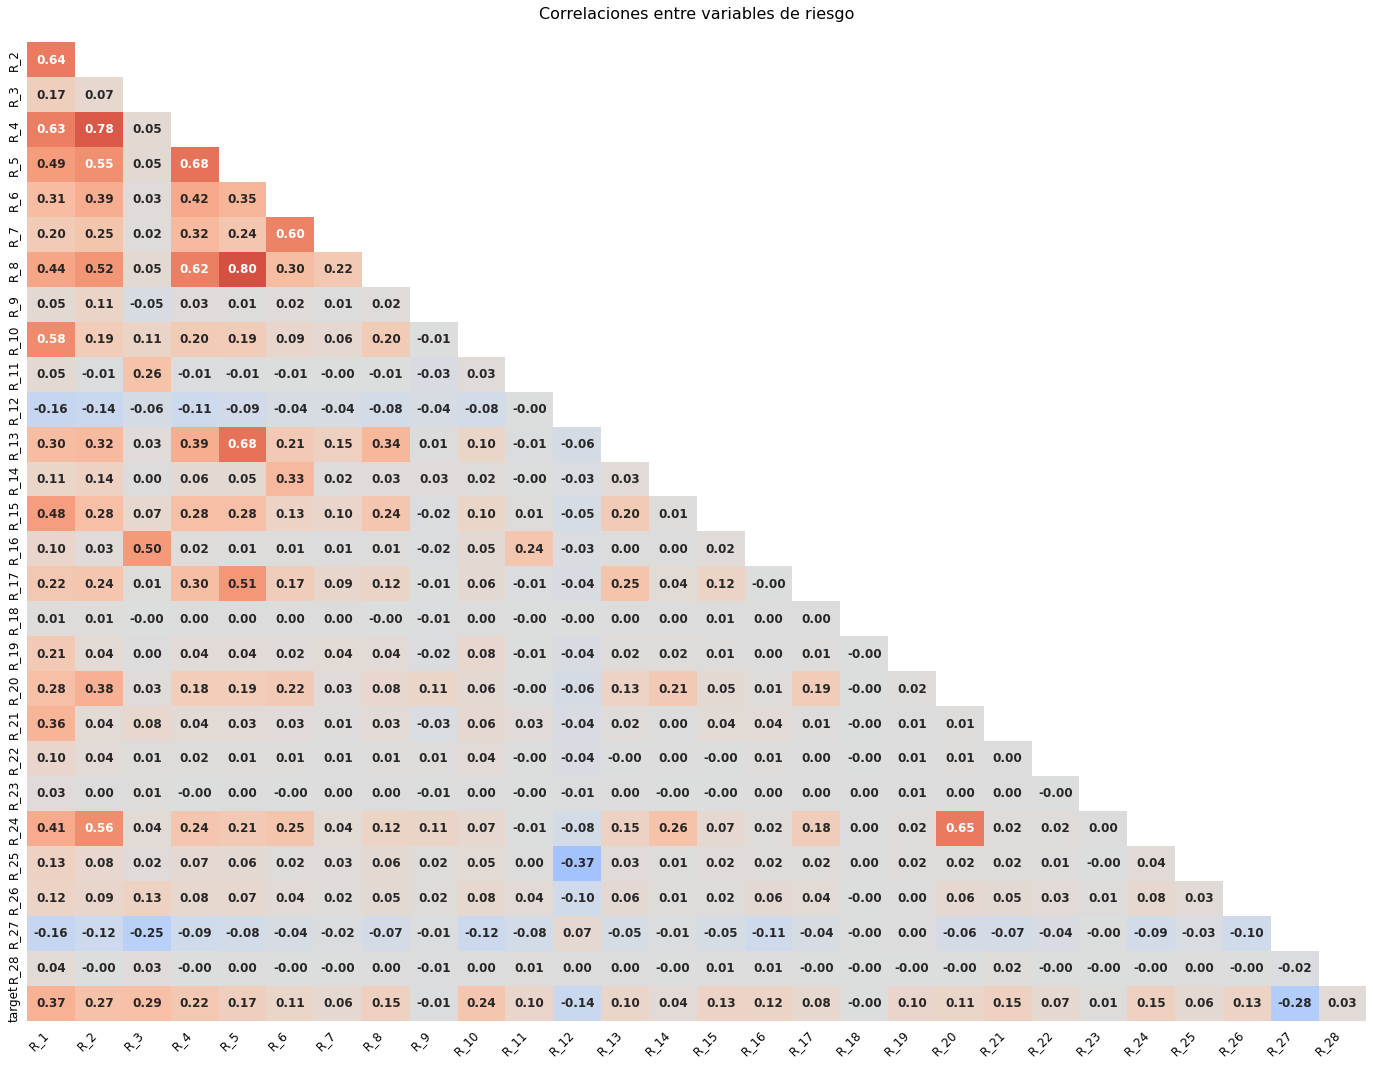

In [24]:
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(24,18))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':12,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlaciones entre variables de riesgo\n', fontsize=16)
fig.show()

Encontramos correlaciones fuertes entre algunas variables (R_2/R_4, R_8/R_5), pero tambien vemos otras muy debiles (R_18, R_23, R_28) con el resto de variables.

Analizando los valores nulos para las variables de riesgo, encontramos R_9 y R_26 con porcentajes muy altos de registros sin informacion.

In [25]:
null_r=round((data_analysis_r.isna().sum()/data_analysis_r.shape[0]*100),2).sort_values(ascending=False).astype(str)+('%')
null_r=null_r.to_frame().rename(columns={0:'Nulos'})
null_r.head(10)

Nulos
R_9   94.38%
R_26  88.95%
R_27   2.34%
R_1     0.0%
R_16    0.0%
R_25    0.0%
R_24    0.0%
R_23    0.0%
R_22    0.0%
R_21    0.0%

**Análisis de las variables de balance**

Analizamos el dataset enfocandonos en las variables de balance.

In [26]:
data_analysis_b = data_analysis.filter(regex='B_')

In [27]:
data_analysis_b.head()

B_1       B_2       B_3       B_4       B_5       B_6       B_7  \
0  0.025544  0.815019  0.000053  0.020668  0.032693  0.196887  0.027959   
1  0.106145  0.048557  0.223204  0.031958  0.012533  0.035634  0.065691   
2  0.099128  0.082039  0.158300  0.048449  0.007006  0.181719  0.033936   
3  0.954861  0.023890  1.175081  0.699000  0.028901  0.010289  0.468563   
4  0.096867  0.040793  0.223131  0.385191  0.003299  0.007889  0.463966   

        B_8       B_9      B_10  ...  B_31      B_32      B_33      B_36  \
0  1.002413  0.047979  0.246444  ...     1  0.002240  1.008405  0.000866   
1  1.002818  1.247342  0.028599  ...     1  0.000612  0.008209  0.001072   
2  0.000682  0.040150  0.257271  ...     1  0.002647  0.002809  0.004637   
3  1.001675  0.552134  0.020635  ...     1  1.000666  0.004190  0.004827   
4  1.001388  0.568149  0.016876  ...     1  0.005181  0.001290  0.003305   

       B_37  B_38  B_39      B_40      B_41  B_42  
0  0.023285   2.0   NaN  0.000022  0.000436   NaN  
1  0.113067   5.0   NaN  0.068912  0.007094   NaN  
2  0.105969   3.0   NaN  0.027418  0.005223   NaN  
3  0.950432   5.0   NaN  0.318635  0.001734   NaN  
4  0.103209   4.0   NaN  0.273853  0.002352   NaN  

[5 rows x 40 columns]

Analizamos las distribuciones de las variables de balance. De nuevo vemos distribuciones parecidas para deudores y no deudores, junto con variables con valores atipicos marcados.

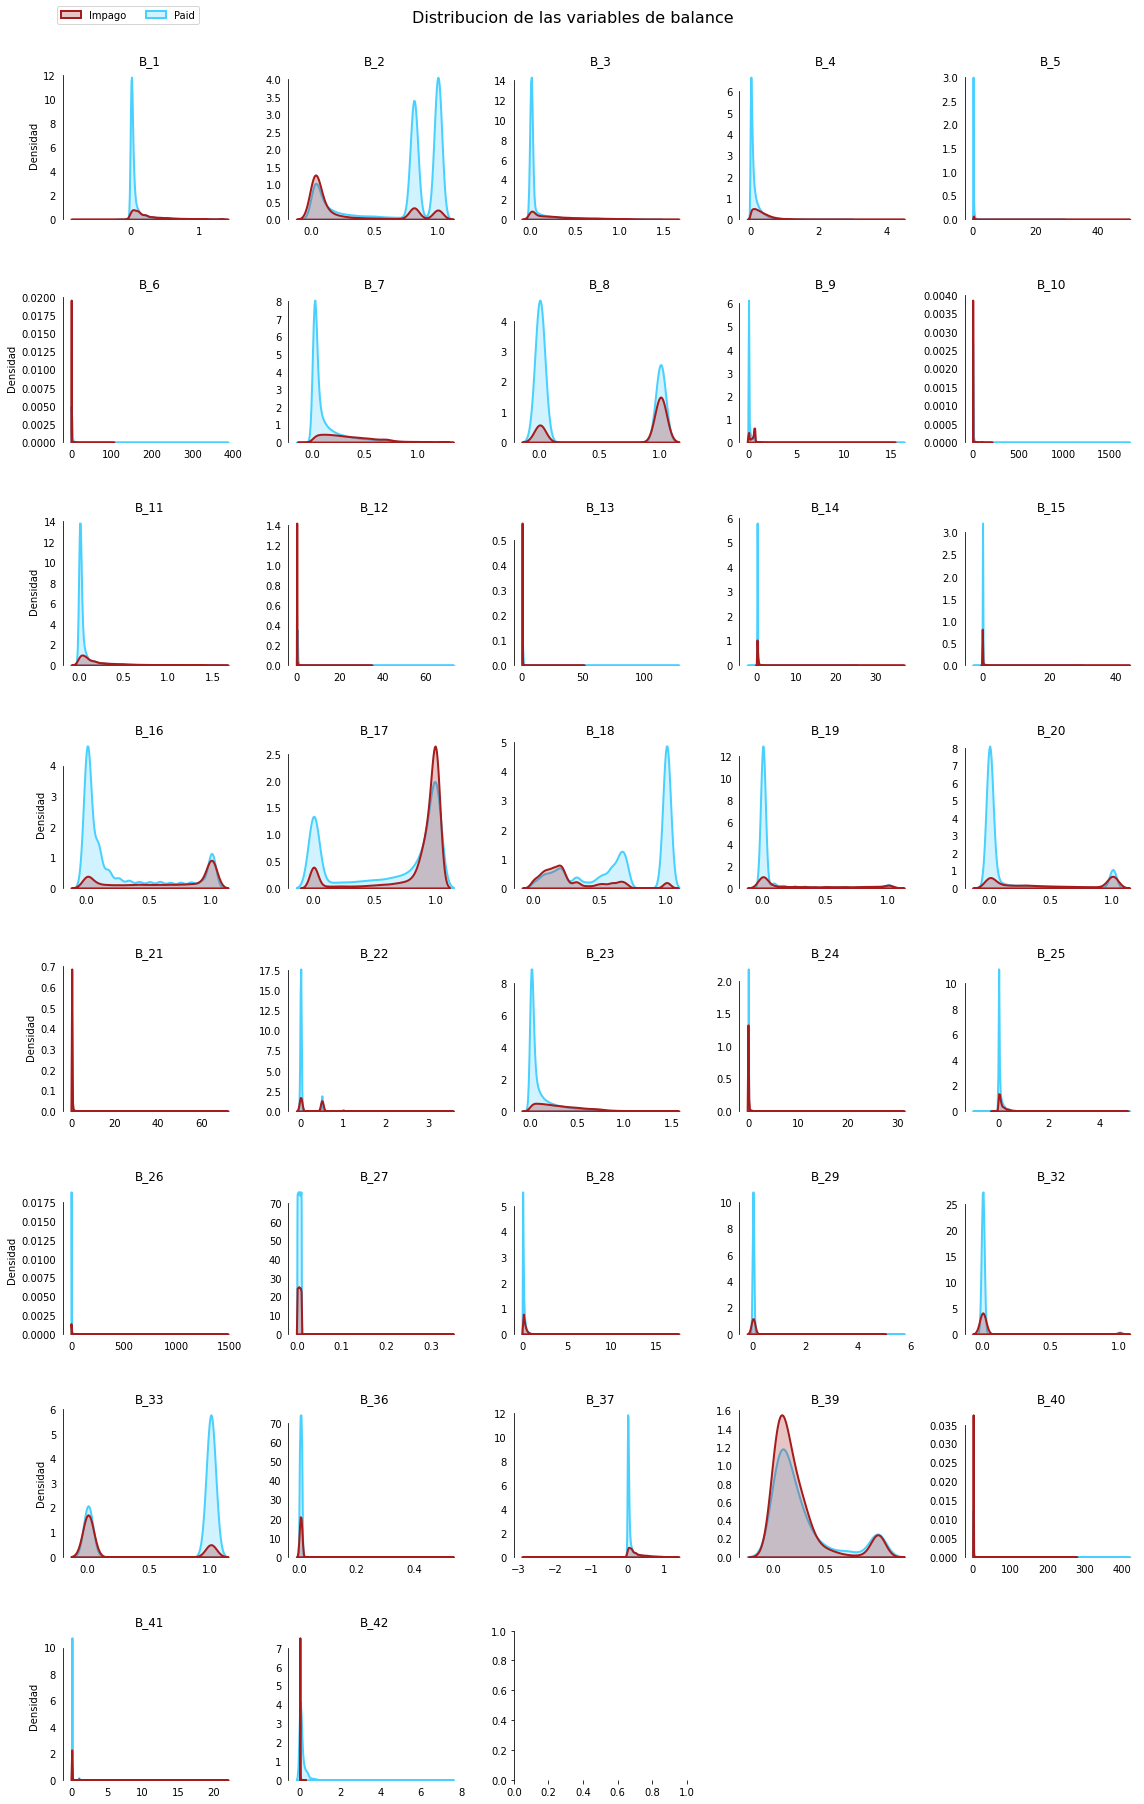

In [28]:
cols=[col for col in data_analysis.columns if (col.startswith(('B','t'))) & (col not in categorical_ignore_target)]
plot_df=data_analysis[cols]
fig, ax = plt.subplots(8,5, figsize=(16,32))
fig.suptitle('Distribucion de las variables de balance',fontsize=16)
row=0
col=[0,1,2,3,4]*8
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='target', palette=pal[::-1], hue_order=[1,0], 
                label=['Impago','Pago'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Densidad' if i%5==0 else ''))
for i in range(3,5):
    ax[7,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Impago','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.984))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

In [29]:
data_analysis_b[['B_6', 'B_10', 'B_12', 'B_13', 'B_14', 'B_15', 'B_26', 'B_40']].describe().applymap("{0:.2f}".format)

B_6       B_10       B_12       B_13       B_14       B_15  \
count  276561.00  276572.00  276572.00  274001.00  276572.00  276233.00   
mean        0.15       0.24       0.09       0.10       0.10       0.05   
std         1.01       4.80       0.43       0.49       0.28       0.29   
min        -0.00      -0.00       0.00       0.00      -2.42      -2.87   
25%         0.02       0.03       0.01       0.01       0.01       0.00   
50%         0.08       0.11       0.02       0.03       0.03       0.01   
75%         0.19       0.30       0.07       0.09       0.10       0.01   
max       387.34    1722.19      72.95     128.56      37.21      43.99   

            B_26       B_40  
count  276477.00  276569.00  
mean        0.09       0.19  
std         3.78       1.27  
min         0.00       0.00  
25%         0.00       0.02  
50%         0.01       0.06  
75%         0.01       0.24  
max      1481.76     421.38

Analizamos la correlacion entre variables. En este caso encontramos correlaciones lineales mucho mas marcadas que con las variables anteriores. Graficamos algunas de ellas.

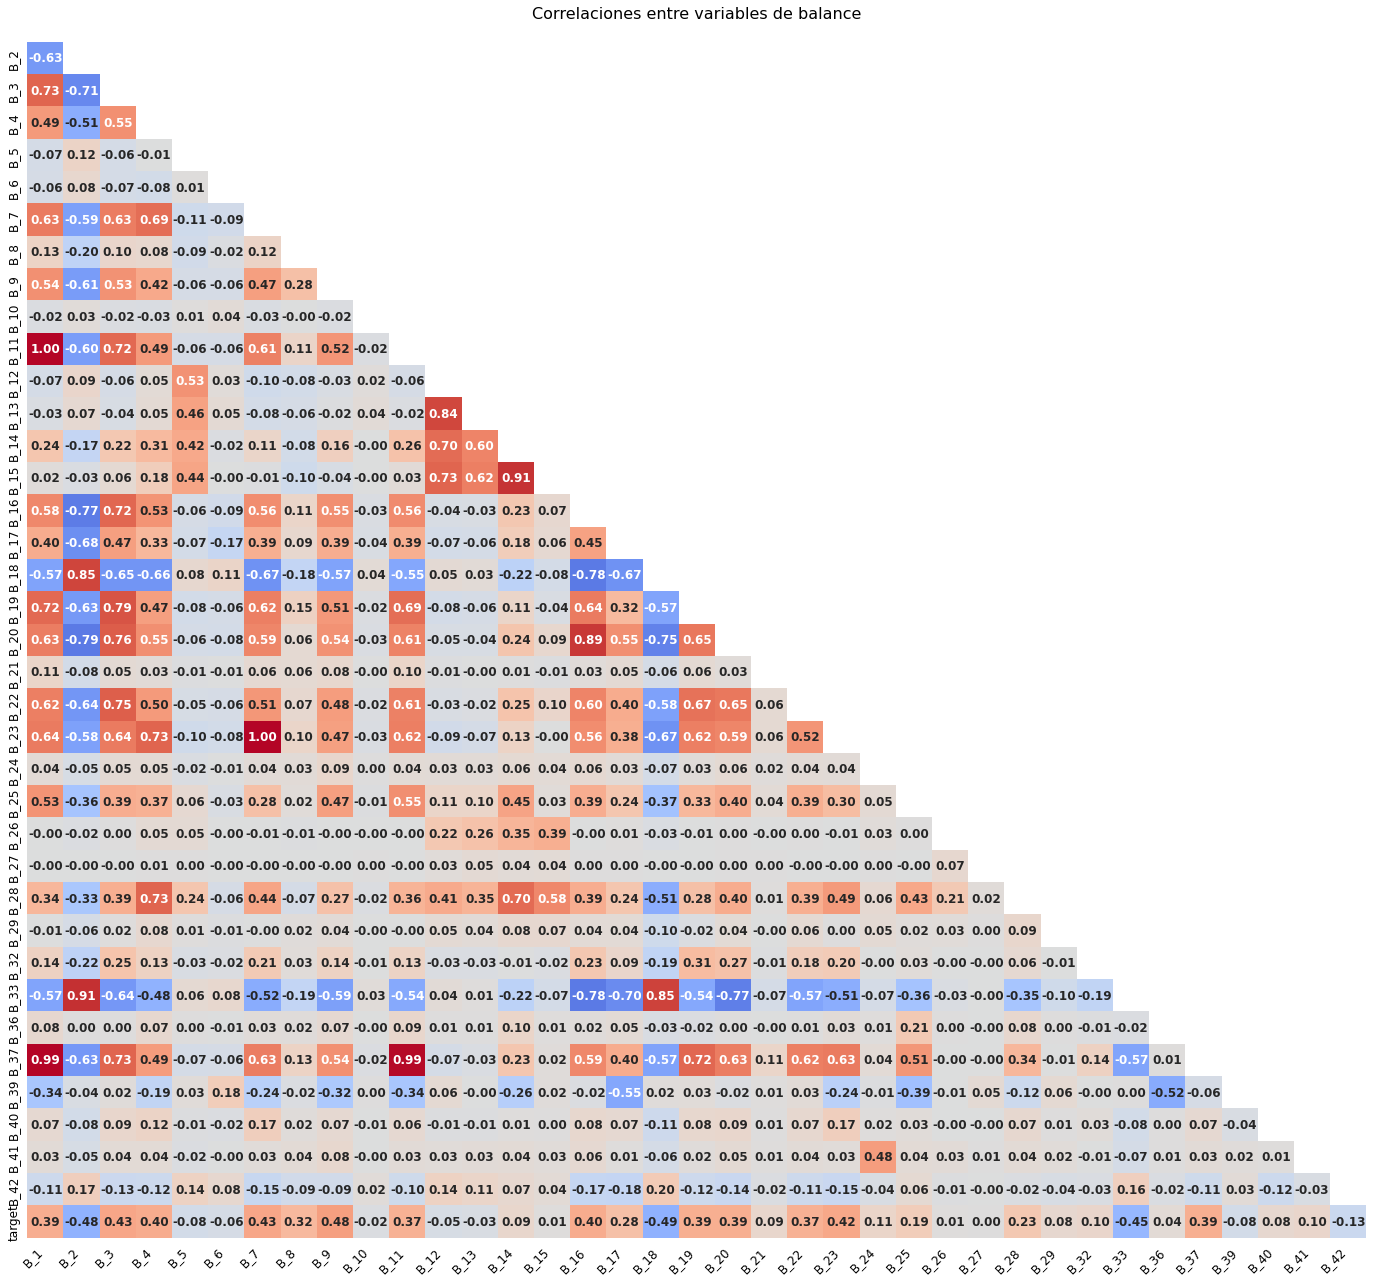

In [30]:
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(24,22))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':12,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlaciones entre variables de balance\n', fontsize=16)
fig.show()

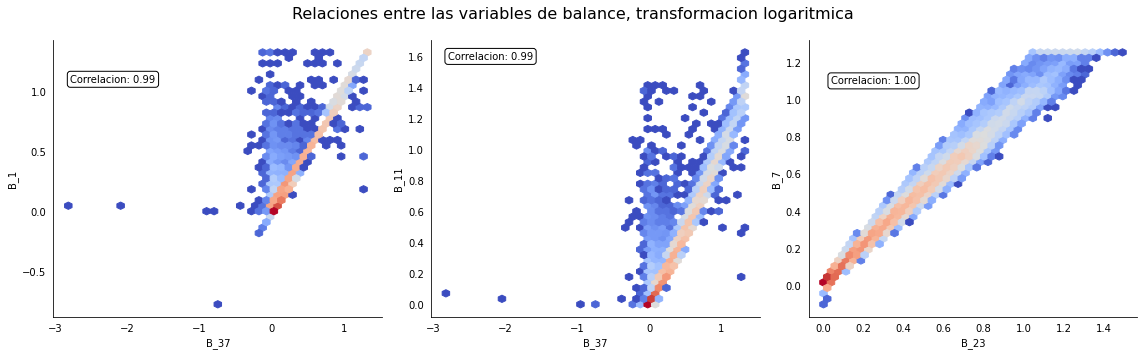

In [31]:
fig, ax = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Relaciones entre las variables de balance, transformacion logaritmica',fontsize=16)
ax[0].hexbin(x='B_37', y='B_1', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[0].text(-2.2,1.1, 'Correlacion: {:.2f}'.format(plot_df[['B_37','B_1']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[0].set(xlabel='B_37',ylabel='B_1')
ax[1].hexbin(x='B_37', y='B_11', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[1].text(-2.2,1.6, 'Correlacion: {:.2f}'.format(plot_df[['B_37','B_11']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[1].set(xlabel='B_37',ylabel='B_11')
ax[2].hexbin(x='B_23', y='B_7', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[2].text(.25,1.1, 'Correlacion: {:.2f}'.format(plot_df[['B_23','B_7']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[2].set(xlabel='B_23',ylabel='B_7')
for i in range(3):
    ax[i].tick_params(left=False,bottom=False)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

Encontramos a las variables B_39, B_42, B_29 y B_17 con porcentajes elevados de registros sin informacion.

In [32]:
null_b=round((data_analysis_b.isna().sum()/data_analysis_b.shape[0]*100),2).sort_values(ascending=False).astype(str)+('%')
null_b=null_b.to_frame().rename(columns={0:'Nulos'})
null_b.head(10)

Nulos
B_39  99.39%
B_42  98.68%
B_29  93.14%
B_17   56.8%
B_13   0.93%
B_8    0.42%
B_15   0.12%
B_25   0.12%
B_22   0.03%
B_2    0.03%

**Análisis de las variables de gasto**

Analizamos el dataset enfocandonos en las variables de gasto.

In [33]:
data_analysis_s = data_analysis.filter(regex='S_')

In [34]:
data_analysis_s.head()

S_2       S_3       S_5       S_6       S_7       S_8       S_9  \
0  2017-10-23  0.172446  0.112138  0.003893  0.260523  0.169409  0.010278   
1  2017-11-10  0.330037  0.002578  0.003126  0.445464  0.408678       NaN   
2  2017-10-15  0.092882  0.048476  0.006453  0.063807  0.603488       NaN   
3  2017-03-15       NaN  0.001456  1.009200       NaN  0.006590       NaN   
4  2017-07-01  0.460324  0.042095  0.009332  0.568983  0.328557       NaN   

       S_11      S_12      S_13  ...      S_17      S_18      S_19      S_20  \
0  0.360887  0.527271  0.428770  ...  0.001566  0.009109  0.007935  0.009446   
1  0.608055  0.194140  0.286779  ...  0.007110  0.009980  0.006401  0.007262   
2  0.646233  0.184548  0.402759  ...  0.006024  0.003152  0.003987  0.007790   
3  0.282493  0.187612  0.006686  ...  0.004431  0.006020  0.004563  0.006627   
4  0.324719  0.194203  0.003627  ...  0.004644  0.001587  0.009057  0.007922   

       S_22       S_23      S_24      S_25      S_26      S_27  
0  0.953877   0.138529  0.964936  0.973527  0.006532  0.569524  
1  0.962118   0.133528  0.966931  0.971813  0.005566  0.007328  
2  0.936502   0.136679  0.938479  0.971071  0.004748  0.000762  
3  0.304425  10.204194  0.079394       NaN  0.006128       NaN  
4  0.980483   0.397969  0.970203  0.101208  0.004177  0.004812  

[5 rows x 22 columns]

Viendo la distribución de las variables respecto a la variable objetivo, observamos el mismo comportamiento que con las variables ya analizadas.

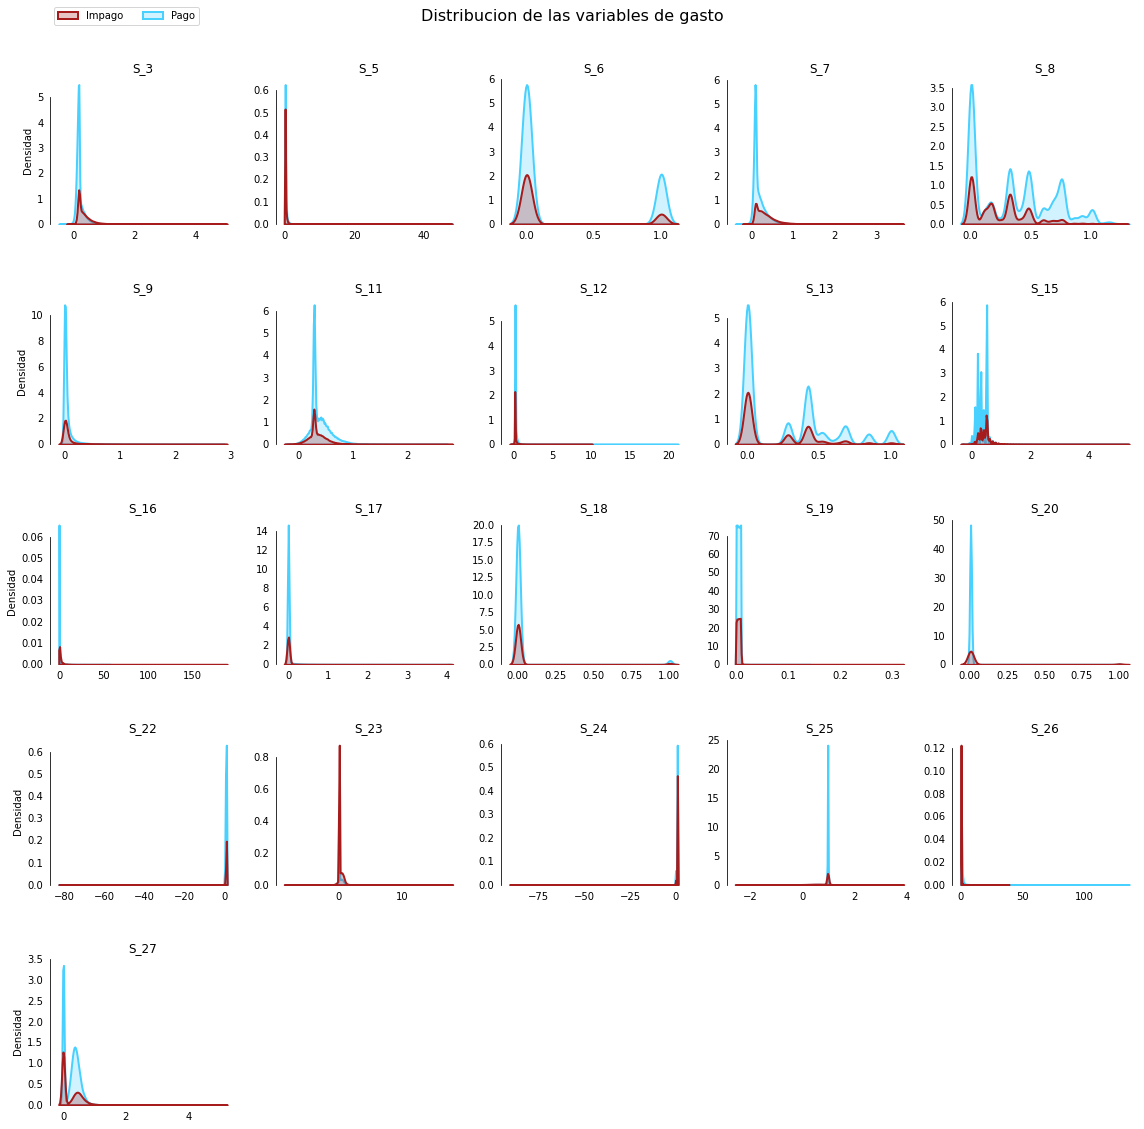

In [35]:
cols=[col for col in data_analysis.columns if (col.startswith(('S','t'))) & (col != 'S_2')]
plot_df=data_analysis[cols]
fig, ax = plt.subplots(5,5, figsize=(16,20))
fig.suptitle('Distribucion de las variables de gasto',fontsize=16)
row=0
col=[0,1,2,3,4]*5
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='target', palette=pal[::-1], hue_order=[1,0], 
                label=['Impago','Pago'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Densidad' if i%5==0 else ''))
for i in range(1,5):
    ax[4,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Impago','Pago'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.985))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

In [36]:
data_analysis_s[['S_5', 'S_12', 'S_16', 'S_22', 'S_23', 'S_24', 'S_26']].describe().applymap("{0:.2f}".format)

S_5       S_12       S_16       S_22       S_23       S_24  \
count  276572.00  276572.00  276572.00  275597.00  276549.00  275623.00   
mean        0.09       0.24       0.05       0.78       0.18       0.73   
std         0.37       0.21       0.71       0.75       0.27       0.84   
min         0.00      -0.39       0.00     -82.68      -8.30     -90.48   
25%         0.01       0.19       0.00       0.81       0.13       0.80   
50%         0.01       0.19       0.01       0.94       0.14       0.95   
75%         0.07       0.21       0.01       0.96       0.14       0.97   
max        48.32      21.16     188.74       1.03      17.83       1.05   

            S_26  
count  276546.00  
mean        0.07  
std         0.52  
min         0.00  
25%         0.00  
50%         0.01  
75%         0.01  
max       136.67

Observando la correlación entre las distintas variables de gasto, sobresalen 2 relaciones fuertes, que separaremos para visualizar más de cerca.

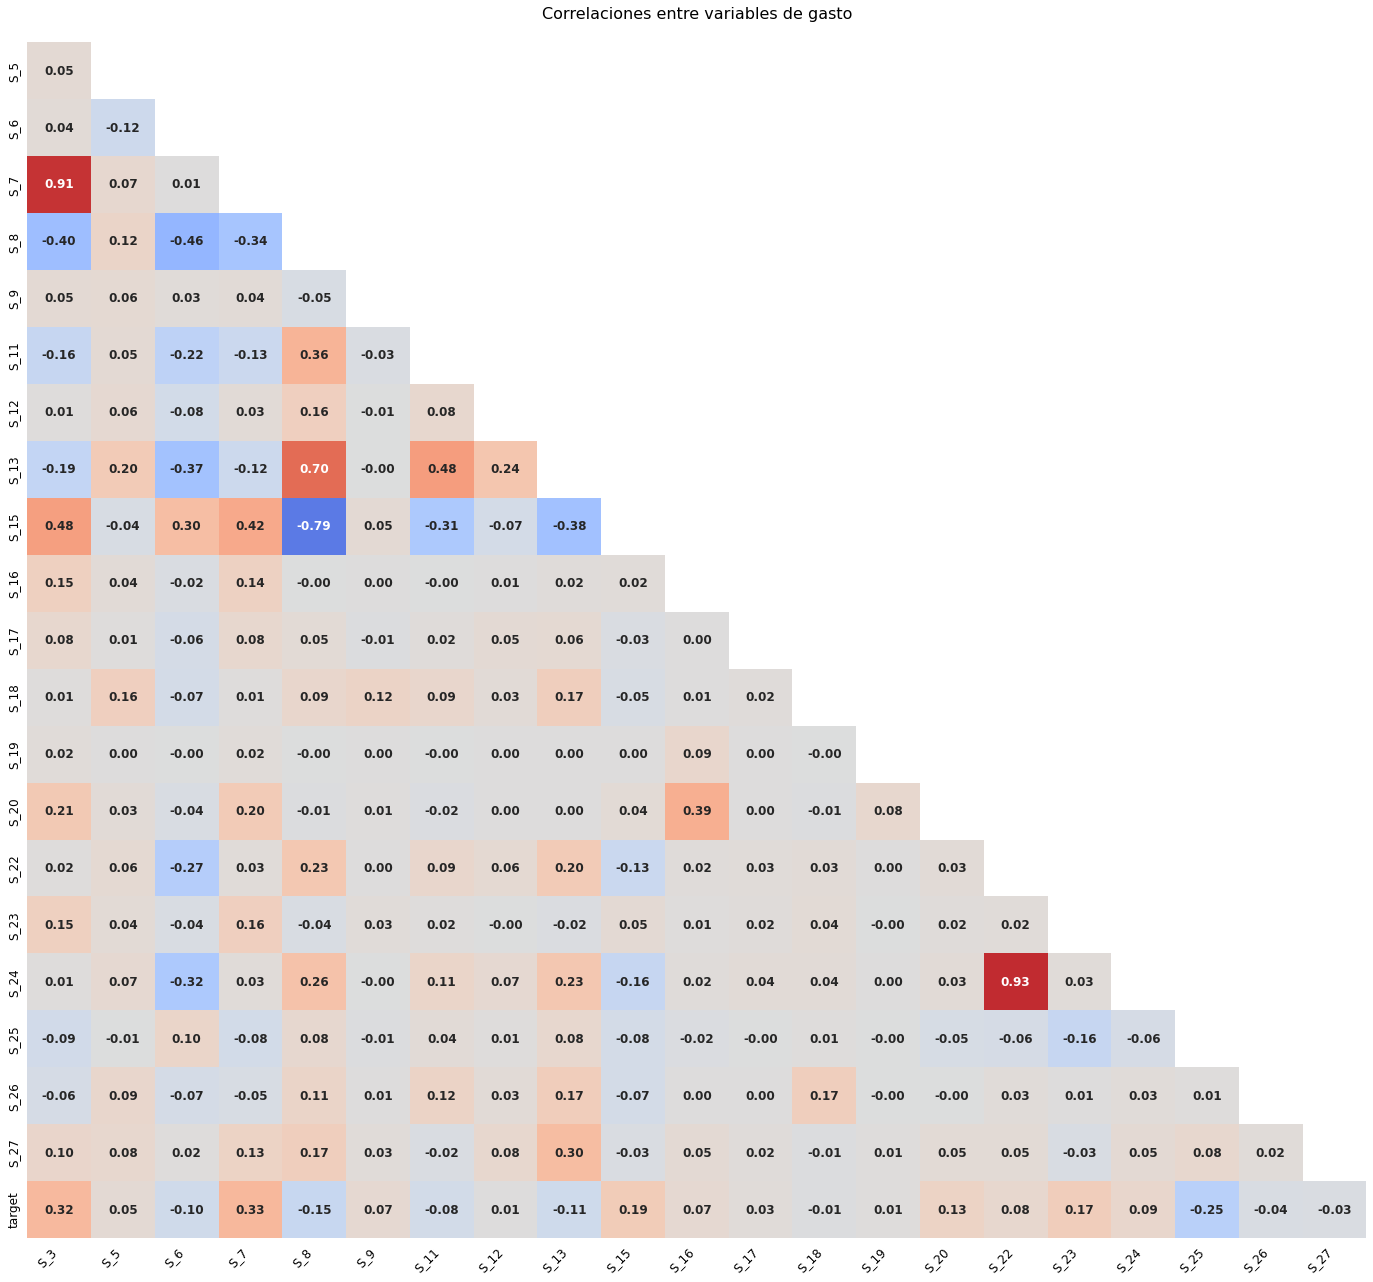

In [37]:
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(24,22))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':12,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlaciones entre variables de gasto\n', fontsize=16)
fig.show()

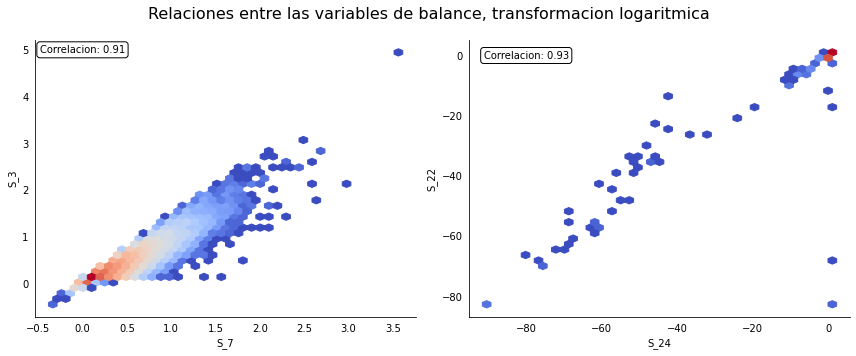

In [38]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Relaciones entre las variables de balance, transformacion logaritmica',fontsize=16)
ax[0].hexbin(x='S_7', y='S_3', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[0].text(0,5, 'Correlacion: {:.2f}'.format(plot_df[['S_7','S_3']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[0].set(xlabel='S_7',ylabel='S_3')
ax[1].hexbin(x='S_24', y='S_22', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[1].text(-80,0, 'Correlacion: {:.2f}'.format(plot_df[['S_24','S_22']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[1].set(xlabel='S_24',ylabel='S_22')
for i in range(2):
    ax[i].tick_params(left=False,bottom=False)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

Analizando los registros nulos, si bien no son tan elevados como en la variable anterior, S_9 supera el 50% del dataset.

Otro dato interesante es que tanto S_7 como S_3 presentan el mismo porcentaje de nulos, y de los gráficos de correlación habíamos observado que se encontraban fuertemente relacionados, por lo tanto tiene sentido que los nulos provengan de la misma fuente de datos.

In [39]:
null_s=round((data_analysis_s.isna().sum()/data_analysis_s.shape[0]*100),2).sort_values(ascending=False).astype(str)+('%')
null_s=null_s.to_frame().rename(columns={0:'Nulos'})
null_s.head(10)

Nulos
S_9   53.04%
S_27  25.34%
S_7   18.46%
S_3   18.46%
S_22   0.35%
S_24   0.34%
S_25   0.22%
S_26   0.01%
S_23   0.01%
S_18    0.0%

**Análisis de las variables de delincuencia**

Analizamos el dataset enfocandonos en las variables de delincuencia.

In [40]:
data_analysis_d = data_analysis.filter(regex='D_')

In [41]:
data_analysis_d.head()

D_39      D_41      D_42      D_43      D_44      D_45      D_46  \
0  0.033809  0.003708       NaN  0.064441  0.008099  0.076411  0.443989   
1  0.001548  0.009187  0.139045  0.068893  0.009326  0.025337       NaN   
2  0.215301  0.001929       NaN  0.009967  0.002224  0.339116  0.423821   
3  0.000278  0.008421       NaN  0.066728  0.378491  0.074820  0.599260   
4  0.592908  0.009938  0.295201  0.053988  0.126802  0.021206  0.426132   

       D_47      D_48  D_49  ...  D_136  D_137  D_138     D_139     D_140  \
0  0.409156  0.048084   NaN  ...    NaN    NaN    NaN  0.008022  0.004774   
1  0.014981  0.208866   NaN  ...    NaN    NaN    NaN  0.000510  0.001478   
2  0.516960  0.053792   NaN  ...    NaN    NaN    NaN  0.006687  0.007377   
3  0.113653  0.636184   NaN  ...    NaN    NaN    NaN  1.002518  0.001170   
4  0.624164  0.617264   NaN  ...    NaN    NaN    NaN  0.001164  0.001779   

      D_141     D_142     D_143     D_144     D_145  
0  0.004846       NaN  0.000654  0.001793  0.006356  
1  0.009909       NaN  0.004614  0.007917  0.006711  
2  0.008373       NaN  0.009990  0.002785  0.009664  
3  0.870115  0.141214  1.003923  0.008945  0.736632  
4  0.004852       NaN  0.006252  0.008367  0.005460  

[5 rows x 96 columns]

Volvemos a observar distribuciones parecidas respecto al resto de las variables, donde no se ve de forma marcada que una variable de delincuencia contribuya a la detección de una deuda impaga. Para D_88 por ejemplo si bien se observa mayor cantidad de deudas impagas, no nos alcanza para asumir que en la totalidad de los casos donde esto ocurra, la deuda será impaga.

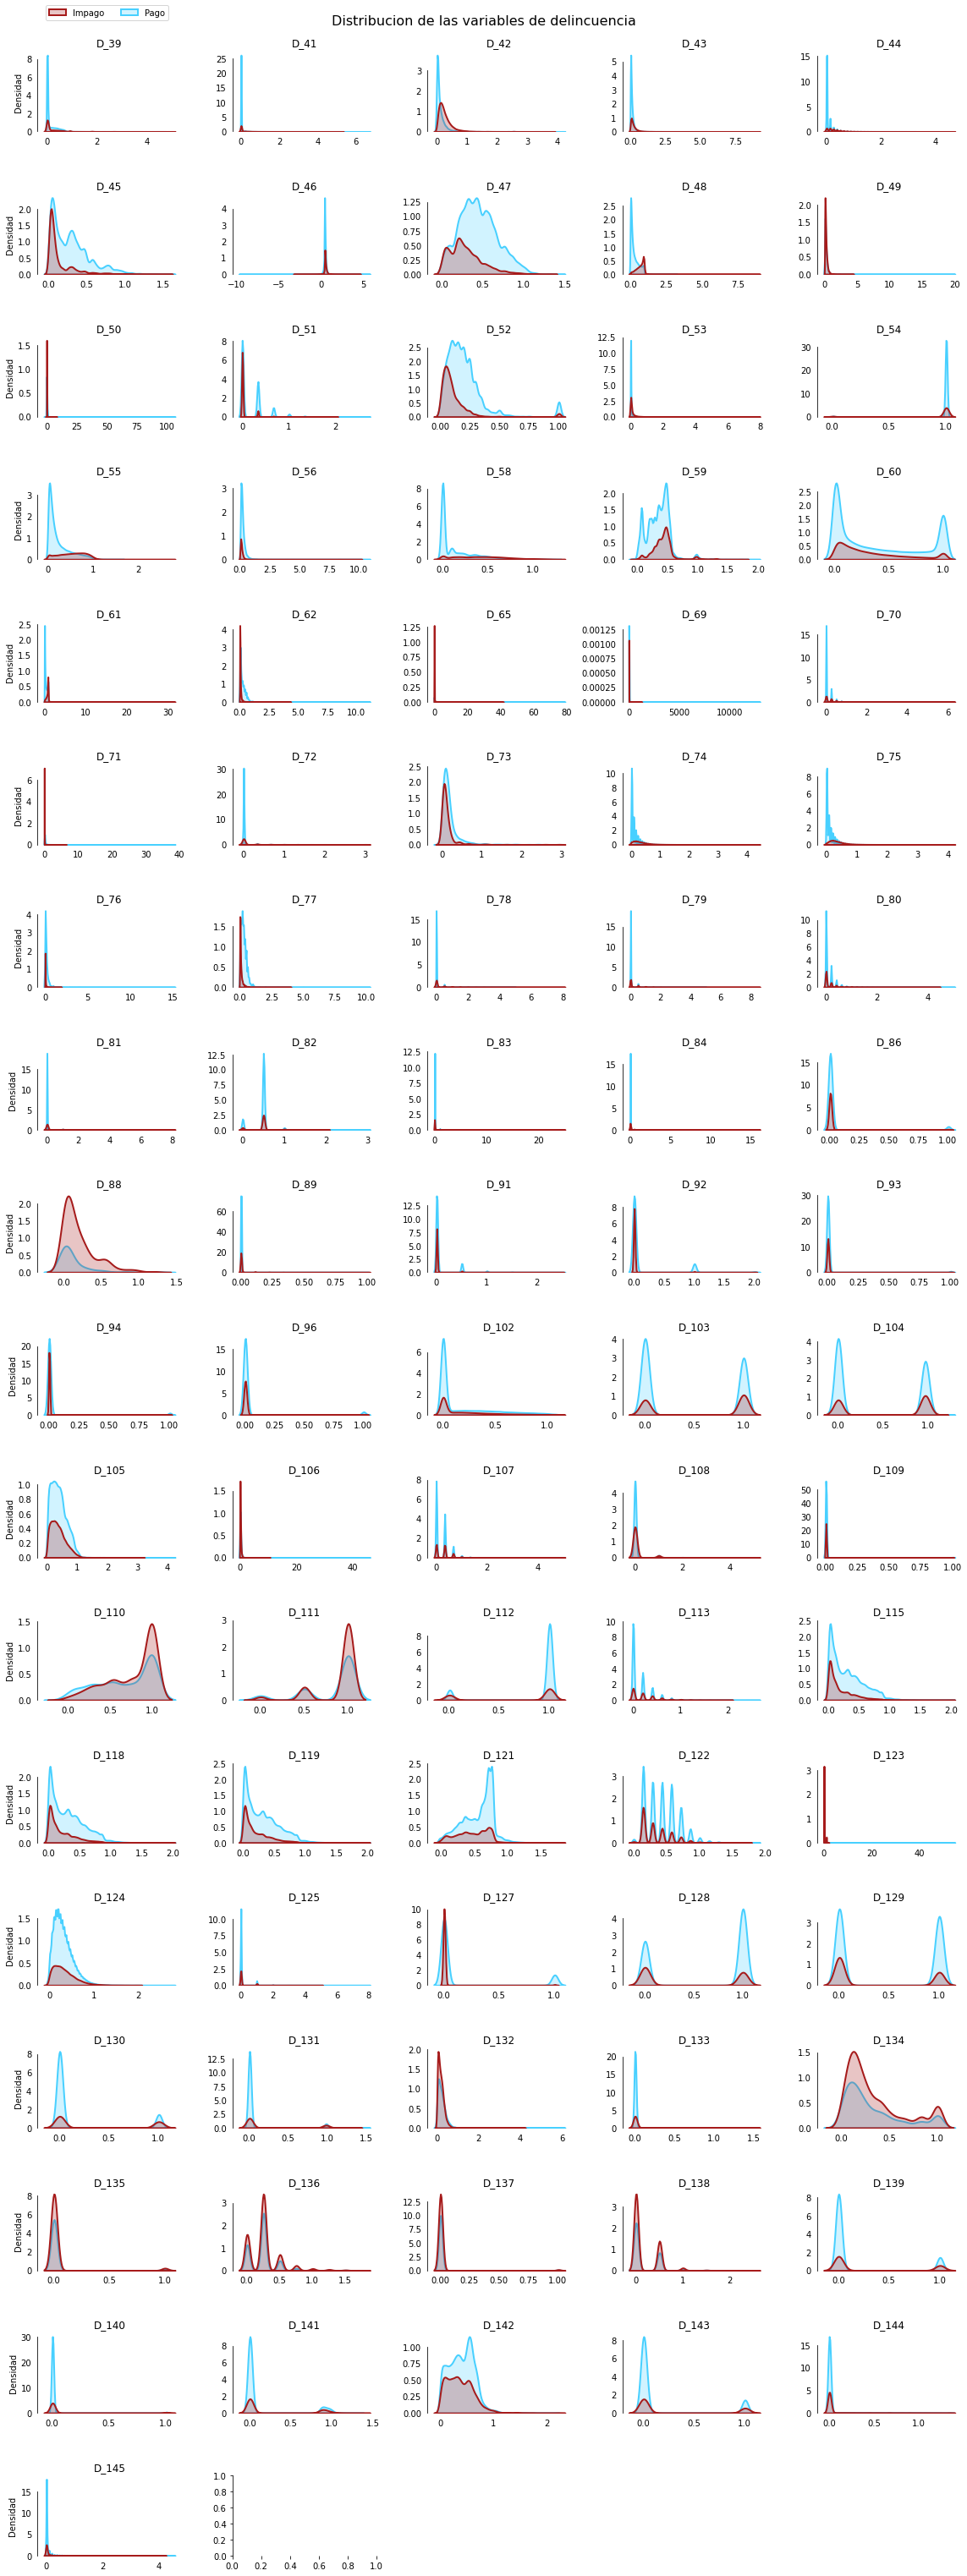

In [42]:
cols=[col for col in data_analysis.columns if (col.startswith(('D','t'))) & (col not in categorical_ignore_target)]
plot_df=data_analysis[cols]
fig, ax = plt.subplots(18,5, figsize=(16,54))
fig.suptitle('Distribucion de las variables de delincuencia',fontsize=16)
row=0
col=[0,1,2,3,4]*18
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='target', palette=pal[::-1], hue_order=[1,0], 
                label=['Impago','Pago'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Densidad' if i%5==0 else ''))
for i in range(2,5):
    ax[17,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Impago','Pago'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.984))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

Analizando la correlación, vemos correlaciones marcadas entre diferentes variables. Hacemos zoom en 3 correlaciones particulares:

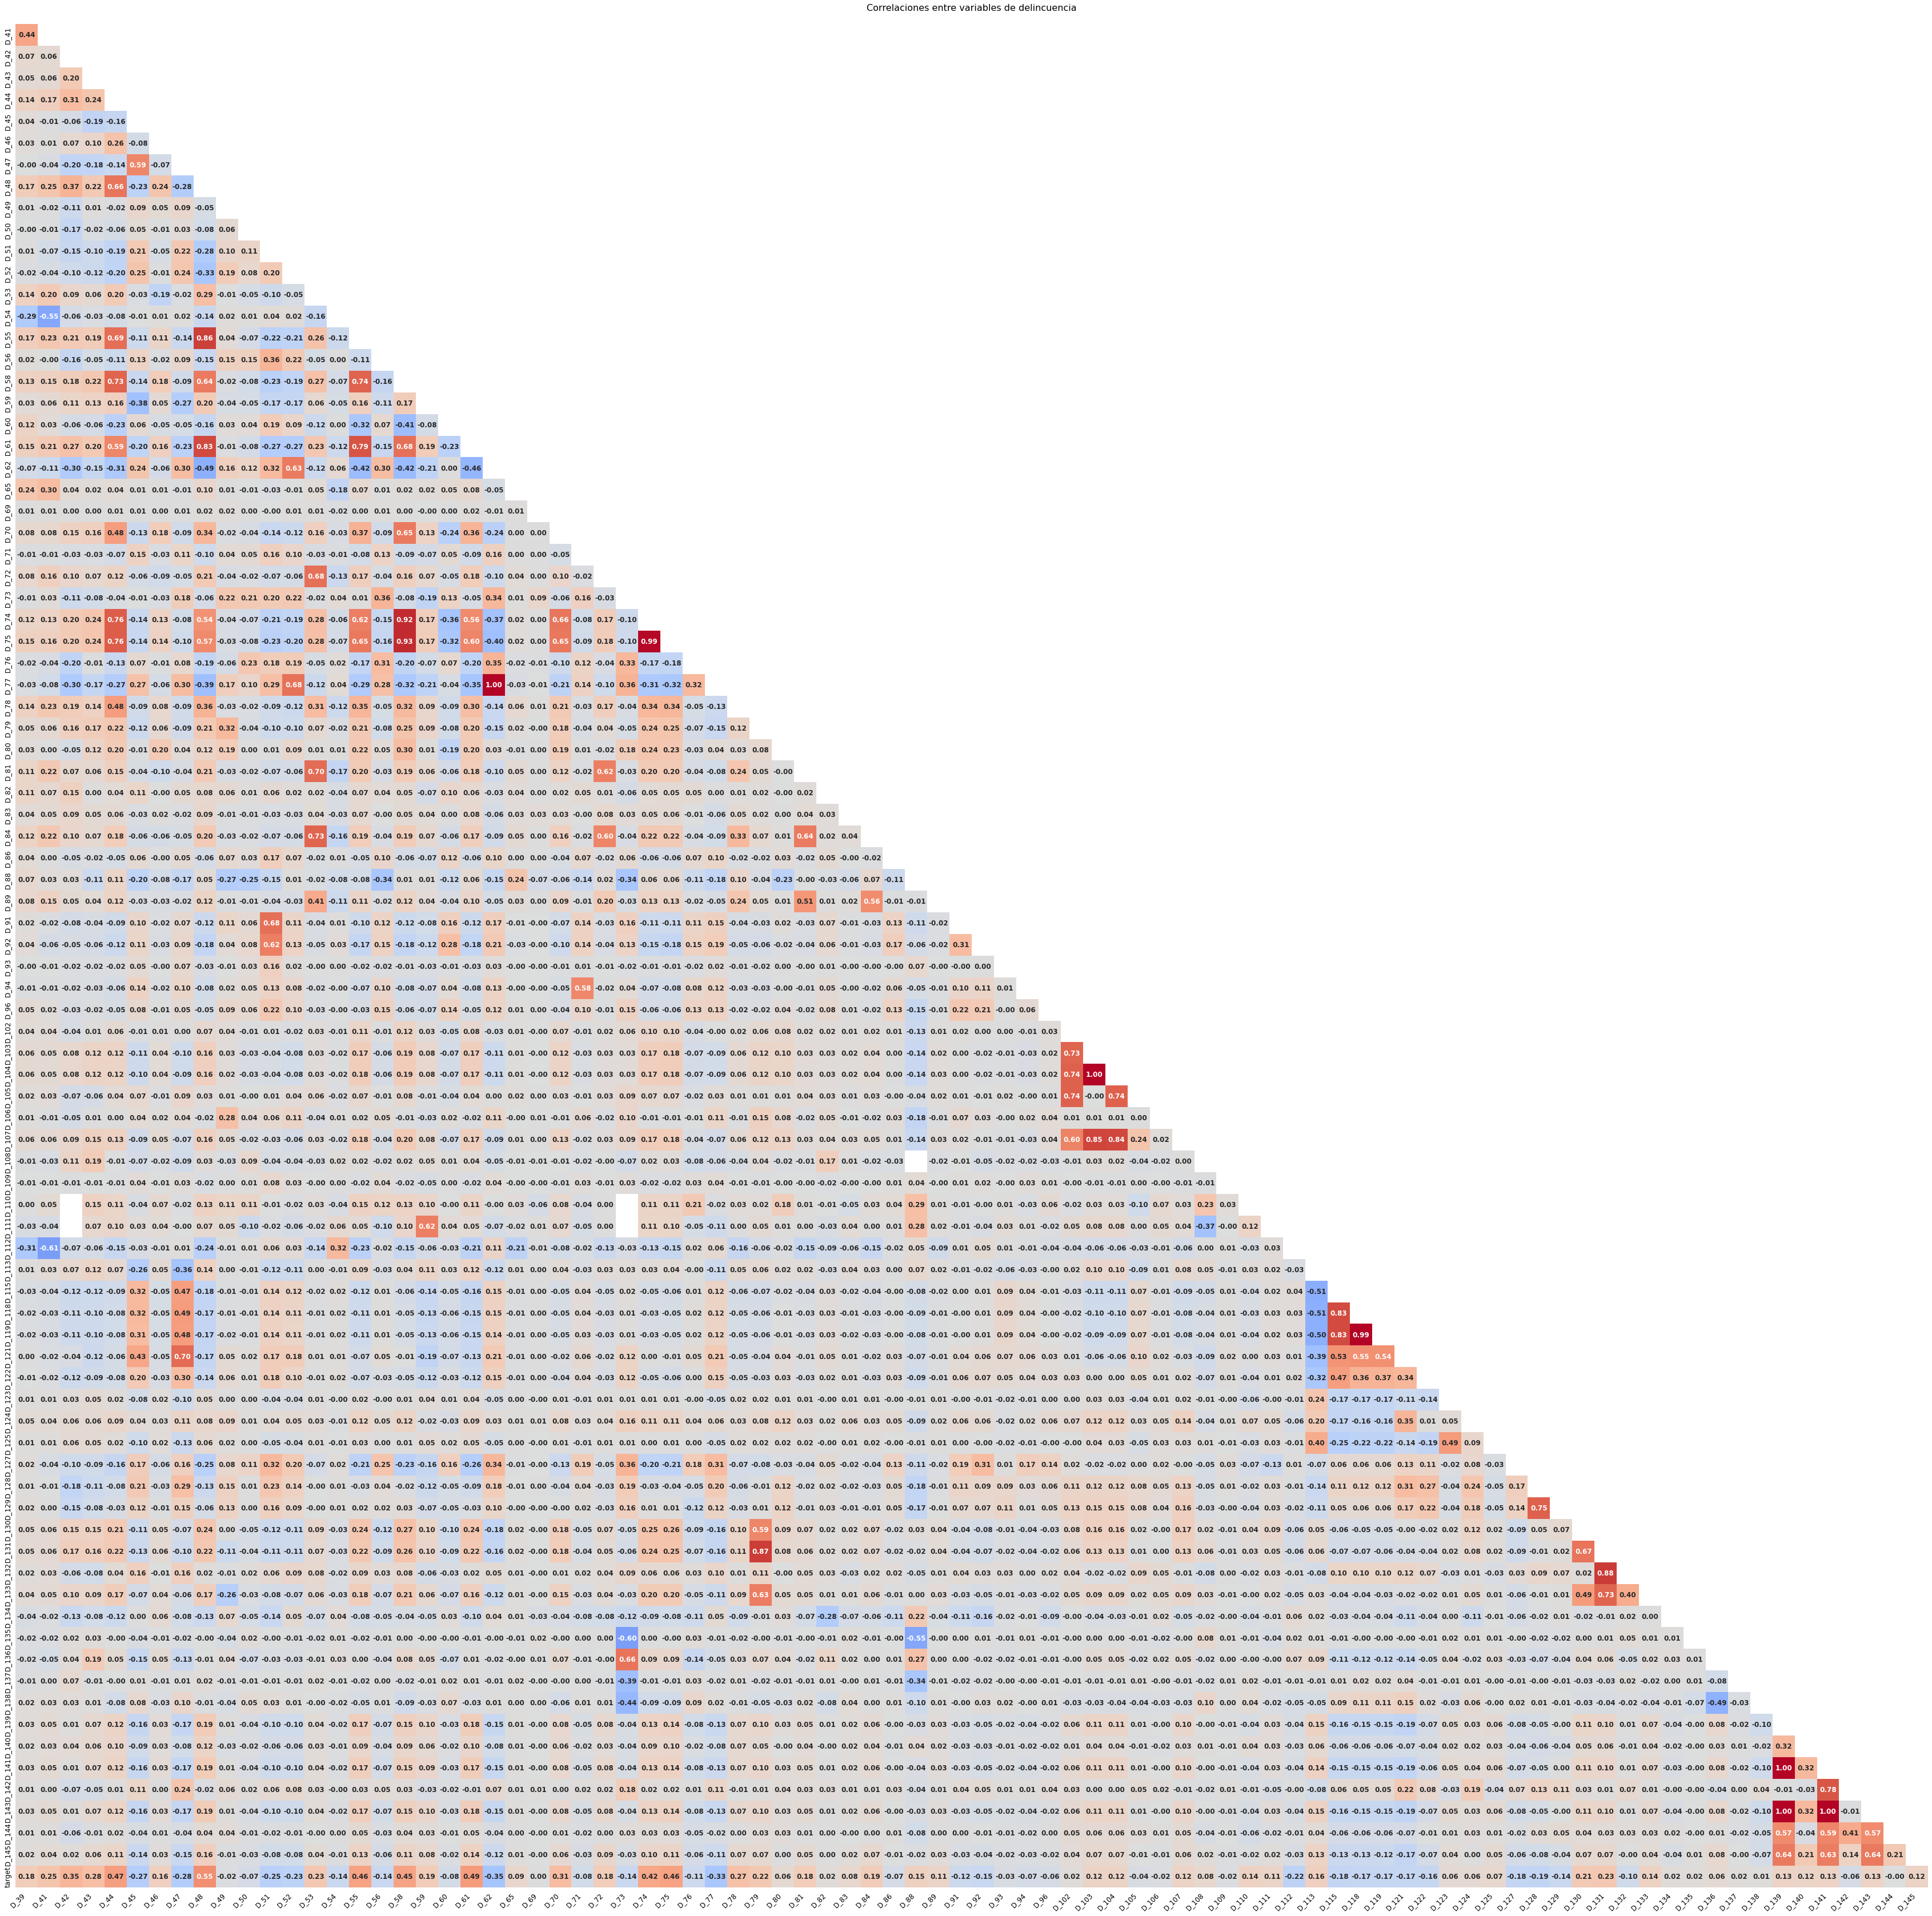

In [43]:
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(60,60))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':12,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlaciones entre variables de delincuencia\n', fontsize=16)
fig.show()

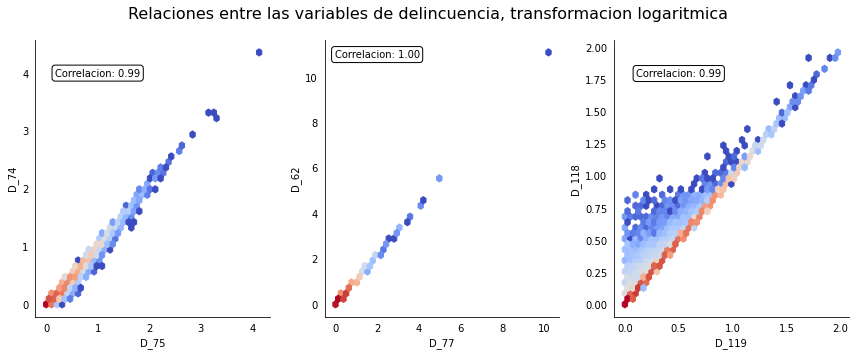

In [44]:
fig, ax = plt.subplots(1,3, figsize=(12,5))
fig.suptitle('Relaciones entre las variables de delincuencia, transformacion logaritmica',fontsize=16)
ax[0].hexbin(x='D_75', y='D_74', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[0].text(1,4, 'Correlacion: {:.2f}'.format(plot_df[['D_75','D_74']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[0].set(xlabel='D_75',ylabel='D_74')
ax[1].hexbin(x='D_77', y='D_62', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[1].text(2,11, 'Correlacion: {:.2f}'.format(plot_df[['D_77','D_62']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[1].set(xlabel='D_77',ylabel='D_62')
ax[2].hexbin(x='D_119', y='D_118', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[2].text(0.5,1.8, 'Correlacion: {:.2f}'.format(plot_df[['D_119','D_118']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[2].set(xlabel='D_119',ylabel='D_118')
for i in range(3):
    ax[i].tick_params(left=False,bottom=False)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

A diferencia del resto de las variables, para las de delincuencia se observa una cantidad bastante más marcada de nulos, donde hay 14 columnas con más del 90% de nulos.

In [45]:
null_d=round((data_analysis_d.isna().sum()/data_analysis_d.shape[0]*100),2).sort_values(ascending=False).astype(str)+('%')
null_d=null_d.to_frame().rename(columns={0:'Nulos'})
null_d.head(30)

Nulos
D_87   99.93%
D_88   99.89%
D_108  99.48%
D_110  99.43%
D_111  99.43%
D_73   99.01%
D_138  96.45%
D_136  96.45%
D_134  96.45%
D_135  96.45%
D_137  96.45%
D_106  90.25%
D_132  90.23%
D_49   90.18%
D_66    88.8%
D_76   88.71%
D_42   85.68%
D_142  83.03%
D_53   73.93%
D_82   73.46%
D_50   56.72%
D_105  54.59%
D_56   53.98%
D_77   45.45%
D_43   30.12%
D_46   22.01%
D_62   13.76%
D_48   13.03%
D_61   10.83%
D_44    4.97%

### Análisis y limpieza de valores nulos

Si bien ya vimos los nulos separados por cada tipo de variable, vamos a realizar un análisis más general de los nulos del dataset para decidir que hacer con ellos.

In [46]:
nulls=round((data_analysis.isna().sum()/data_analysis.shape[0]*100),2).sort_values(ascending=False)
nulls=nulls.to_frame().rename(columns={0:'Nulos (%)'})
nulls.head(30)

Nulos (%)
D_87       99.93
D_88       99.89
D_108      99.48
D_111      99.43
D_110      99.43
B_39       99.39
D_73       99.01
B_42       98.68
D_138      96.45
D_137      96.45
D_134      96.45
D_135      96.45
D_136      96.45
R_9        94.38
B_29       93.14
D_106      90.25
D_132      90.23
D_49       90.18
R_26       88.95
D_66       88.80
D_76       88.71
D_42       85.68
D_142      83.03
D_53       73.93
D_82       73.46
B_17       56.80
D_50       56.72
D_105      54.59
D_56       53.98
S_9        53.04

Dada la cantidad de columnas con valores nulos, eliminaremos aquellas con un porcentaje mayor al 80% porque de los valores restantes, si los completamos con un valor (la media o la mediana), no nos daría mucha información de la columna. Y si eliminamos los registros nulos, perderíamos casi la totalidad del dataset.

In [47]:
nulls_cols = nulls[nulls['Nulos (%)'] >= 80]
nulls_cols

Nulos (%)
D_87       99.93
D_88       99.89
D_108      99.48
D_111      99.43
D_110      99.43
B_39       99.39
D_73       99.01
B_42       98.68
D_138      96.45
D_137      96.45
D_134      96.45
D_135      96.45
D_136      96.45
R_9        94.38
B_29       93.14
D_106      90.25
D_132      90.23
D_49       90.18
R_26       88.95
D_66       88.80
D_76       88.71
D_42       85.68
D_142      83.03

In [48]:
data.drop(columns = nulls_cols.index.values, inplace = True)

In [49]:
data

customer_ID         S_2  \
0       000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  2017-10-23   
1       000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-11-10   
2       0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...  2017-10-15   
3       0000f99513770170a1aba690daeeb8a96da4a39f11fc27...  2017-03-15   
4       00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...  2017-07-01   
...                                                   ...         ...   
276567  ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...  2018-02-23   
276568  ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...  2017-09-21   
276569  ffff9984b999fccb2b6127635ed0736dda94e544e67e02...  2018-02-06   
276570  ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...  2017-04-24   
276571  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2017-06-19   

             P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
0       0.606677  0.033809  0.025544  0.815019  0.000523  0.172446  0.003708   
1       0.407172  0.001548  0.106145  0.048557  0.001353  0.330037  0.009187   
2       1.005125  0.215301  0.099128  0.082039  0.005363  0.092882  0.001929   
3       0.400025  0.000278  0.954861  0.023890  0.003140       NaN  0.008421   
4       0.311111  0.592908  0.096867  0.040793  0.002294  0.460324  0.009938   
...          ...       ...       ...       ...       ...       ...       ...   
276567  0.812465  0.002464  0.016056  1.003230  0.007137  0.136428  0.000088   
276568  0.864945  0.036332  0.359523  0.041615  0.008703  0.194697  0.007207   
276569  0.786806  0.236684  0.016190  1.001367  0.008386  0.070241  0.000588   
276570  0.852883  0.005489  0.000281  0.813544  0.000149  0.368054  0.001709   
276571  1.005768  0.206469  0.029999  0.620975  0.008176  0.033445  0.003778   

             B_3  ...     D_130     D_131     D_133      R_28     D_139  \
0       0.000053  ...  0.002587  0.004153  0.003671  0.005287  0.008022   
1       0.223204  ...  0.004997  0.003109  0.008582  0.001165  0.000510   
2       0.158300  ...  0.005690  0.007735  0.000064  0.007438  0.006687   
3       1.175081  ...  0.005211  0.007964  0.007364  0.007980  1.002518   
4       0.223131  ...  0.001253  0.007715  0.006729  0.000394  0.001164   
...          ...  ...       ...       ...       ...       ...       ...   
276567  0.009943  ...  0.007511  0.007756  0.005694  0.005480  0.009720   
276568  0.269648  ...  1.004728  0.998643  1.133691  0.006643  0.005813   
276569  0.000675  ...  0.005804  0.003441  0.002185  0.005860  0.006160   
276570  0.070558  ...  1.007671  0.001257  0.005967  0.005365  1.006073   
276571  0.038097  ...  0.008792  0.000086  0.000926  0.000449  0.007099   

           D_140     D_141     D_143     D_144     D_145  
0       0.004774  0.004846  0.000654  0.001793  0.006356  
1       0.001478  0.009909  0.004614  0.007917  0.006711  
2       0.007377  0.008373  0.009990  0.002785  0.009664  
3       0.001170  0.870115  1.003923  0.008945  0.736632  
4       0.001779  0.004852  0.006252  0.008367  0.005460  
...          ...       ...       ...       ...       ...  
276567  0.009944  0.001952  0.007779  0.005021  0.005594  
276568  0.002701  0.004963  0.008592  0.009413  0.007067  
276569  0.009230  0.009029  0.009720  0.007795  0.006619  
276570  0.006703  0.932688  1.004450  0.007339  0.186192  
276571  0.004032  0.006044  0.009316  0.002273  0.002568  

[276572 rows x 167 columns]

Guardamos todas las variables con nulos en una lista para analizarlos

In [50]:
analisis_nulos = nulls_cols.index.values
analisis_nulos

array(['D_87', 'D_88', 'D_108', 'D_111', 'D_110', 'B_39', 'D_73', 'B_42',
       'D_138', 'D_137', 'D_134', 'D_135', 'D_136', 'R_9', 'B_29',
       'D_106', 'D_132', 'D_49', 'R_26', 'D_66', 'D_76', 'D_42', 'D_142'],
      dtype=object)

Vemos si para las variables que quedaron alguna esta muy correlacionada con otra para poder borrarla

In [51]:
analisis_cols = [x for x in analisis_nulos if (x not in categorical_ignore_target)]
data_columns = [x for x in data_analysis.columns.values if (x != 'customer_ID') & (x != 'S_2') & (x not in categorical_ignore_target) & (x not in analisis_cols)]
#Create a new dictionary
plotDict = {}
# Loop across each of the two lists that contain the items you want to compare
for gene1 in list(analisis_cols):
    for gene2 in list(data_columns):
        df_nonulls = data_analysis[[gene1, gene2]].dropna(axis=0)
        if(len(df_nonulls[gene1]) < 2):
            continue
        # Do a pearsonR comparison between the two items you want to compare
        tempDict = {(gene1, gene2): 
                    scipy.stats.pearsonr(df_nonulls[gene1],df_nonulls[gene2])
                    }
        # Update the dictionary each time you do a comparison
        plotDict.update(tempDict)
# Unstack the dictionary into a DataFrame
dfOutput = pd.Series(plotDict, dtype='float64').unstack()
# Optional: Take just the pearsonR value out of the output tuple
corr = dfOutput.apply(lambda x: x.apply(lambda x:x[0]))

Debido a que es una gran cantidad de variables las que queremos comparar, vamos a separar el heatmap en dos partes

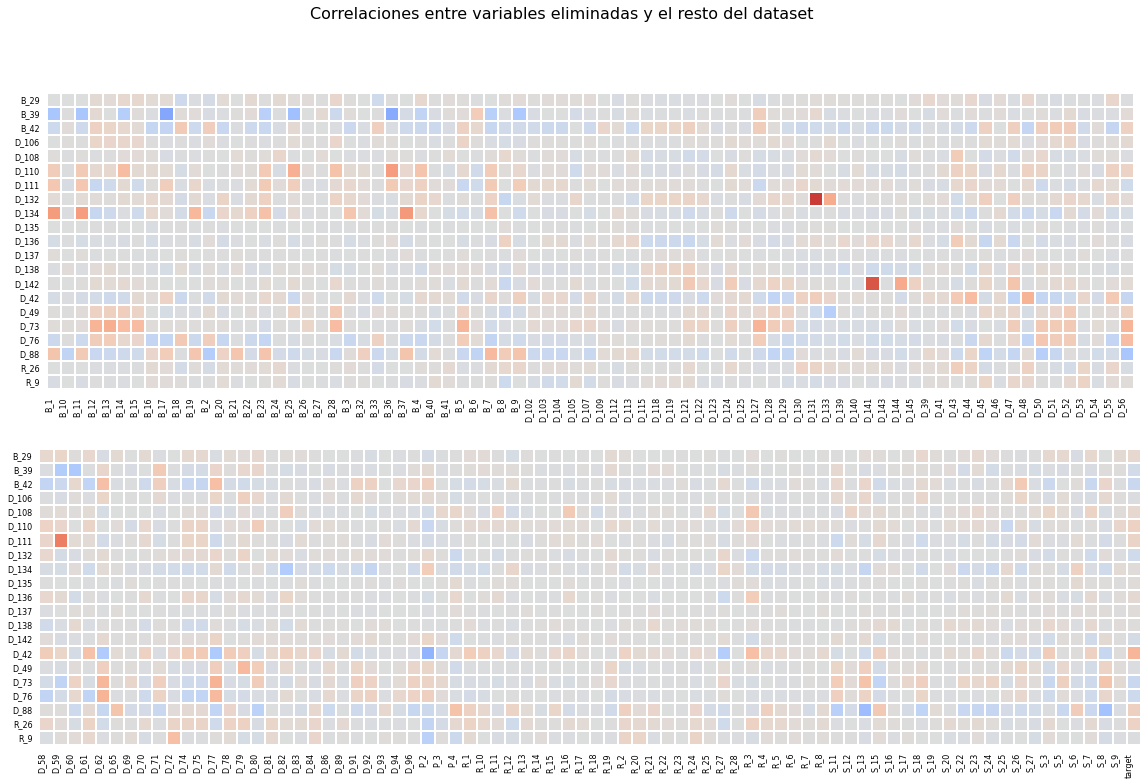

In [52]:
mid = int(len(corr.columns) / 2)
corr_a = corr[corr.columns[0:mid]]
corr_b = corr[corr.columns[mid:]]
fig, ax = plt.subplots(2, figsize=(32,12))
fig.suptitle('Correlaciones entre variables eliminadas y el resto del dataset', fontsize=16)
sns.heatmap(corr_a, vmin=-1, vmax=1, center=0, square=True, linewidth=0.01, 
            cmap='coolwarm', cbar=False, ax=ax[0])
ax[0].tick_params(left=False,bottom=False)
ax[0].set_xticklabels(ax[0].get_xticklabels(), horizontalalignment='right',fontsize=8)
ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=8)
sns.heatmap(corr_b, vmin=-1, vmax=1, center=0, square=True, linewidth=0.01, 
            cmap='coolwarm', cbar=False, ax=ax[1])
ax[1].tick_params(left=False,bottom=False)
ax[1].set_xticklabels(ax[1].get_xticklabels(), horizontalalignment='right',fontsize=8)
ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize=8)
fig.show()

Definimos un valor de correlación como threshold de 0.7 para aquellas que podemos borrar.

In [53]:
threshold = .5
delete_spectre = .7
corr_columns = [corr.columns[j] for i, j in zip(*np.where(np.abs(corr.values) >= delete_spectre))]
corr_elevadas = [f"{corr.index[i]} y {corr.columns[j]} = {corr.iloc[i][j]:.2f}" for i, j in zip(*np.where(np.abs(corr.values) >= threshold))]
print("\n" + f"Columnas a eliminar (corr > {delete_spectre}): " + ", ".join(corr_columns) + "\n")
print("Columnas con correlaciones elevadas: " + ", ".join(corr_elevadas))


Columnas a eliminar (corr > 0.7): D_131, D_141

Columnas con correlaciones elevadas: B_39 y B_17 = -0.55, B_39 y B_36 = -0.52, D_111 y D_59 = 0.62, D_132 y D_131 = 0.88, D_142 y D_141 = 0.78


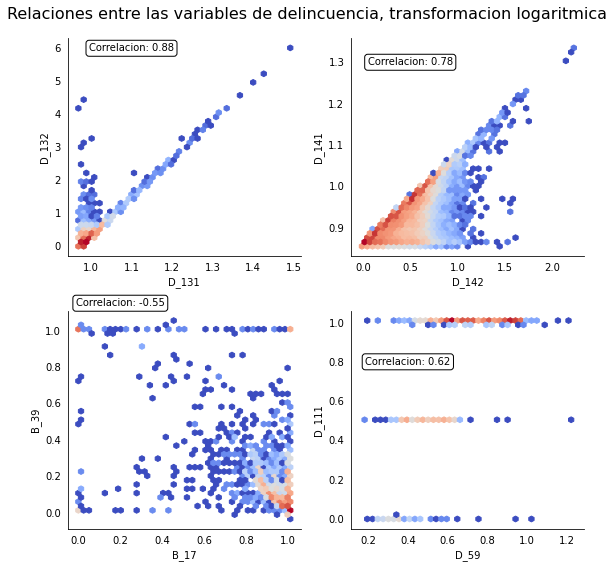

In [54]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
cols=[col for col in data_analysis.columns if (col.startswith(('B','D'))) & (col not in categorical_ignore_target)]
plot_df=data_analysis[cols]
fig.suptitle('Relaciones entre las variables de delincuencia, transformacion logaritmica',fontsize=16)
ax[0][0].hexbin(x='D_131', y='D_132', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[0][0].text(1.1,6, 'Correlacion: {:.2f}'.format(plot_df[['D_131','D_132']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[0][0].set(xlabel='D_131',ylabel='D_132')
ax[0][1].hexbin(x='D_142', y='D_141', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[0][1].text(0.5, 1.3, 'Correlacion: {:.2f}'.format(plot_df[['D_142','D_141']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[0][1].set(xlabel='D_142',ylabel='D_141')
ax[1][0].hexbin(x='B_17', y='B_39', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[1][0].text(0.2, 1.15, 'Correlacion: {:.2f}'.format(plot_df[['B_17','B_39']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[1][0].set(xlabel='B_17',ylabel='B_39')
ax[1][1].hexbin(x='D_59', y='D_111', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[1][1].text(0.4, 0.8, 'Correlacion: {:.2f}'.format(plot_df[['D_59','D_111']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[1][1].set(xlabel='D_59',ylabel='D_111')

for i in range(2):
    for j in range(2):
        ax[i][j].tick_params(left=False,bottom=False)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

In [55]:
data.drop(columns = corr_columns, inplace = True)

In [56]:
data

customer_ID         S_2  \
0       000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  2017-10-23   
1       000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-11-10   
2       0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...  2017-10-15   
3       0000f99513770170a1aba690daeeb8a96da4a39f11fc27...  2017-03-15   
4       00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...  2017-07-01   
...                                                   ...         ...   
276567  ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...  2018-02-23   
276568  ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...  2017-09-21   
276569  ffff9984b999fccb2b6127635ed0736dda94e544e67e02...  2018-02-06   
276570  ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...  2017-04-24   
276571  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2017-06-19   

             P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
0       0.606677  0.033809  0.025544  0.815019  0.000523  0.172446  0.003708   
1       0.407172  0.001548  0.106145  0.048557  0.001353  0.330037  0.009187   
2       1.005125  0.215301  0.099128  0.082039  0.005363  0.092882  0.001929   
3       0.400025  0.000278  0.954861  0.023890  0.003140       NaN  0.008421   
4       0.311111  0.592908  0.096867  0.040793  0.002294  0.460324  0.009938   
...          ...       ...       ...       ...       ...       ...       ...   
276567  0.812465  0.002464  0.016056  1.003230  0.007137  0.136428  0.000088   
276568  0.864945  0.036332  0.359523  0.041615  0.008703  0.194697  0.007207   
276569  0.786806  0.236684  0.016190  1.001367  0.008386  0.070241  0.000588   
276570  0.852883  0.005489  0.000281  0.813544  0.000149  0.368054  0.001709   
276571  1.005768  0.206469  0.029999  0.620975  0.008176  0.033445  0.003778   

             B_3  ...     D_129      B_41     D_130     D_133      R_28  \
0       0.000053  ...  1.000093  0.000436  0.002587  0.003671  0.005287   
1       0.223204  ...  0.003829  0.007094  0.004997  0.008582  0.001165   
2       0.158300  ...  1.000794  0.005223  0.005690  0.000064  0.007438   
3       1.175081  ...  0.006714  0.001734  0.005211  0.007364  0.007980   
4       0.223131  ...  1.005950  0.002352  0.001253  0.006729  0.000394   
...          ...  ...       ...       ...       ...       ...       ...   
276567  0.009943  ...  0.002862  0.003389  0.007511  0.005694  0.005480   
276568  0.269648  ...  1.003207  0.001808  1.004728  1.133691  0.006643   
276569  0.000675  ...  1.003515  0.005785  0.005804  0.002185  0.005860   
276570  0.070558  ...  0.007279  0.003274  1.007671  0.005967  0.005365   
276571  0.038097  ...  1.006736  0.006273  0.008792  0.000926  0.000449   

           D_139     D_140     D_143     D_144     D_145  
0       0.008022  0.004774  0.000654  0.001793  0.006356  
1       0.000510  0.001478  0.004614  0.007917  0.006711  
2       0.006687  0.007377  0.009990  0.002785  0.009664  
3       1.002518  0.001170  1.003923  0.008945  0.736632  
4       0.001164  0.001779  0.006252  0.008367  0.005460  
...          ...       ...       ...       ...       ...  
276567  0.009720  0.009944  0.007779  0.005021  0.005594  
276568  0.005813  0.002701  0.008592  0.009413  0.007067  
276569  0.006160  0.009230  0.009720  0.007795  0.006619  
276570  1.006073  0.006703  1.004450  0.007339  0.186192  
276571  0.007099  0.004032  0.009316  0.002273  0.002568  

[276572 rows x 165 columns]

Luedo de haber tratado las de > 80% y filtrado las que están muy correlacionadas, vemos qué variables quedaron con nulos:

In [57]:
fill_nulls=round((data.isna().sum()/data.shape[0]*100),2).sort_values(ascending=False)
fill_nulls=fill_nulls.to_frame().rename(columns={0:'Nulos (%)'})
fill_nulls.head(30)

Nulos (%)
D_53       73.93
D_82       73.46
B_17       56.80
D_50       56.72
D_105      54.59
D_56       53.98
S_9        53.04
D_77       45.45
D_43       30.12
S_27       25.34
D_46       22.01
S_7        18.46
S_3        18.46
D_62       13.76
D_48       13.03
D_61       10.83
P_3         5.46
D_44        4.97
D_78        4.97
D_68        3.92
D_64        3.91
D_83        3.53
D_69        3.53
D_55        3.41
D_114       3.23
D_117       3.23
D_116       3.23
D_113       3.23
D_124       3.23
D_123       3.23

De todas las variables la mayoría presenta una baja cantidad de nulos; para las que presentan un porcentaje importante ser verá de llenar esos nulos.

In [58]:
fill_nulls=fill_nulls[fill_nulls['Nulos (%)'] > 10]
fill_nulls

Nulos (%)
D_53       73.93
D_82       73.46
B_17       56.80
D_50       56.72
D_105      54.59
D_56       53.98
S_9        53.04
D_77       45.45
D_43       30.12
S_27       25.34
D_46       22.01
S_7        18.46
S_3        18.46
D_62       13.76
D_48       13.03
D_61       10.83

Vemos las medidas de resumen para esas columnas:

In [59]:
data[fill_nulls.index.values].describe().applymap(lambda x: f"{x:0.2f}")

D_53      D_82       B_17       D_50      D_105       D_56  \
count  72116.00  73410.00  119475.00  119694.00  125590.00  127282.00   
mean       0.08      0.46       0.71       0.17       0.37       0.20   
std        0.20      0.19       0.39       0.60       0.25       0.21   
min        0.00      0.00       0.00      -2.03      -0.02      -0.02   
25%        0.01      0.50       0.47       0.06       0.17       0.09   
50%        0.01      0.50       0.93       0.11       0.34       0.15   
75%        0.05      0.51       1.00       0.19       0.53       0.25   
max        7.90      3.00       1.01     106.91       4.17      10.87   

             S_9       D_77       D_43       S_27       D_46        S_7  \
count  129887.00  150883.00  193271.00  206480.00  215707.00  225509.00   
mean        0.07       0.26       0.15       0.28       0.48       0.22   
std         0.19       0.23       0.21       0.33       0.17       0.21   
min         0.00       0.00       0.00       0.00      -9.65      -0.34   
25%         0.01       0.08       0.04       0.01       0.42       0.09   
50%         0.02       0.21       0.09       0.29       0.46       0.14   
75%         0.05       0.38       0.19       0.45       0.52       0.30   
max         2.84      10.23       9.19       5.11       5.76       3.56   

             S_3       D_62       D_48       D_61  
count  225509.00  238526.00  240540.00  246614.00  
mean        0.23       0.19       0.38       0.43  
std         0.19       0.23       0.33       0.35  
min        -0.45      -0.00      -0.01      -0.01  
25%         0.13       0.03       0.08       0.09  
50%         0.16       0.10       0.29       0.37  
75%         0.26       0.29       0.67       0.77  
max         4.94      11.10       8.96      31.75

Vemos que la desviación estandar es baja para todas las variables (< 0.7) por lo que decidimos llenar los nulos de cada una con sus medianas.

In [60]:
data[fill_nulls.index.values] = data[fill_nulls.index.values].fillna(data[fill_nulls.index.values].median())

In [61]:
remain_nulls = round((data.isna().sum()/data.shape[0]*100),2).sort_values(ascending=False)
remain_nulls=remain_nulls.to_frame().rename(columns={0:'Nulos (%)'})
remain_nulls.head(30)

Nulos (%)
P_3         5.46
D_44        4.97
D_78        4.97
D_68        3.92
D_64        3.91
D_69        3.53
D_83        3.53
D_55        3.41
D_119       3.23
D_121       3.23
D_116       3.23
D_122       3.23
D_123       3.23
D_124       3.23
D_118       3.23
D_125       3.23
D_117       3.23
D_113       3.23
D_115       3.23
D_114       3.23
D_120       3.23
D_91        2.84
R_27        2.34
D_126       2.12
D_59        1.97
D_104       1.86
D_103       1.86
D_145       1.86
D_107       1.86
D_128       1.86

Vemos que como resultado de todo el análisis de las columans con nulos, las columnas que nos quedaron con nulos sin tratar representan un porcentaje muy bajo. Para cada modelo luego vamos a decidir qué hacer con estos nulos.

### Análisis de outliers

Comenzaremos el análisis graficando un boxplot para cada variable del dataset. Utilizaremos un boxplot ya que permite ver para todas las variables al mismo tiempo de forma práctica si hay valores atípicos.  
El boxplot permite realizar un análisis univariado de los datos para cada columna, resultando en posibles outliers moderados aquellos que se encuentran entre la caja (espacio entre el primer y tercer cuartil) y los bigotes (mínimo/máximo), y outliers severos aquellos que se encuentran más allá de los bigotes.

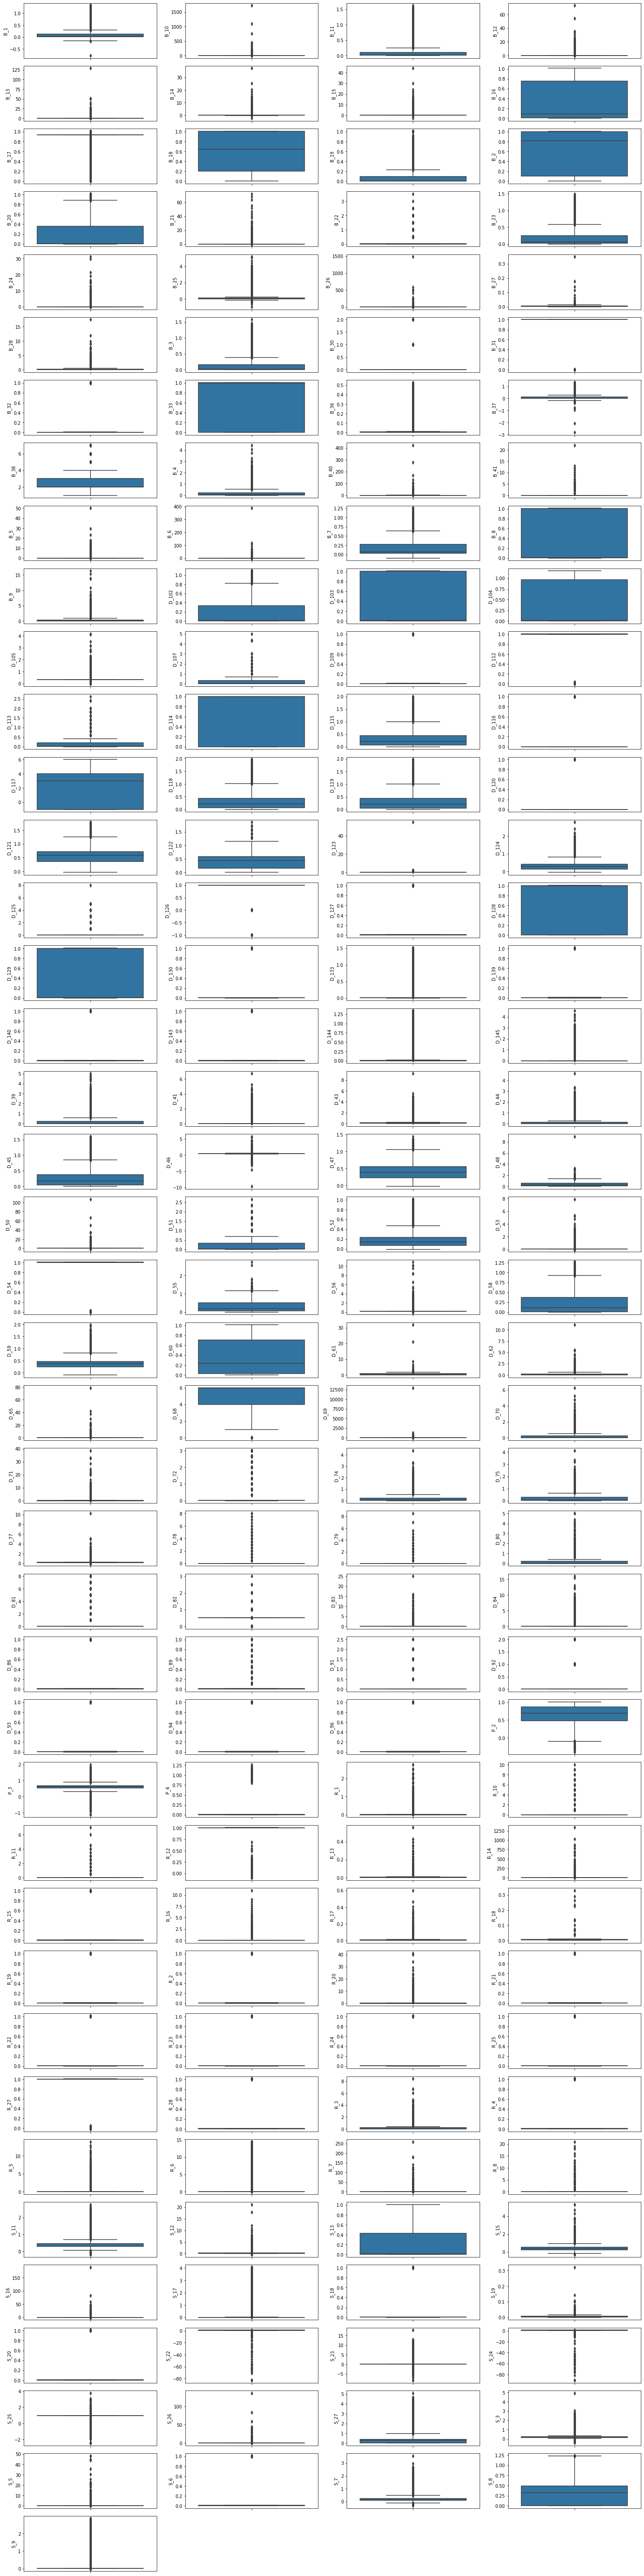

In [62]:
data_bp = data.select_dtypes(exclude=['object'])
plots_per_column = 4
total_rows = math.ceil(len(data_bp.columns) / plots_per_column)
fig, axes = plt.subplots(total_rows,plots_per_column, figsize=(20, 80)) # create figure and axes
row=0
col = list(range(0, plots_per_column)) * total_rows
data_bp_columns = sorted(data_bp.columns)
for i, column in enumerate(data_bp_columns):
    if (i!=0)&(i%plots_per_column==0):
        row+=1
        
    sns.boxplot(y=column, data=data_bp, ax=axes[row,col[i]])
    
for i in range(1, plots_per_column):
    axes[total_rows-1,i].set_visible(False)

plt.tight_layout()

Dado el problema planteado, en donde hay que predecir si un cliente pagará o no, creemos que no tiene sentido eliminar todos los outliers ya que son los que pueden aportar la información más importante. Por lo tanto analizaremos las variables que tengan mayor presencia de outliers. Haciendo zoom en este boxplot se puede ver que son: B_6, B_10, D_69, R_7, B_26, S_16, R_14, S_26 y B_40.


In [63]:
analisis_outliers = ['B_6', 'B_10', 'D_69', 'R_7', 'B_26', 'S_16', 'R_14', 'S_26', 'B_40']

Para seguir con el análisis univariado sobre cada una de las variables seleccionadas utilizaremos el método de la métrica Z-Score. Esta métrica se basa en cuan desviado está un dato de la media, asumiendo una distribución gaussiana, resultando los posibles outliers aquellos que den con módulo mayor a 3.

In [64]:
z_cols = []
for col in analisis_outliers:
    z_col = 'z_' + col
    media = np.mean(data[col])
    std = np.std(data[col])
    data[z_col] = (data[col] - media) / std
    z_cols.append(z_col)

Así quedan los resultados para cada variable de la métrica de Z-Score

In [65]:
data[z_cols]

z_B_6    z_B_10    z_D_69     z_R_7    z_B_26    z_S_16    z_R_14  \
0       0.045881  0.002110 -0.007064 -0.051334 -0.023516 -0.059911 -0.029912   
1      -0.113072 -0.043308 -0.007101 -0.050101 -0.024588 -0.056673 -0.030095   
2       0.030929  0.004367 -0.006825 -0.053262 -0.022160 -0.066641 -0.030876   
3      -0.138057 -0.044968 -0.007045 -0.054325 -0.023342 -0.064952 -0.030349   
4      -0.140423 -0.045752 -0.006747 -0.049994 -0.022499 -0.063472 -0.030331   
...          ...       ...       ...       ...       ...       ...       ...   
276567  0.179289  0.043530 -0.007030 -0.053671 -0.024539 -0.056894 -0.030681   
276568 -0.135085 -0.038631 -0.006930 -0.054138 -0.024423 -0.059473 -0.030207   
276569  0.109074  0.011878 -0.007078 -0.054037 -0.023593 -0.056510 -0.030488   
276570 -0.121765 -0.038973 -0.006907 -0.054350 -0.023890 -0.068330 -0.030372   
276571 -0.064446 -0.005716 -0.007115 -0.053326 -0.023887 -0.068654 -0.031145   

          z_S_26    z_B_40  
0      -0.116778 -0.146713  
1      -0.118642 -0.092426  
2      -0.120219 -0.125124  
3      -0.117559  0.104363  
4      -0.121319  0.069073  
...          ...       ...  
276567  0.143394 -0.127830  
276568 -0.114444  0.054166  
276569 -0.124913 -0.106550  
276570 -0.117190  0.200007  
276571 -0.128454 -0.133306  

[276572 rows x 9 columns]

A continuación verificamos cuántos registros tienen valores mayores a 3 (en módulo)

<AxesSubplot:ylabel='B_6'>

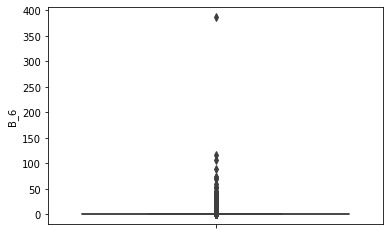

In [66]:
sns.boxplot(y=data['B_6'])

In [67]:
data[(abs(data['z_B_6']) >= 3)][['B_6', 'z_B_6']].sort_values(by='z_B_6', ascending=False)

B_6       z_B_6
219724  387.336513  381.665642
240800  117.375439  115.553693
59532   105.802764  104.146022
272736   89.737887   88.310199
23018    74.129644   72.924499
...            ...         ...
186471    3.211478    3.017490
247021    3.200989    3.007151
157604    3.198985    3.005175
136340    3.196889    3.003109
23795     3.195245    3.001488

[580 rows x 2 columns]

Dado que los 580 registros representan sólo el 0.21% del total decidimos eliminarlos.

In [68]:
data.drop(data[(abs(data['z_B_6']) >= 3)].index, inplace=True)

<AxesSubplot:ylabel='B_10'>

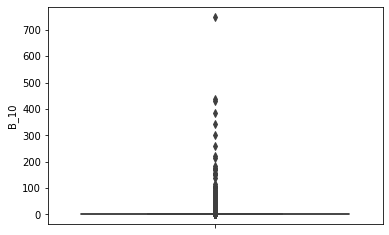

In [69]:
sns.boxplot(y=data['B_10'])

In [70]:
data[(abs(data['z_B_10']) >= 3)][['B_10', 'z_B_10']].sort_values(by='z_B_10', ascending=False)

B_10      z_B_10
48110   749.411944  156.193960
136025  439.424532   91.565373
271124  429.588381   89.514656
269129  382.624840   79.723332
59352   344.555186   71.786274
...            ...         ...
199928   15.293140    3.139162
102367   15.088442    3.096485
29664    14.799669    3.036280
228695   14.774776    3.031090
164417   14.733890    3.022565

[172 rows x 2 columns]

Dado que los 172 registros representan sólo el 0.062% del total decidimos eliminarlos.

In [71]:
data.drop(data[(abs(data['z_B_10']) >= 3)].index, inplace=True)

<AxesSubplot:ylabel='D_69'>

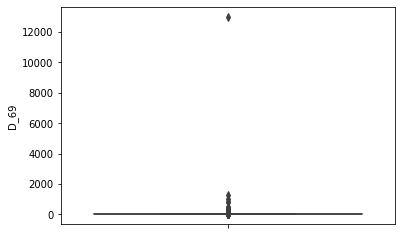

In [72]:
sns.boxplot(y=data['D_69'])

In [73]:
data[(abs(data['z_D_69']) >= 3)][['D_69', 'z_D_69']].sort_values(by='z_D_69', ascending=False)

D_69      z_D_69
211812  13000.906869  506.672033
107041   1289.780503   50.258971
75524    1000.678720   38.991922
276394    805.157387   31.371947
276395    805.151227   31.371707
...              ...         ...
259959     86.622636    3.368779
88419      84.844600    3.299484
21730      84.688069    3.293383
241050     79.246237    3.081301
206890     78.493842    3.051978

[73 rows x 2 columns]

Dado que los 73 registros representan sólo el 0.026% del total decidimos eliminarlos.

In [74]:
data.drop(data[(abs(data['z_D_69']) >= 3)].index, inplace=True)

<AxesSubplot:ylabel='R_7'>

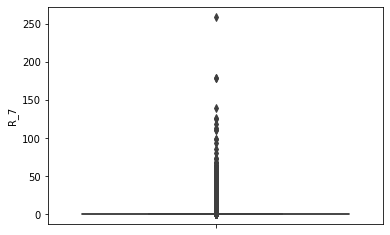

In [75]:
sns.boxplot(y=data['R_7'])

In [76]:
data[(abs(data['z_R_7']) >= 3)][['R_7', 'z_R_7']].sort_values(by='z_R_7', ascending=False)

R_7       z_R_7
45915   259.494569  159.405630
211530  179.033734  109.961819
211531  179.025693  109.956878
107375  139.893354   85.909750
189718  126.114004   77.442232
...            ...         ...
214794    5.041961    3.042517
37049     4.984868    3.007433
148743    4.983074    3.006331
71528     4.982029    3.005689
261527    4.977821    3.003102

[918 rows x 2 columns]

Dado que los 918 registros representan sólo el 0.332% del total decidimos eliminarlos.

In [77]:
data.drop(data[(abs(data['z_R_7']) >= 3)].index, inplace=True)

<AxesSubplot:ylabel='B_26'>

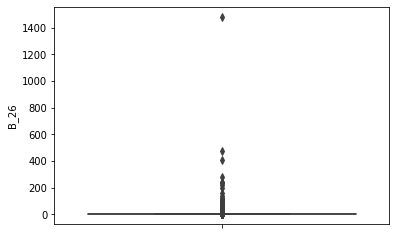

In [78]:
sns.boxplot(y=data['B_26'])

In [79]:
data[(abs(data['z_B_26']) >= 3)][['B_26', 'z_B_26']].sort_values(by='z_B_26', ascending=False)

B_26      z_B_26
44524   1481.761715  392.318672
254448   475.874497  125.978195
245684   409.243628  108.335564
151843   282.666460   74.820252
119002   243.994559   64.580643
...             ...         ...
96368     11.539687    3.030858
185618    11.521996    3.026174
121906    11.504659    3.021583
181068    11.468305    3.011958
271874    11.465261    3.011152

[370 rows x 2 columns]

Dado que los 370 registros representan sólo el 0.134% del total decidimos eliminarlos.

In [80]:
data.drop(data[(abs(data['z_B_26']) >= 3)].index, inplace=True)

<AxesSubplot:ylabel='S_16'>

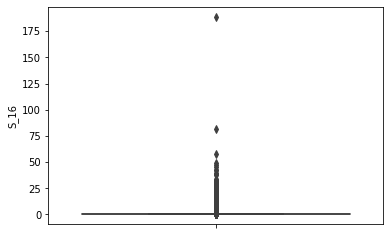

In [81]:
sns.boxplot(y=data['S_16'])

In [82]:
data[(abs(data['z_S_16']) >= 3)][['S_16', 'z_S_16']].sort_values(by='z_S_16', ascending=False)

S_16      z_S_16
162634  188.743609  264.181412
206650   81.917957  114.620254
264811   57.882986   80.970114
13452    49.151487   68.745587
92294    47.348900   66.221877
...            ...         ...
244558    2.206761    3.020666
36348     2.203596    3.016235
243644    2.195938    3.005513
192913    2.195909    3.005472
91047     2.195889    3.005445

[1475 rows x 2 columns]

Dado que los 1475 registros representan sólo el 0.533% del total decidimos eliminarlos.

In [83]:
data.drop(data[(abs(data['z_S_16']) >= 3)].index, inplace=True)

<AxesSubplot:ylabel='R_14'>

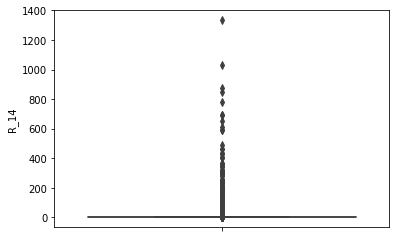

In [84]:
sns.boxplot(y=data['R_14'])

In [85]:
data[abs(data['z_R_14']) >= 3][['R_14', 'z_R_14']].sort_values(by='z_R_14', ascending=False)

R_14      z_R_14
259853  1337.046317  181.781781
107376  1032.126253  140.318438
99891    876.832232  119.201398
54833    848.555242  115.356264
227064   777.821777  105.737854
...             ...         ...
79204     22.763181    3.064212
151122    22.637305    3.047095
149914    22.423022    3.017956
252930    22.408051    3.015921
13465     22.370180    3.010771

[432 rows x 2 columns]

Dado que los 432 registros representan sólo el 0.156% del total decidimos eliminarlos.

<AxesSubplot:ylabel='S_26'>

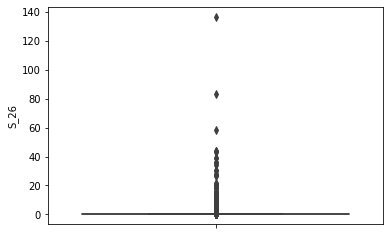

In [86]:
sns.boxplot(y=data['S_26'])

In [87]:
data[abs(data['z_S_26']) >= 3][['S_26', 'z_S_26']].sort_values(by='z_S_26', ascending=False)

S_26      z_S_26
20945   136.665991  263.396162
273692   83.028171  159.969295
259811   58.381488  112.444447
20946    43.784548   84.297969
229845   43.784445   84.297770
...            ...         ...
17843     1.626176    3.006293
89410     1.625989    3.005932
93411     1.625887    3.005735
62207     1.624948    3.003924
272004    1.624303    3.002680

[1235 rows x 2 columns]

Dado que los 1235 registros representan sólo el 0.447% del total decidimos eliminarlos.

In [88]:
data.drop(data[abs(data['z_S_26']) >= 3].index, inplace=True)

<AxesSubplot:ylabel='B_40'>

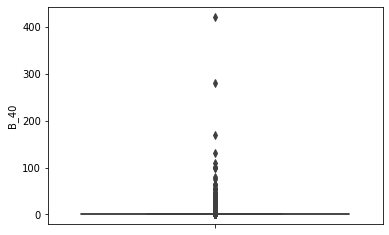

In [89]:
sns.boxplot(y=data['B_40'])

In [90]:
data[abs(data['z_B_40']) >= 3][['B_40', 'z_B_40']].sort_values(by='z_B_40', ascending=False)

B_40      z_B_40
17844   421.379003  331.913212
46931   279.341430  219.983125
261444  168.345529  132.514854
238633  131.779619  103.699764
259876  109.897375   86.455866
...            ...         ...
3564      4.029711    3.028808
154334    4.029302    3.028486
104070    4.005628    3.009830
263526    4.002186    3.007118
244745    3.995398    3.001768

[259 rows x 2 columns]

Dado que los 259 registros representan sólo el 0.094% del total decidimos eliminarlos.

In [91]:
data.drop(data[abs(data['z_B_40']) >= 3].index, inplace=True)

Vemos cómo quedó el dataset finalmente

In [92]:
data

customer_ID         S_2  \
0       000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  2017-10-23   
1       000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-11-10   
2       0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...  2017-10-15   
3       0000f99513770170a1aba690daeeb8a96da4a39f11fc27...  2017-03-15   
4       00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...  2017-07-01   
...                                                   ...         ...   
276567  ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...  2018-02-23   
276568  ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...  2017-09-21   
276569  ffff9984b999fccb2b6127635ed0736dda94e544e67e02...  2018-02-06   
276570  ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...  2017-04-24   
276571  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2017-06-19   

             P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
0       0.606677  0.033809  0.025544  0.815019  0.000523  0.172446  0.003708   
1       0.407172  0.001548  0.106145  0.048557  0.001353  0.330037  0.009187   
2       1.005125  0.215301  0.099128  0.082039  0.005363  0.092882  0.001929   
3       0.400025  0.000278  0.954861  0.023890  0.003140  0.164106  0.008421   
4       0.311111  0.592908  0.096867  0.040793  0.002294  0.460324  0.009938   
...          ...       ...       ...       ...       ...       ...       ...   
276567  0.812465  0.002464  0.016056  1.003230  0.007137  0.136428  0.000088   
276568  0.864945  0.036332  0.359523  0.041615  0.008703  0.194697  0.007207   
276569  0.786806  0.236684  0.016190  1.001367  0.008386  0.070241  0.000588   
276570  0.852883  0.005489  0.000281  0.813544  0.000149  0.368054  0.001709   
276571  1.005768  0.206469  0.029999  0.620975  0.008176  0.033445  0.003778   

             B_3  ...     D_145     z_B_6    z_B_10    z_D_69     z_R_7  \
0       0.000053  ...  0.006356  0.045881  0.002110 -0.007064 -0.051334   
1       0.223204  ...  0.006711 -0.113072 -0.043308 -0.007101 -0.050101   
2       0.158300  ...  0.009664  0.030929  0.004367 -0.006825 -0.053262   
3       1.175081  ...  0.736632 -0.138057 -0.044968 -0.007045 -0.054325   
4       0.223131  ...  0.005460 -0.140423 -0.045752 -0.006747 -0.049994   
...          ...  ...       ...       ...       ...       ...       ...   
276567  0.009943  ...  0.005594  0.179289  0.043530 -0.007030 -0.053671   
276568  0.269648  ...  0.007067 -0.135085 -0.038631 -0.006930 -0.054138   
276569  0.000675  ...  0.006619  0.109074  0.011878 -0.007078 -0.054037   
276570  0.070558  ...  0.186192 -0.121765 -0.038973 -0.006907 -0.054350   
276571  0.038097  ...  0.002568 -0.064446 -0.005716 -0.007115 -0.053326   

          z_B_26    z_S_16    z_R_14    z_S_26    z_B_40  
0      -0.023516 -0.059911 -0.029912 -0.116778 -0.146713  
1      -0.024588 -0.056673 -0.030095 -0.118642 -0.092426  
2      -0.022160 -0.066641 -0.030876 -0.120219 -0.125124  
3      -0.023342 -0.064952 -0.030349 -0.117559  0.104363  
4      -0.022499 -0.063472 -0.030331 -0.121319  0.069073  
...          ...       ...       ...       ...       ...  
276567 -0.024539 -0.056894 -0.030681  0.143394 -0.127830  
276568 -0.024423 -0.059473 -0.030207 -0.114444  0.054166  
276569 -0.023593 -0.056510 -0.030488 -0.124913 -0.106550  
276570 -0.023890 -0.068330 -0.030372 -0.117190  0.200007  
276571 -0.023887 -0.068654 -0.031145 -0.128454 -0.133306  

[271490 rows x 174 columns]

De los 276572 registros originales quedaron 271490, lo que equivale al 98.16% del dataset. 

Eliminamos las columnas que agregamos para evaluar los outliers.

In [93]:
data.drop(columns=z_cols, inplace=True)

In [94]:
data

customer_ID         S_2  \
0       000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  2017-10-23   
1       000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-11-10   
2       0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...  2017-10-15   
3       0000f99513770170a1aba690daeeb8a96da4a39f11fc27...  2017-03-15   
4       00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...  2017-07-01   
...                                                   ...         ...   
276567  ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...  2018-02-23   
276568  ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...  2017-09-21   
276569  ffff9984b999fccb2b6127635ed0736dda94e544e67e02...  2018-02-06   
276570  ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...  2017-04-24   
276571  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2017-06-19   

             P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
0       0.606677  0.033809  0.025544  0.815019  0.000523  0.172446  0.003708   
1       0.407172  0.001548  0.106145  0.048557  0.001353  0.330037  0.009187   
2       1.005125  0.215301  0.099128  0.082039  0.005363  0.092882  0.001929   
3       0.400025  0.000278  0.954861  0.023890  0.003140  0.164106  0.008421   
4       0.311111  0.592908  0.096867  0.040793  0.002294  0.460324  0.009938   
...          ...       ...       ...       ...       ...       ...       ...   
276567  0.812465  0.002464  0.016056  1.003230  0.007137  0.136428  0.000088   
276568  0.864945  0.036332  0.359523  0.041615  0.008703  0.194697  0.007207   
276569  0.786806  0.236684  0.016190  1.001367  0.008386  0.070241  0.000588   
276570  0.852883  0.005489  0.000281  0.813544  0.000149  0.368054  0.001709   
276571  1.005768  0.206469  0.029999  0.620975  0.008176  0.033445  0.003778   

             B_3  ...     D_129      B_41     D_130     D_133      R_28  \
0       0.000053  ...  1.000093  0.000436  0.002587  0.003671  0.005287   
1       0.223204  ...  0.003829  0.007094  0.004997  0.008582  0.001165   
2       0.158300  ...  1.000794  0.005223  0.005690  0.000064  0.007438   
3       1.175081  ...  0.006714  0.001734  0.005211  0.007364  0.007980   
4       0.223131  ...  1.005950  0.002352  0.001253  0.006729  0.000394   
...          ...  ...       ...       ...       ...       ...       ...   
276567  0.009943  ...  0.002862  0.003389  0.007511  0.005694  0.005480   
276568  0.269648  ...  1.003207  0.001808  1.004728  1.133691  0.006643   
276569  0.000675  ...  1.003515  0.005785  0.005804  0.002185  0.005860   
276570  0.070558  ...  0.007279  0.003274  1.007671  0.005967  0.005365   
276571  0.038097  ...  1.006736  0.006273  0.008792  0.000926  0.000449   

           D_139     D_140     D_143     D_144     D_145  
0       0.008022  0.004774  0.000654  0.001793  0.006356  
1       0.000510  0.001478  0.004614  0.007917  0.006711  
2       0.006687  0.007377  0.009990  0.002785  0.009664  
3       1.002518  0.001170  1.003923  0.008945  0.736632  
4       0.001164  0.001779  0.006252  0.008367  0.005460  
...          ...       ...       ...       ...       ...  
276567  0.009720  0.009944  0.007779  0.005021  0.005594  
276568  0.005813  0.002701  0.008592  0.009413  0.007067  
276569  0.006160  0.009230  0.009720  0.007795  0.006619  
276570  1.006073  0.006703  1.004450  0.007339  0.186192  
276571  0.007099  0.004032  0.009316  0.002273  0.002568  

[271490 rows x 165 columns]

### Columnas a agregar

Revisamos si hay datos que aporten información como para crear columnas nuevas.

De las columnas que estan representadas en forma de texto, nos fijamos qué información presentan:

In [95]:
cols_txt = data.select_dtypes(include=['object']).columns
cols_txt

Index(['customer_ID', 'S_2', 'D_63', 'D_64'], dtype='object')

In [96]:
data[cols_txt]

customer_ID         S_2 D_63  \
0       000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  2017-10-23   CO   
1       000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-11-10   CO   
2       0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...  2017-10-15   CO   
3       0000f99513770170a1aba690daeeb8a96da4a39f11fc27...  2017-03-15   CO   
4       00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...  2017-07-01   CO   
...                                                   ...         ...  ...   
276567  ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...  2018-02-23   CO   
276568  ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...  2017-09-21   CO   
276569  ffff9984b999fccb2b6127635ed0736dda94e544e67e02...  2018-02-06   CO   
276570  ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...  2017-04-24   CO   
276571  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2017-06-19   CL   

       D_64  
0         O  
1         R  
2         R  
3         U  
4         O  
...     ...  
276567    U  
276568    R  
276569    U  
276570    U  
276571    O  

[271490 rows x 4 columns]

Customer ID es el identificador del deudor al cual queremos clasificar. S_2 representa una fecha la cual podemos dividir en 3 variables numéricas (año, mes y día), mientras que D_63 y D_64 son strings que representan diferentes categorías.

Crearemos una columna para el año, el mes y el día extraidos de la columna S_2

In [97]:
data['S_2'] = pd.to_datetime(data['S_2']) 
data['S_2_Year'] = data['S_2'].dt.year
data['S_2_Month'] = data['S_2'].dt.month
data['S_2_Day'] = data['S_2'].dt.day

In [98]:
data[['S_2', 'S_2_Year', 'S_2_Month', 'S_2_Day']]

S_2  S_2_Year  S_2_Month  S_2_Day
0      2017-10-23      2017         10       23
1      2017-11-10      2017         11       10
2      2017-10-15      2017         10       15
3      2017-03-15      2017          3       15
4      2017-07-01      2017          7        1
...           ...       ...        ...      ...
276567 2018-02-23      2018          2       23
276568 2017-09-21      2017          9       21
276569 2018-02-06      2018          2        6
276570 2017-04-24      2017          4       24
276571 2017-06-19      2017          6       19

[271490 rows x 4 columns]

Borramos S_2 asi no duplicamos informacion

In [99]:
data.drop(columns=['S_2'], inplace=True)

### Reducción de dimensionalidad

In [100]:
data.shape

(271490, 167)

Dado que hay muchas columnas vemos si es posible reducir la cantidad de columnas para mejorar los tiempos de ejecución. Para ello utilizaremos PCA (Análisis de Componentes Principales).

In [101]:
from sklearn.decomposition import PCA

Dado que sólo funciona con variables numéricas filtraremos las columnas que cumplan con este requisito

In [102]:
cols = data.select_dtypes(include=['number']).columns
cols = [x for x in cols if (x not in ['S_2_Year', 'S_2_Month', 'S_2_Day'])]
not_cols = [x for x in data.columns if (x not in cols)]
not_cols

['customer_ID', 'D_63', 'D_64', 'S_2_Year', 'S_2_Month', 'S_2_Day']

In [103]:
data_parte_a = data[not_cols].copy()
data_parte_b = data[cols].copy()

In [104]:
nulos=round((data_parte_b.isna().sum()/data_parte_b.shape[0]*100),5).sort_values(ascending=False)
nulos=nulos.to_frame().rename(columns={0:'Nulos (%)'})
nulos = nulos[nulos['Nulos (%)'] > 0]
nulos

Nulos (%)
P_3     5.43003
D_78    4.88637
D_44    4.88637
D_68    3.90364
D_69    3.51578
...         ...
B_6     0.00405
R_20    0.00147
B_37    0.00111
R_12    0.00111
B_40    0.00111

[78 rows x 1 columns]

Dado que PCA no permite las variables con nulos, vamos a llenar los nulos con la mediana de cada variable dado que los porcentajes son chicos y no se modificará de una forma importante su distribución.

In [105]:
for col in nulos.index.values:
    data_parte_b[col] = data_parte_b[col].fillna(data_parte_b[col].median())

In [106]:
tipos_de_variables = "DSPBR"
for tipo in tipos_de_variables:
    var = tipo + '_'
    print(f"{var}: {len(data_parte_b.filter(regex=var).columns)}")

D_: 74
S_: 21
P_: 3
B_: 37
R_: 26


In [107]:
data_d = data_parte_b.filter(regex="D_").copy()
data_s = data_parte_b.filter(regex="S_").copy()
data_b = data_parte_b.filter(regex="B_").copy()
data_r = data_parte_b.filter(regex="R_").copy()
data_p = data_parte_b.filter(regex="P_").copy()

Al momento de reducir la dimensionalidad, buscaremos quedarnos con las variables que cubran el 97.5% de la varianza ya que de quedarnos con el 95% podríamos perder valores _"borde"_ que aporten buena información para este problema puntual.

Como las variables respectivas a la delincuencia son las más abundantes, empezaremos por reducir esas variables.

In [108]:
pca_data = PCA()
pca_data.fit(data_d)

PCA()

Calculamos la cantidad de componentes principales a utilizar

In [109]:
var_cumu = np.cumsum(pca_data.explained_variance_ratio_) * 100

In [110]:
k = np.argmax(var_cumu > 97.5)
print("El numero minimo de componentes para explicar el 97.5% de la varianza es: " + str(k))

El numero minimo de componentes para explicar el 97.5% de la varianza es: 41


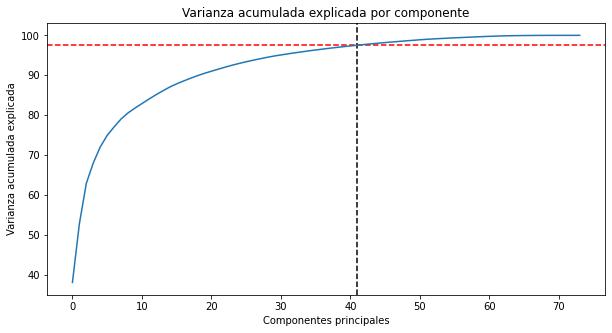

In [111]:
plt.figure(figsize=[10, 5])
plt.title('Varianza acumulada explicada por componente')
plt.ylabel('Varianza acumulada explicada')
plt.xlabel('Componentes principales')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=97.5, color="r", linestyle="--")
ax = plt.plot(var_cumu)
plt.show()

Continuamos con la cantidad de componentes principales que nos dan el 97.5% de variabilidad explicada

In [112]:
pca = PCA(n_components=k)
pca_transform=pca.fit_transform(data_d)

In [113]:
columnas = ["D_PCA_" + f"{i}" for i in range(41)]
pca_d = pd.DataFrame(data = pca_transform, columns=columnas)

In [114]:
pca_d

D_PCA_0   D_PCA_1   D_PCA_2   D_PCA_3   D_PCA_4   D_PCA_5   D_PCA_6  \
0       3.512077  2.147760 -0.115097 -0.728047  1.170597  0.580236 -0.035577   
1      -0.711851  3.343450 -0.116653 -0.204407  0.045536 -1.019297 -0.289376   
2       3.706460  0.217377 -0.099013 -0.547941  0.808607  0.525048  0.017672   
3      -3.599161  1.908912 -0.083525 -0.345060 -0.926002  0.697398  0.772281   
4      -0.537902  1.895270 -0.027416  1.072091  0.688459  0.663471 -0.608580   
...          ...       ...       ...       ...       ...       ...       ...   
271485  1.736775 -0.601856 -0.078533 -0.001314 -0.159617 -1.554380 -0.120482   
271486  0.754667 -1.075893 -0.028335  1.242060  0.395901  0.070466 -0.342535   
271487 -3.277594 -0.469541 -0.087997  0.445730  1.202177 -0.265703 -0.120662   
271488 -0.513368  1.279014 -0.059314  0.677924 -0.483670 -0.659549  0.701744   
271489  0.723208  0.026641 -0.111625 -0.683247  1.062877  0.437804  0.096534   

         D_PCA_7   D_PCA_8   D_PCA_9  ...  D_PCA_31  D_PCA_32  D_PCA_33  \
0      -0.109709 -0.007278  0.143178  ... -0.107579 -0.185263  0.002166   
1       0.326386 -0.120815 -0.101297  ... -0.085694  0.000833  0.073747   
2       0.025715 -0.105066 -0.077900  ... -0.033906 -0.232342  0.032191   
3      -0.701642 -0.296350 -0.296302  ... -0.145414  0.303082  0.057322   
4       0.013000 -0.361422 -0.417295  ... -0.064278 -0.043249  0.044803   
...          ...       ...       ...  ...       ...       ...       ...   
271485 -0.484693  0.465823  0.488069  ...  0.727695  0.339288 -0.093637   
271486  0.048960 -0.444382  0.629068  ... -0.159749 -0.349902 -0.485239   
271487 -0.048273 -0.038576 -0.166645  ... -0.103231 -0.309151 -0.003085   
271488 -0.899443 -0.366823  0.299984  ...  0.064506  0.133251  0.358021   
271489 -0.071972  0.162761  0.208957  ...  0.014214 -0.052738  0.027125   

        D_PCA_34  D_PCA_35  D_PCA_36  D_PCA_37  D_PCA_38  D_PCA_39  D_PCA_40  
0       0.087153 -0.015335 -0.045893  0.029117 -0.044710 -0.035139 -0.031207  
1       0.294162  0.001695 -0.023798 -0.083588  0.033998 -0.094706 -0.018759  
2      -0.012240  0.025662 -0.102506  0.044860 -0.111014 -0.000610 -0.072354  
3      -0.046911  0.155046  0.141272  0.208430  0.090564 -0.237383  0.136391  
4       0.011896  0.081898 -0.050944 -0.078643  0.005494 -0.247815  0.060408  
...          ...       ...       ...       ...       ...       ...       ...  
271485  0.048283 -0.063658  0.487956 -0.410983 -0.419130 -0.042740  0.226956  
271486  0.003033  0.119688 -0.155181 -0.002429  0.001849 -0.119114  0.059595  
271487 -0.022191  0.052629 -0.040740 -0.005198  0.076132 -0.101550  0.045214  
271488 -0.005177  0.019777  0.078458  0.088859  0.096887 -0.068268  0.063225  
271489  0.310790 -0.033111 -0.194236  0.059916 -0.200662 -0.011455 -0.023756  

[271490 rows x 41 columns]

Repetimos el proceso ahora para las variables respectivas al gasto

In [115]:
pca_data = PCA()
pca_data.fit(data_s)

PCA()

Calculamos la cantidad de componentes principales a utilizar

In [116]:
var_cumu = np.cumsum(pca_data.explained_variance_ratio_) * 100

k = np.argmax(var_cumu > 97.5)
print("El numero minimo de componentes para explicar el 97.5% de la varianza es: " + str(k))

El numero minimo de componentes para explicar el 97.5% de la varianza es: 14


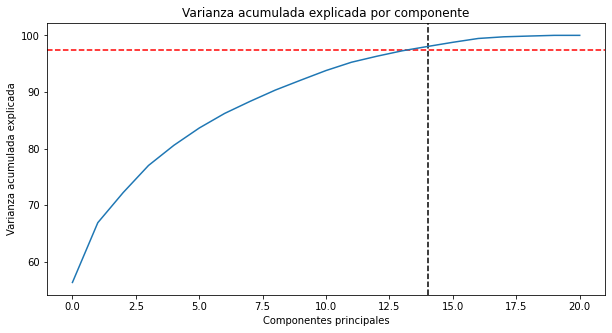

In [117]:
plt.figure(figsize=[10, 5])
plt.title('Varianza acumulada explicada por componente')
plt.ylabel('Varianza acumulada explicada')
plt.xlabel('Componentes principales')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=97.5, color="r", linestyle="--")
ax = plt.plot(var_cumu)
plt.show()

Continuamos con la cantidad de componentes principales que nos dan el 97.5% de variabilidad explicada

In [118]:
pca = PCA(n_components=k)
pca_transform=pca.fit_transform(data_s)

columnas = ["S_PCA_" + f"{i}" for i in range(14)]
pca_s = pd.DataFrame(data = pca_transform, columns=columnas)

In [119]:
pca_s

S_PCA_0   S_PCA_1   S_PCA_2   S_PCA_3   S_PCA_4   S_PCA_5   S_PCA_6  \
0      -0.322646  0.121100 -0.040918  0.159669 -0.297275 -0.118251 -0.073895   
1      -0.343258  0.151889 -0.246111 -0.132950  0.084421 -0.015211  0.068102   
2      -0.327280  0.357054  0.018832 -0.297103  0.294263  0.039617  0.021564   
3       0.882836 -0.740451 -1.272519  1.580379 -0.530208  9.522516 -1.364415   
4      -0.342422 -0.055140 -0.619010  0.037618  0.068917  0.247668 -0.022324   
...          ...       ...       ...       ...       ...       ...       ...   
271485 -0.336140  0.291653  0.113469 -0.049982 -0.176694 -0.075071 -0.134720   
271486 -0.219085 -0.208260 -0.354923 -0.023415 -0.034875 -0.157905 -0.105974   
271487 -0.244711  0.105940 -0.066681 -0.214727  0.053784 -0.090187 -0.182586   
271488  0.809275 -0.065478 -0.565226 -0.004682  0.054364 -0.133939  0.013383   
271489 -0.327032  0.167784 -0.110163 -0.254677  0.419552 -0.046555 -0.048046   

         S_PCA_7   S_PCA_8   S_PCA_9  S_PCA_10  S_PCA_11  S_PCA_12  S_PCA_13  
0       0.118861 -0.019898  0.091892  0.219482  0.233978  0.033862 -0.058578  
1       0.229876 -0.004479 -0.175236 -0.103205 -0.139459  0.142473  0.085475  
2       0.059032 -0.011466 -0.091042 -0.071112  0.018814  0.129982  0.037141  
3      -1.210628 -0.126110 -0.755439  1.209601  0.304393  0.010998 -0.327223  
4       0.067996  0.047667  0.546373 -0.440663 -0.376137  0.043392  0.089923  
...          ...       ...       ...       ...       ...       ...       ...  
271485 -0.163016 -0.000631  0.009885  0.058845  0.072008 -0.057631 -0.094030  
271486 -0.131226  0.001886 -0.041337  0.129148  0.193450  0.020876  0.005970  
271487 -0.419488  0.024626 -0.102696 -0.058881 -0.012247  0.122498  0.139805  
271488  0.097178 -0.098806 -0.113041  0.055313 -0.034451  0.004038 -0.015225  
271489 -0.253329  0.022928  0.047230  0.158827 -0.180333  0.013845  0.053125  

[271490 rows x 14 columns]

Repetimos el proceso ahora para las variables respectivas al balance

In [120]:
pca_data = PCA()
pca_data.fit(data_b)

PCA()

Calculamos la cantidad de componentes principales a utilizar

In [121]:
var_cumu = np.cumsum(pca_data.explained_variance_ratio_) * 100

k = np.argmax(var_cumu > 97.5)
print("El numero minimo de componentes para explicar el 97.5% de la varianza es: " + str(k))

El numero minimo de componentes para explicar el 97.5% de la varianza es: 19


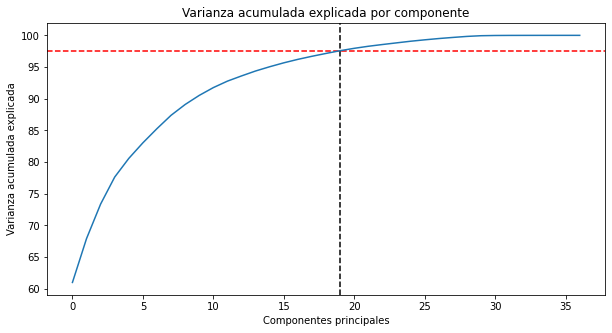

In [122]:
plt.figure(figsize=[10, 5])
plt.title('Varianza acumulada explicada por componente')
plt.ylabel('Varianza acumulada explicada')
plt.xlabel('Componentes principales')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=97.5, color="r", linestyle="--")
ax = plt.plot(var_cumu)
plt.show()

Continuamos con la cantidad de componentes principales que nos dan el 95% de variabilidad explicada

In [123]:
pca = PCA(n_components=k)
pca_transform=pca.fit_transform(data_b)

columnas = ["B_PCA_" + f"{i}" for i in range(19)]
pca_b = pd.DataFrame(data = pca_transform, columns=columnas)

In [124]:
pca_b

B_PCA_0   B_PCA_1   B_PCA_2   B_PCA_3   B_PCA_4   B_PCA_5   B_PCA_6  \
0      -0.999580  0.267570 -0.388935  0.492346 -0.090279  0.053106 -0.020612   
1       2.687739 -0.044771 -0.548199  0.389185 -0.428496  0.482343  0.180357   
2       0.518587 -0.266272  0.152821 -0.450803  0.548161 -0.132036  0.762756   
3       3.287702 -0.922843 -0.149452  0.111397 -0.912164  0.423614 -0.183277   
4       1.802205 -0.410069 -0.433738  0.306676 -0.173371  0.018945 -0.090867   
...          ...       ...       ...       ...       ...       ...       ...   
271485 -1.061957  0.395752 -0.110170  0.703591 -0.217324  0.143336  0.038236   
271486  4.555342  0.838795  0.157598 -0.610284 -0.194841  0.169744  0.080507   
271487 -1.011503  0.292699 -0.392659  0.468126 -0.123237  0.062398 -0.047490   
271488  0.152590  0.425543 -0.431976  0.363077  0.093438 -0.342368 -0.313623   
271489  0.336705  0.124015  0.178481 -0.362247  0.541786 -0.252802  0.546606   

         B_PCA_7   B_PCA_8   B_PCA_9  B_PCA_10  B_PCA_11  B_PCA_12  B_PCA_13  \
0      -0.070250 -0.098435 -0.056560 -0.080150 -0.177257 -0.012812  0.001904   
1      -0.235469 -1.079840  0.203509  0.586558  0.583539 -0.181113  0.853765   
2      -0.021813 -0.158082 -0.108453  0.057081 -0.064140 -0.005158 -0.171388   
3      -0.067095 -0.015940  0.159154 -0.522005 -0.360304  0.077643 -0.262918   
4      -0.106193 -0.105057  0.815702  0.556152  0.512954 -0.162839  0.057637   
...          ...       ...       ...       ...       ...       ...       ...   
271485 -0.058619 -0.013110 -0.091527 -0.029306 -0.111570  0.078996  0.007690   
271486 -0.104410 -0.372510  0.110911  0.254977 -0.193987 -0.071466 -0.085737   
271487 -0.047824  0.010177 -0.109536 -0.056660 -0.266518  0.000074  0.048871   
271488  0.031602  0.393612  0.843748  0.121617 -0.137726  0.071347 -0.042988   
271489  0.026977 -0.061348  0.471002  0.078310  0.165549 -0.050777 -0.165342   

        B_PCA_14  B_PCA_15  B_PCA_16  B_PCA_17  B_PCA_18  
0       0.052365  0.005783 -0.004355 -0.002628 -0.021287  
1      -0.153172  0.022483  0.004401 -0.162244  0.167441  
2       0.025807  0.009566 -0.047831  0.107924 -0.053269  
3       0.033835  0.027420 -0.111788  0.088318  0.065284  
4      -0.025845  0.056644 -0.046404 -0.150217  0.094259  
...          ...       ...       ...       ...       ...  
271485  0.030998  0.008344 -0.040767  0.029811 -0.134564  
271486  0.008865  0.010848 -0.040388  0.128088 -0.039543  
271487 -0.029155 -0.005057 -0.004673 -0.004034 -0.082318  
271488  0.067945  0.032948  0.001226  0.004257  0.012155  
271489  0.027676  0.032369 -0.050911  0.106965 -0.023187  

[271490 rows x 19 columns]

Repetimos el proceso ahora para las variables respectivas al riesgo

In [125]:
pca_data = PCA()
pca_data.fit(data_r)

PCA()

Calculamos la cantidad de componentes principales a utilizar

In [126]:
var_cumu = np.cumsum(pca_data.explained_variance_ratio_) * 100

k = np.argmax(var_cumu > 97.5)
print("El numero minimo de componentes para explicar el 97.5% de la varianza es: " + str(k))

El numero minimo de componentes para explicar el 97.5% de la varianza es: 0


Como no tiene sentido eliminar variables, nos vamos a quedar con 5.

In [127]:
k = 5

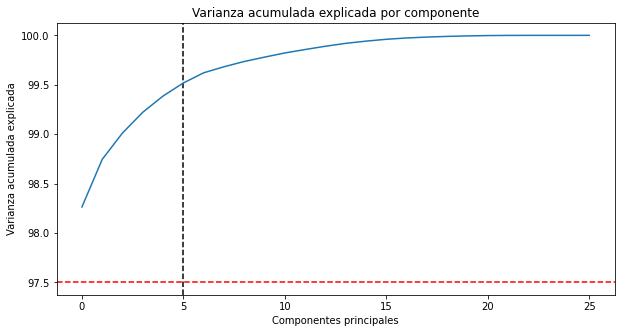

In [128]:
plt.figure(figsize=[10, 5])
plt.title('Varianza acumulada explicada por componente')
plt.ylabel('Varianza acumulada explicada')
plt.xlabel('Componentes principales')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=97.5, color="r", linestyle="--")
ax = plt.plot(var_cumu)
plt.show()

In [129]:
pca = PCA(n_components=k)
pca_transform=pca.fit_transform(data_r)

columnas = ["R_PCA_" + f"{i}" for i in range(5)]
pca_r = pd.DataFrame(data = pca_transform, columns=columnas)

In [130]:
pca_r

R_PCA_0   R_PCA_1   R_PCA_2   R_PCA_3   R_PCA_4
0      -0.210235  0.117894  0.034217  0.109381  0.016918
1      -0.211632  0.104366  0.019016  0.018057 -0.021263
2      -0.217303  0.124007  0.038811  0.147616  0.028877
3      -0.212761 -0.013972 -0.048092 -0.542777 -0.463087
4      -0.212781 -0.009999 -0.045975 -0.539237 -0.463627
...          ...       ...       ...       ...       ...
271485 -0.215675  0.102827  0.024675  0.045466 -0.009757
271486 -0.212382  0.125116  0.042656  0.145053  0.036226
271487 -0.214403  0.121467  0.044830  0.148376  0.035673
271488 -0.213679  0.122843  0.042195  0.141797  0.030791
271489 -0.219393  0.126198  0.043165  0.139230  0.030603

[271490 rows x 5 columns]

Ahora unimos el dataset

In [131]:
datasets = [data_parte_a, pca_d, pca_s, pca_b, pca_r, data_p]
for d in datasets:
    d.reset_index(inplace=True)
nuevo = pd.concat(datasets, axis=1)
nuevo.drop(columns=['index'], inplace=True)

In [132]:
nuevo

customer_ID D_63 D_64  S_2_Year  \
0       000041bdba6ecadd89a52d11886e8eaaec9325906c9723...   CO    O      2017   
1       000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...   CO    R      2017   
2       0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...   CO    R      2017   
3       0000f99513770170a1aba690daeeb8a96da4a39f11fc27...   CO    U      2017   
4       00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...   CO    O      2017   
...                                                   ...  ...  ...       ...   
271485  ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...   CO    U      2018   
271486  ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...   CO    R      2017   
271487  ffff9984b999fccb2b6127635ed0736dda94e544e67e02...   CO    U      2018   
271488  ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...   CO    U      2017   
271489  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...   CL    O      2017   

        S_2_Month  S_2_Day   D_PCA_0   D_PCA_1   D_PCA_2   D_PCA_3  ...  \
0              10       23  3.512077  2.147760 -0.115097 -0.728047  ...   
1              11       10 -0.711851  3.343450 -0.116653 -0.204407  ...   
2              10       15  3.706460  0.217377 -0.099013 -0.547941  ...   
3               3       15 -3.599161  1.908912 -0.083525 -0.345060  ...   
4               7        1 -0.537902  1.895270 -0.027416  1.072091  ...   
...           ...      ...       ...       ...       ...       ...  ...   
271485          2       23  1.736775 -0.601856 -0.078533 -0.001314  ...   
271486          9       21  0.754667 -1.075893 -0.028335  1.242060  ...   
271487          2        6 -3.277594 -0.469541 -0.087997  0.445730  ...   
271488          4       24 -0.513368  1.279014 -0.059314  0.677924  ...   
271489          6       19  0.723208  0.026641 -0.111625 -0.683247  ...   

        B_PCA_17  B_PCA_18   R_PCA_0   R_PCA_1   R_PCA_2   R_PCA_3   R_PCA_4  \
0      -0.002628 -0.021287 -0.210235  0.117894  0.034217  0.109381  0.016918   
1      -0.162244  0.167441 -0.211632  0.104366  0.019016  0.018057 -0.021263   
2       0.107924 -0.053269 -0.217303  0.124007  0.038811  0.147616  0.028877   
3       0.088318  0.065284 -0.212761 -0.013972 -0.048092 -0.542777 -0.463087   
4      -0.150217  0.094259 -0.212781 -0.009999 -0.045975 -0.539237 -0.463627   
...          ...       ...       ...       ...       ...       ...       ...   
271485  0.029811 -0.134564 -0.215675  0.102827  0.024675  0.045466 -0.009757   
271486  0.128088 -0.039543 -0.212382  0.125116  0.042656  0.145053  0.036226   
271487 -0.004034 -0.082318 -0.214403  0.121467  0.044830  0.148376  0.035673   
271488  0.004257  0.012155 -0.213679  0.122843  0.042195  0.141797  0.030791   
271489  0.106965 -0.023187 -0.219393  0.126198  0.043165  0.139230  0.030603   

             P_2       P_3       P_4  
0       0.606677  0.625043  0.008033  
1       0.407172  0.460513  0.958510  
2       1.005125  0.610162  0.003287  
3       0.400025  0.493678  0.000238  
4       0.311111  0.512139  0.963224  
...          ...       ...       ...  
271485  0.812465  0.669264  0.002546  
271486  0.864945  0.618036  0.005410  
271487  0.786806  0.627655  0.002139  
271488  0.852883  0.524818  0.007380  
271489  1.005768  0.752543  0.003926  

[271490 rows x 88 columns]

In [133]:
data

customer_ID       P_2      D_39  \
0       000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  0.606677  0.033809   
1       000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  0.407172  0.001548   
2       0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...  1.005125  0.215301   
3       0000f99513770170a1aba690daeeb8a96da4a39f11fc27...  0.400025  0.000278   
4       00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...  0.311111  0.592908   
...                                                   ...       ...       ...   
276567  ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...  0.812465  0.002464   
276568  ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...  0.864945  0.036332   
276569  ffff9984b999fccb2b6127635ed0736dda94e544e67e02...  0.786806  0.236684   
276570  ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...  0.852883  0.005489   
276571  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  1.005768  0.206469   

             B_1       B_2       R_1       S_3      D_41       B_3      D_43  \
0       0.025544  0.815019  0.000523  0.172446  0.003708  0.000053  0.064441   
1       0.106145  0.048557  0.001353  0.330037  0.009187  0.223204  0.068893   
2       0.099128  0.082039  0.005363  0.092882  0.001929  0.158300  0.009967   
3       0.954861  0.023890  0.003140  0.164106  0.008421  1.175081  0.066728   
4       0.096867  0.040793  0.002294  0.460324  0.009938  0.223131  0.053988   
...          ...       ...       ...       ...       ...       ...       ...   
276567  0.016056  1.003230  0.007137  0.136428  0.000088  0.009943  0.103616   
276568  0.359523  0.041615  0.008703  0.194697  0.007207  0.269648  0.088657   
276569  0.016190  1.001367  0.008386  0.070241  0.000588  0.000675  0.051606   
276570  0.000281  0.813544  0.000149  0.368054  0.001709  0.070558  0.088657   
276571  0.029999  0.620975  0.008176  0.033445  0.003778  0.038097  0.014183   

        ...     D_133      R_28     D_139     D_140     D_143     D_144  \
0       ...  0.003671  0.005287  0.008022  0.004774  0.000654  0.001793   
1       ...  0.008582  0.001165  0.000510  0.001478  0.004614  0.007917   
2       ...  0.000064  0.007438  0.006687  0.007377  0.009990  0.002785   
3       ...  0.007364  0.007980  1.002518  0.001170  1.003923  0.008945   
4       ...  0.006729  0.000394  0.001164  0.001779  0.006252  0.008367   
...     ...       ...       ...       ...       ...       ...       ...   
276567  ...  0.005694  0.005480  0.009720  0.009944  0.007779  0.005021   
276568  ...  1.133691  0.006643  0.005813  0.002701  0.008592  0.009413   
276569  ...  0.002185  0.005860  0.006160  0.009230  0.009720  0.007795   
276570  ...  0.005967  0.005365  1.006073  0.006703  1.004450  0.007339   
276571  ...  0.000926  0.000449  0.007099  0.004032  0.009316  0.002273   

           D_145  S_2_Year  S_2_Month  S_2_Day  
0       0.006356      2017         10       23  
1       0.006711      2017         11       10  
2       0.009664      2017         10       15  
3       0.736632      2017          3       15  
4       0.005460      2017          7        1  
...          ...       ...        ...      ...  
276567  0.005594      2018          2       23  
276568  0.007067      2017          9       21  
276569  0.006619      2018          2        6  
276570  0.186192      2017          4       24  
276571  0.002568      2017          6       19  

[271490 rows x 167 columns]

Nos quedamos con el nuevo dataset

In [134]:
data = nuevo

**Normalización de los datos**  
Evaluamos la posible normalizacion de los datos para cada variable, para eso veremos la antidad de valores que son mayores a 1.

In [135]:
contador_total = 0
contador_variables = 0
for col in data.columns:
    contador = 0
    for elemento in data[col]:
        contador_total += 1
        if(isinstance(elemento, float) and elemento > 1):
            contador += 1
            contador_variables += 1
    print(f"{col}: {contador}")
print(f"Porcentaje total: {round(contador_variables/contador_total, 2)}" + "%")

customer_ID: 0
D_63: 0
D_64: 0
S_2_Year: 0
S_2_Month: 0
S_2_Day: 0
D_PCA_0: 95680
D_PCA_1: 59873
D_PCA_2: 2583
D_PCA_3: 36372
D_PCA_4: 20628
D_PCA_5: 15799
D_PCA_6: 24941
D_PCA_7: 15056
D_PCA_8: 8247
D_PCA_9: 3750
D_PCA_10: 1136
D_PCA_11: 2544
D_PCA_12: 1442
D_PCA_13: 793
D_PCA_14: 277
D_PCA_15: 667
D_PCA_16: 1897
D_PCA_17: 6251
D_PCA_18: 1163
D_PCA_19: 2019
D_PCA_20: 1885
D_PCA_21: 89
D_PCA_22: 190
D_PCA_23: 398
D_PCA_24: 55
D_PCA_25: 159
D_PCA_26: 1094
D_PCA_27: 625
D_PCA_28: 87
D_PCA_29: 12
D_PCA_30: 123
D_PCA_31: 112
D_PCA_32: 17
D_PCA_33: 1
D_PCA_34: 58
D_PCA_35: 540
D_PCA_36: 37
D_PCA_37: 175
D_PCA_38: 6
D_PCA_39: 565
D_PCA_40: 51
S_PCA_0: 5562
S_PCA_1: 833
S_PCA_2: 775
S_PCA_3: 2734
S_PCA_4: 436
S_PCA_5: 957
S_PCA_6: 2477
S_PCA_7: 530
S_PCA_8: 18
S_PCA_9: 1415
S_PCA_10: 651
S_PCA_11: 11
S_PCA_12: 53
S_PCA_13: 76
B_PCA_0: 65447
B_PCA_1: 6747
B_PCA_2: 6386
B_PCA_3: 1813
B_PCA_4: 2310
B_PCA_5: 2828
B_PCA_6: 1077
B_PCA_7: 2993
B_PCA_8: 1636
B_PCA_9: 249
B_PCA_10: 669
B_PCA_11: 352
B

In [136]:
data

customer_ID D_63 D_64  S_2_Year  \
0       000041bdba6ecadd89a52d11886e8eaaec9325906c9723...   CO    O      2017   
1       000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...   CO    R      2017   
2       0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...   CO    R      2017   
3       0000f99513770170a1aba690daeeb8a96da4a39f11fc27...   CO    U      2017   
4       00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...   CO    O      2017   
...                                                   ...  ...  ...       ...   
271485  ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...   CO    U      2018   
271486  ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...   CO    R      2017   
271487  ffff9984b999fccb2b6127635ed0736dda94e544e67e02...   CO    U      2018   
271488  ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...   CO    U      2017   
271489  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...   CL    O      2017   

        S_2_Month  S_2_Day   D_PCA_0   D_PCA_1   D_PCA_2   D_PCA_3  ...  \
0              10       23  3.512077  2.147760 -0.115097 -0.728047  ...   
1              11       10 -0.711851  3.343450 -0.116653 -0.204407  ...   
2              10       15  3.706460  0.217377 -0.099013 -0.547941  ...   
3               3       15 -3.599161  1.908912 -0.083525 -0.345060  ...   
4               7        1 -0.537902  1.895270 -0.027416  1.072091  ...   
...           ...      ...       ...       ...       ...       ...  ...   
271485          2       23  1.736775 -0.601856 -0.078533 -0.001314  ...   
271486          9       21  0.754667 -1.075893 -0.028335  1.242060  ...   
271487          2        6 -3.277594 -0.469541 -0.087997  0.445730  ...   
271488          4       24 -0.513368  1.279014 -0.059314  0.677924  ...   
271489          6       19  0.723208  0.026641 -0.111625 -0.683247  ...   

        B_PCA_17  B_PCA_18   R_PCA_0   R_PCA_1   R_PCA_2   R_PCA_3   R_PCA_4  \
0      -0.002628 -0.021287 -0.210235  0.117894  0.034217  0.109381  0.016918   
1      -0.162244  0.167441 -0.211632  0.104366  0.019016  0.018057 -0.021263   
2       0.107924 -0.053269 -0.217303  0.124007  0.038811  0.147616  0.028877   
3       0.088318  0.065284 -0.212761 -0.013972 -0.048092 -0.542777 -0.463087   
4      -0.150217  0.094259 -0.212781 -0.009999 -0.045975 -0.539237 -0.463627   
...          ...       ...       ...       ...       ...       ...       ...   
271485  0.029811 -0.134564 -0.215675  0.102827  0.024675  0.045466 -0.009757   
271486  0.128088 -0.039543 -0.212382  0.125116  0.042656  0.145053  0.036226   
271487 -0.004034 -0.082318 -0.214403  0.121467  0.044830  0.148376  0.035673   
271488  0.004257  0.012155 -0.213679  0.122843  0.042195  0.141797  0.030791   
271489  0.106965 -0.023187 -0.219393  0.126198  0.043165  0.139230  0.030603   

             P_2       P_3       P_4  
0       0.606677  0.625043  0.008033  
1       0.407172  0.460513  0.958510  
2       1.005125  0.610162  0.003287  
3       0.400025  0.493678  0.000238  
4       0.311111  0.512139  0.963224  
...          ...       ...       ...  
271485  0.812465  0.669264  0.002546  
271486  0.864945  0.618036  0.005410  
271487  0.786806  0.627655  0.002139  
271488  0.852883  0.524818  0.007380  
271489  1.005768  0.752543  0.003926  

[271490 rows x 88 columns]

In [137]:
data = data.reindex(sorted(data.columns), axis=1)

In [138]:
data

B_PCA_0   B_PCA_1  B_PCA_10  B_PCA_11  B_PCA_12  B_PCA_13  B_PCA_14  \
0      -0.999580  0.267570 -0.080150 -0.177257 -0.012812  0.001904  0.052365   
1       2.687739 -0.044771  0.586558  0.583539 -0.181113  0.853765 -0.153172   
2       0.518587 -0.266272  0.057081 -0.064140 -0.005158 -0.171388  0.025807   
3       3.287702 -0.922843 -0.522005 -0.360304  0.077643 -0.262918  0.033835   
4       1.802205 -0.410069  0.556152  0.512954 -0.162839  0.057637 -0.025845   
...          ...       ...       ...       ...       ...       ...       ...   
271485 -1.061957  0.395752 -0.029306 -0.111570  0.078996  0.007690  0.030998   
271486  4.555342  0.838795  0.254977 -0.193987 -0.071466 -0.085737  0.008865   
271487 -1.011503  0.292699 -0.056660 -0.266518  0.000074  0.048871 -0.029155   
271488  0.152590  0.425543  0.121617 -0.137726  0.071347 -0.042988  0.067945   
271489  0.336705  0.124015  0.078310  0.165549 -0.050777 -0.165342  0.027676   

        B_PCA_15  B_PCA_16  B_PCA_17  ...  S_PCA_13   S_PCA_2   S_PCA_3  \
0       0.005783 -0.004355 -0.002628  ... -0.058578 -0.040918  0.159669   
1       0.022483  0.004401 -0.162244  ...  0.085475 -0.246111 -0.132950   
2       0.009566 -0.047831  0.107924  ...  0.037141  0.018832 -0.297103   
3       0.027420 -0.111788  0.088318  ... -0.327223 -1.272519  1.580379   
4       0.056644 -0.046404 -0.150217  ...  0.089923 -0.619010  0.037618   
...          ...       ...       ...  ...       ...       ...       ...   
271485  0.008344 -0.040767  0.029811  ... -0.094030  0.113469 -0.049982   
271486  0.010848 -0.040388  0.128088  ...  0.005970 -0.354923 -0.023415   
271487 -0.005057 -0.004673 -0.004034  ...  0.139805 -0.066681 -0.214727   
271488  0.032948  0.001226  0.004257  ... -0.015225 -0.565226 -0.004682   
271489  0.032369 -0.050911  0.106965  ...  0.053125 -0.110163 -0.254677   

         S_PCA_4   S_PCA_5   S_PCA_6   S_PCA_7   S_PCA_8   S_PCA_9  \
0      -0.297275 -0.118251 -0.073895  0.118861 -0.019898  0.091892   
1       0.084421 -0.015211  0.068102  0.229876 -0.004479 -0.175236   
2       0.294263  0.039617  0.021564  0.059032 -0.011466 -0.091042   
3      -0.530208  9.522516 -1.364415 -1.210628 -0.126110 -0.755439   
4       0.068917  0.247668 -0.022324  0.067996  0.047667  0.546373   
...          ...       ...       ...       ...       ...       ...   
271485 -0.176694 -0.075071 -0.134720 -0.163016 -0.000631  0.009885   
271486 -0.034875 -0.157905 -0.105974 -0.131226  0.001886 -0.041337   
271487  0.053784 -0.090187 -0.182586 -0.419488  0.024626 -0.102696   
271488  0.054364 -0.133939  0.013383  0.097178 -0.098806 -0.113041   
271489  0.419552 -0.046555 -0.048046 -0.253329  0.022928  0.047230   

                                              customer_ID  
0       000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  
1       000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  
2       0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...  
3       0000f99513770170a1aba690daeeb8a96da4a39f11fc27...  
4       00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...  
...                                                   ...  
271485  ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...  
271486  ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...  
271487  ffff9984b999fccb2b6127635ed0736dda94e544e67e02...  
271488  ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...  
271489  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  

[271490 rows x 88 columns]

In [139]:
for col in data.columns:
    if(col not in ["customer_ID", "S_2_Year", "S_2_Month", "S_2_Day"]):
        for elemento in data[col]:
            if(isinstance(elemento, float) and elemento > 1):
                data[col]=(data[col]-data[col].min())/(data[col].max()-data[col].min())
    
data

B_PCA_0   B_PCA_1  B_PCA_10  B_PCA_11  B_PCA_12  B_PCA_13  B_PCA_14  \
0       0.162177  0.497247  0.420407  0.248038  0.385563  0.421157  0.500195   
1       0.573864  0.452974  0.468121  0.327648  0.376918  0.475512  0.495627   
2       0.331679  0.421577  0.430228  0.259875  0.385957  0.410099  0.499605   
3       0.640849  0.328510  0.388784  0.228884  0.390210  0.404259  0.499784   
4       0.474994  0.401194  0.465945  0.320262  0.377856  0.424713  0.498457   
...          ...       ...       ...       ...       ...       ...       ...   
271485  0.155213  0.515416  0.424046  0.254911  0.390280  0.421526  0.499720   
271486  0.782380  0.578216  0.444391  0.246287  0.382550  0.415565  0.499229   
271487  0.160846  0.500809  0.422088  0.238698  0.386225  0.424154  0.498384   
271488  0.290816  0.519639  0.434847  0.252175  0.389887  0.418292  0.500542   
271489  0.311373  0.476899  0.431747  0.283909  0.383613  0.410485  0.499647   

        B_PCA_15  B_PCA_16  B_PCA_17  ...  S_PCA_13   S_PCA_2   S_PCA_3  \
0       0.489923  0.428065  0.345855  ...  0.400553  0.477184  0.036950   
1       0.490716  0.428829  0.336549  ...  0.439702  0.456314  0.029472   
2       0.490103  0.424273  0.352300  ...  0.426567  0.483261  0.025277   
3       0.490951  0.418695  0.351157  ...  0.327545  0.351921  0.073260   
4       0.492339  0.424398  0.337250  ...  0.440911  0.418388  0.033831   
...          ...       ...       ...  ...       ...       ...       ...   
271485  0.490045  0.424889  0.347746  ...  0.390919  0.492886  0.031592   
271486  0.490164  0.424923  0.353476  ...  0.418095  0.445247  0.032271   
271487  0.489409  0.428038  0.345773  ...  0.454467  0.474564  0.027382   
271488  0.491213  0.428552  0.346256  ...  0.412335  0.423858  0.032750   
271489  0.491186  0.424005  0.352244  ...  0.430910  0.470141  0.026361   

         S_PCA_4   S_PCA_5   S_PCA_6   S_PCA_7   S_PCA_8   S_PCA_9  \
0       0.136125  0.390164  0.261146  0.321030  0.216412  0.203706   
1       0.151781  0.395287  0.283337  0.328234  0.216608  0.182693   
2       0.160388  0.398013  0.276064  0.317149  0.216519  0.189316   
3       0.126571  0.869491  0.059467  0.234768  0.215063  0.137053   
4       0.151145  0.408357  0.269206  0.317730  0.217270  0.239457   
...          ...       ...       ...       ...       ...       ...   
271485  0.141071  0.392311  0.251641  0.302741  0.216657  0.197255   
271486  0.146888  0.388192  0.256133  0.304804  0.216689  0.193226   
271487  0.150524  0.391559  0.244160  0.286100  0.216977  0.188399   
271488  0.150548  0.389384  0.274786  0.319624  0.215410  0.187586   
271489  0.165527  0.393728  0.265186  0.296881  0.216956  0.200193   

                                              customer_ID  
0       000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  
1       000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  
2       0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...  
3       0000f99513770170a1aba690daeeb8a96da4a39f11fc27...  
4       00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...  
...                                                   ...  
271485  ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...  
271486  ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...  
271487  ffff9984b999fccb2b6127635ed0736dda94e544e67e02...  
271488  ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...  
271489  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  

[271490 rows x 88 columns]

In [140]:
data

B_PCA_0   B_PCA_1  B_PCA_10  B_PCA_11  B_PCA_12  B_PCA_13  B_PCA_14  \
0       0.162177  0.497247  0.420407  0.248038  0.385563  0.421157  0.500195   
1       0.573864  0.452974  0.468121  0.327648  0.376918  0.475512  0.495627   
2       0.331679  0.421577  0.430228  0.259875  0.385957  0.410099  0.499605   
3       0.640849  0.328510  0.388784  0.228884  0.390210  0.404259  0.499784   
4       0.474994  0.401194  0.465945  0.320262  0.377856  0.424713  0.498457   
...          ...       ...       ...       ...       ...       ...       ...   
271485  0.155213  0.515416  0.424046  0.254911  0.390280  0.421526  0.499720   
271486  0.782380  0.578216  0.444391  0.246287  0.382550  0.415565  0.499229   
271487  0.160846  0.500809  0.422088  0.238698  0.386225  0.424154  0.498384   
271488  0.290816  0.519639  0.434847  0.252175  0.389887  0.418292  0.500542   
271489  0.311373  0.476899  0.431747  0.283909  0.383613  0.410485  0.499647   

        B_PCA_15  B_PCA_16  B_PCA_17  ...  S_PCA_13   S_PCA_2   S_PCA_3  \
0       0.489923  0.428065  0.345855  ...  0.400553  0.477184  0.036950   
1       0.490716  0.428829  0.336549  ...  0.439702  0.456314  0.029472   
2       0.490103  0.424273  0.352300  ...  0.426567  0.483261  0.025277   
3       0.490951  0.418695  0.351157  ...  0.327545  0.351921  0.073260   
4       0.492339  0.424398  0.337250  ...  0.440911  0.418388  0.033831   
...          ...       ...       ...  ...       ...       ...       ...   
271485  0.490045  0.424889  0.347746  ...  0.390919  0.492886  0.031592   
271486  0.490164  0.424923  0.353476  ...  0.418095  0.445247  0.032271   
271487  0.489409  0.428038  0.345773  ...  0.454467  0.474564  0.027382   
271488  0.491213  0.428552  0.346256  ...  0.412335  0.423858  0.032750   
271489  0.491186  0.424005  0.352244  ...  0.430910  0.470141  0.026361   

         S_PCA_4   S_PCA_5   S_PCA_6   S_PCA_7   S_PCA_8   S_PCA_9  \
0       0.136125  0.390164  0.261146  0.321030  0.216412  0.203706   
1       0.151781  0.395287  0.283337  0.328234  0.216608  0.182693   
2       0.160388  0.398013  0.276064  0.317149  0.216519  0.189316   
3       0.126571  0.869491  0.059467  0.234768  0.215063  0.137053   
4       0.151145  0.408357  0.269206  0.317730  0.217270  0.239457   
...          ...       ...       ...       ...       ...       ...   
271485  0.141071  0.392311  0.251641  0.302741  0.216657  0.197255   
271486  0.146888  0.388192  0.256133  0.304804  0.216689  0.193226   
271487  0.150524  0.391559  0.244160  0.286100  0.216977  0.188399   
271488  0.150548  0.389384  0.274786  0.319624  0.215410  0.187586   
271489  0.165527  0.393728  0.265186  0.296881  0.216956  0.200193   

                                              customer_ID  
0       000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  
1       000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  
2       0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...  
3       0000f99513770170a1aba690daeeb8a96da4a39f11fc27...  
4       00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...  
...                                                   ...  
271485  ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...  
271486  ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...  
271487  ffff9984b999fccb2b6127635ed0736dda94e544e67e02...  
271488  ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...  
271489  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  

[271490 rows x 88 columns]

### Tareas de limpieza y transformación extras

Vamos a pasar a numeros todas las variables del dataset para no tener problemas con los distintos modelos. Aquellas que no puedan pasarse no serán tenidas en cuenta al momento de dividir el set en train y test.

In [141]:
cols = data.select_dtypes(include=['number']).columns
not_cols = [x for x in data.columns if (x not in cols)]
not_cols

['D_63', 'D_64', 'customer_ID']

Como habíamos visto en la sección Columnas a agregar, D_63 y D_64 eran columnas con información de tipo Object (string). Veamos cuántos valores pueden tomar

In [142]:
print(f'D_63 toma {data["D_63"].nunique()} valores posibles')
print(f'D_64 toma {data["D_64"].nunique()} valores posibles')

D_63 toma 6 valores posibles
D_64 toma 4 valores posibles


Son pocos los valores categorícos que toma, por lo tanto decidimos aplicar One Hot Encoding por medio de get_dummies, y modelamos los nulos como una categoría más:

In [143]:
data = pd.get_dummies(data, columns=['D_64'], dummy_na=True)

In [144]:
data = pd.get_dummies(data, columns=['D_63'], dummy_na=True)

In [145]:
data

B_PCA_0   B_PCA_1  B_PCA_10  B_PCA_11  B_PCA_12  B_PCA_13  B_PCA_14  \
0       0.162177  0.497247  0.420407  0.248038  0.385563  0.421157  0.500195   
1       0.573864  0.452974  0.468121  0.327648  0.376918  0.475512  0.495627   
2       0.331679  0.421577  0.430228  0.259875  0.385957  0.410099  0.499605   
3       0.640849  0.328510  0.388784  0.228884  0.390210  0.404259  0.499784   
4       0.474994  0.401194  0.465945  0.320262  0.377856  0.424713  0.498457   
...          ...       ...       ...       ...       ...       ...       ...   
271485  0.155213  0.515416  0.424046  0.254911  0.390280  0.421526  0.499720   
271486  0.782380  0.578216  0.444391  0.246287  0.382550  0.415565  0.499229   
271487  0.160846  0.500809  0.422088  0.238698  0.386225  0.424154  0.498384   
271488  0.290816  0.519639  0.434847  0.252175  0.389887  0.418292  0.500542   
271489  0.311373  0.476899  0.431747  0.283909  0.383613  0.410485  0.499647   

        B_PCA_15  B_PCA_16  B_PCA_17  ...  D_64_R  D_64_U  D_64_nan  D_63_CL  \
0       0.489923  0.428065  0.345855  ...       0       0         0        0   
1       0.490716  0.428829  0.336549  ...       1       0         0        0   
2       0.490103  0.424273  0.352300  ...       1       0         0        0   
3       0.490951  0.418695  0.351157  ...       0       1         0        0   
4       0.492339  0.424398  0.337250  ...       0       0         0        0   
...          ...       ...       ...  ...     ...     ...       ...      ...   
271485  0.490045  0.424889  0.347746  ...       0       1         0        0   
271486  0.490164  0.424923  0.353476  ...       1       0         0        0   
271487  0.489409  0.428038  0.345773  ...       0       1         0        0   
271488  0.491213  0.428552  0.346256  ...       0       1         0        0   
271489  0.491186  0.424005  0.352244  ...       0       0         0        1   

        D_63_CO  D_63_CR  D_63_XL  D_63_XM  D_63_XZ  D_63_nan  
0             1        0        0        0        0         0  
1             1        0        0        0        0         0  
2             1        0        0        0        0         0  
3             1        0        0        0        0         0  
4             1        0        0        0        0         0  
...         ...      ...      ...      ...      ...       ...  
271485        1        0        0        0        0         0  
271486        1        0        0        0        0         0  
271487        1        0        0        0        0         0  
271488        1        0        0        0        0         0  
271489        0        0        0        0        0         0  

[271490 rows x 98 columns]

### Balanceo del dataset

Hasta el momento se trabajó con la parte de datos del dataset, ahora haremos un merge con los labels para ver qué tan balanceado se encuentra

In [146]:
completo = pd.merge(data, labels, on='customer_ID', how='inner')
completo

B_PCA_0   B_PCA_1  B_PCA_10  B_PCA_11  B_PCA_12  B_PCA_13  B_PCA_14  \
0       0.162177  0.497247  0.420407  0.248038  0.385563  0.421157  0.500195   
1       0.573864  0.452974  0.468121  0.327648  0.376918  0.475512  0.495627   
2       0.331679  0.421577  0.430228  0.259875  0.385957  0.410099  0.499605   
3       0.640849  0.328510  0.388784  0.228884  0.390210  0.404259  0.499784   
4       0.474994  0.401194  0.465945  0.320262  0.377856  0.424713  0.498457   
...          ...       ...       ...       ...       ...       ...       ...   
271485  0.155213  0.515416  0.424046  0.254911  0.390280  0.421526  0.499720   
271486  0.782380  0.578216  0.444391  0.246287  0.382550  0.415565  0.499229   
271487  0.160846  0.500809  0.422088  0.238698  0.386225  0.424154  0.498384   
271488  0.290816  0.519639  0.434847  0.252175  0.389887  0.418292  0.500542   
271489  0.311373  0.476899  0.431747  0.283909  0.383613  0.410485  0.499647   

        B_PCA_15  B_PCA_16  B_PCA_17  ...  D_64_U  D_64_nan  D_63_CL  D_63_CO  \
0       0.489923  0.428065  0.345855  ...       0         0        0        1   
1       0.490716  0.428829  0.336549  ...       0         0        0        1   
2       0.490103  0.424273  0.352300  ...       0         0        0        1   
3       0.490951  0.418695  0.351157  ...       1         0        0        1   
4       0.492339  0.424398  0.337250  ...       0         0        0        1   
...          ...       ...       ...  ...     ...       ...      ...      ...   
271485  0.490045  0.424889  0.347746  ...       1         0        0        1   
271486  0.490164  0.424923  0.353476  ...       0         0        0        1   
271487  0.489409  0.428038  0.345773  ...       1         0        0        1   
271488  0.491213  0.428552  0.346256  ...       1         0        0        1   
271489  0.491186  0.424005  0.352244  ...       0         0        1        0   

        D_63_CR  D_63_XL  D_63_XM  D_63_XZ  D_63_nan  target  
0             0        0        0        0         0       0  
1             0        0        0        0         0       0  
2             0        0        0        0         0       0  
3             0        0        0        0         0       1  
4             0        0        0        0         0       1  
...         ...      ...      ...      ...       ...     ...  
271485        0        0        0        0         0       0  
271486        0        0        0        0         0       0  
271487        0        0        0        0         0       0  
271488        0        0        0        0         0       1  
271489        0        0        0        0         0       0  

[271490 rows x 99 columns]

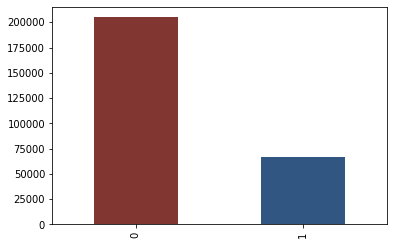

In [147]:
colores=["#75201a","#194373"]
completo['target'].value_counts().plot.bar(alpha=0.9, color=colores)
plt.show()

Vemos que el dataset está desbalanceado, hay mucha cantidad de registros para los cuales no se hizo el pago (target == 0).

Es por ello que vamos a armar un segundo dataset con un balanceo por cliente manteniendo una proporcion 70 / 30 entre clientes no deudores y clientes deudores

In [148]:
cant_total = completo.shape[0]
cant_clientes = len(completo['customer_ID'].unique())
cant_clientes_morosos = len(completo[completo['target'] == 1]['customer_ID'].unique())
cant_clientes_pagos = len(completo[completo['target'] == 0]['customer_ID'].unique())
cant_target1 = completo[completo['target'] == 1].shape[0]
cant_target0 = completo[completo['target'] == 0].shape[0]
cant_elim = cant_target0 - cant_target1
ratio = 70/30

clientes_unicos = completo.drop_duplicates(subset=['customer_ID'])[['customer_ID', 'target']]
sample_clientes_unicos_pagos = clientes_unicos[clientes_unicos['target']==0].sample(n=math.ceil(cant_clientes_morosos * ratio), random_state=3)

sample_clientes_pagos = completo[completo['customer_ID'].isin(sample_clientes_unicos_pagos['customer_ID'].values)]
clientes_morosos = completo[completo['target']==1]

completo_balanceado = pd.concat([sample_clientes_pagos, clientes_morosos])

cant_quedan_clientes = len(completo_balanceado['customer_ID'].unique())
cant_quedan = completo_balanceado.shape[0]

print(f"\nEl dataset tiene {cant_total} registros y {cant_clientes} clientes, de los cuales " + \
      f"{cant_target1} registros corresponden a {cant_clientes_morosos} clientes target 1 y " + \
      f"{cant_target0} registros corresponden a {cant_clientes_pagos} clientes target 0")
print(f"\nEl dataset balanceado quedaría con {math.ceil(cant_clientes_morosos * ratio)} (cantidad de clientes target 0) + {cant_clientes_morosos} " + \
      f"(cantidad de clientes target 1) = {cant_quedan_clientes} clientes " + \
      f"y {cant_quedan} registros")


El dataset tiene 271490 registros y 205749 clientes, de los cuales 66607 registros corresponden a 51035 clientes target 1 y 204883 registros corresponden a 154714 clientes target 0

El dataset balanceado quedaría con 119082 (cantidad de clientes target 0) + 51035 (cantidad de clientes target 1) = 170117 clientes y 224198 registros


In [149]:
completo_balanceado

B_PCA_0   B_PCA_1  B_PCA_10  B_PCA_11  B_PCA_12  B_PCA_13  B_PCA_14  \
0       0.162177  0.497247  0.420407  0.248038  0.385563  0.421157  0.500195   
1       0.573864  0.452974  0.468121  0.327648  0.376918  0.475512  0.495627   
2       0.331679  0.421577  0.430228  0.259875  0.385957  0.410099  0.499605   
5       0.362012  0.351307  0.425116  0.229999  0.388869  0.449600  0.498300   
6       0.323677  0.460179  0.421053  0.270355  0.382748  0.394895  0.499926   
...          ...       ...       ...       ...       ...       ...       ...   
271470  0.576664  0.453020  0.407157  0.297324  0.423735  0.445386  0.505232   
271471  0.508197  0.568043  0.440351  0.295365  0.361769  0.405516  0.495663   
271482  0.120555  0.298450  0.345612  0.306815  0.397544  0.385880  0.502520   
271483  0.703368  0.462303  0.458042  0.239908  0.394382  0.434461  0.499341   
271488  0.290816  0.519639  0.434847  0.252175  0.389887  0.418292  0.500542   

        B_PCA_15  B_PCA_16  B_PCA_17  ...  D_64_U  D_64_nan  D_63_CL  D_63_CO  \
0       0.489923  0.428065  0.345855  ...       0         0        0        1   
1       0.490716  0.428829  0.336549  ...       0         0        0        1   
2       0.490103  0.424273  0.352300  ...       0         0        0        1   
5       0.490099  0.429661  0.348108  ...       1         0        1        0   
6       0.492072  0.423907  0.344987  ...       0         0        0        1   
...          ...       ...       ...  ...     ...       ...      ...      ...   
271470  0.492218  0.434276  0.326221  ...       0         0        0        1   
271471  0.489323  0.420194  0.352077  ...       0         0        0        0   
271482  0.490455  0.423729  0.344528  ...       0         1        0        1   
271483  0.507771  0.427467  0.343708  ...       0         0        0        1   
271488  0.491213  0.428552  0.346256  ...       1         0        0        1   

        D_63_CR  D_63_XL  D_63_XM  D_63_XZ  D_63_nan  target  
0             0        0        0        0         0       0  
1             0        0        0        0         0       0  
2             0        0        0        0         0       0  
5             0        0        0        0         0       0  
6             0        0        0        0         0       0  
...         ...      ...      ...      ...       ...     ...  
271470        0        0        0        0         0       1  
271471        1        0        0        0         0       1  
271482        0        0        0        0         0       1  
271483        0        0        0        0         0       1  
271488        0        0        0        0         0       1  

[224198 rows x 99 columns]

<AxesSubplot:>

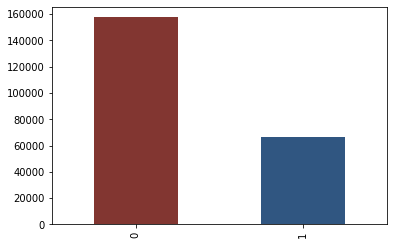

In [150]:
colores=["#75201a","#194373"]
completo_balanceado['target'].value_counts().plot.bar(alpha=0.9, color=colores)

### Definicion de metricas y prediccion por cliente

Como podemos observar existe mas de un resumen de tarjeta de credito por cliente en nuestro dataset. Ademas, como solo consideramos un 5% del mismo, no tenemos los 18 resumenes de cada cliente, por lo que algunos van a tener mas resumenes que otros, pero con un mismo target por cliente.

Para nuestro analisis vamos a definir metricas de precision, recall y F1 agrupadas por cliente, en donde cada resumen se predice de forma individual, para luego quedarnos con la media de cada cliente.

Tambien debemos agregar un split del dataset por cliente para mantener una proporcion de clentes conocida y tener todos los resumenes de un cliente en el mismo split (ya sea para entrenar el modelo o para predecir)

Por ultimo vamos a agregar variables que puedan relacionar resumenes de un mismo cliente. Para ello vamos a entrenar un clasificador que nos pueda indicar cuales fueron las variables mas influyentes en su prediccion y luego nos quedamos con una media por cliente de esas variables y las usamos para predecir con el resto de modelos.

In [151]:
all_metrics = {}
metrics_key_order = []

def save_metric(name, acc, rec, f1):
    metrics_key_order.append(name)
    all_metrics[name] = {
        "accuracy": acc,
        "recall": rec,
        "f1": f1
    }
    
def get_all_metrics():
    return all_metrics

def get_metrics_key_order():
    return metrics_key_order

In [152]:
from functools import reduce

def custom_predict(serie):
    return 0 if ((reduce(lambda x, y: x + y, serie)) / len(serie)) < 0.5 else 1

def split_por_cliente(balanceado, desbalanceado, porcentaje):
    balanceado_customer_target = balanceado[['customer_ID', 'target']]
    balanceado_clientes_unicos = balanceado.drop_duplicates(subset=['customer_ID'])[['customer_ID', 'target']]
    morosos_unicos = balanceado_customer_target[balanceado_customer_target["target"]==1]["customer_ID"].unique()
    pagos_unicos = balanceado_customer_target[balanceado_customer_target["target"]==0]["customer_ID"].unique()
    cantidad_morosos = math.ceil(len(morosos_unicos) * porcentaje)
    cantidad_pagos = math.ceil(len(pagos_unicos) * porcentaje)
    morosos_unicos_porcentaje = balanceado_clientes_unicos[balanceado_clientes_unicos['target']==1].sample(n=cantidad_morosos, random_state=3)
    pagos_unicos_porcentaje = balanceado_clientes_unicos[balanceado_clientes_unicos['target']==0].sample(n=cantidad_pagos, random_state=3)
    train_morosos = balanceado[balanceado['customer_ID'].isin(morosos_unicos_porcentaje['customer_ID'].values)]
    train_pagos = balanceado[balanceado['customer_ID'].isin(pagos_unicos_porcentaje['customer_ID'].values)]
    train_final = pd.concat([train_morosos, train_pagos])
    test_final = desbalanceado[~desbalanceado['customer_ID'].isin(train_final['customer_ID'].values)]
    y_train_final = train_final['target']
    y_test_final = test_final['target']
    return train_final.drop(['target'], axis='columns', inplace=False), test_final.drop(['target'], axis='columns', inplace=False), y_train_final, y_test_final

def get_metrics(real, predict):
    acc = accuracy_score(real, predict)
    recall = recall_score(real, predict)
    f1 = f1_score(real, predict, average='macro')
    
    return acc, recall, f1

    
def metrics_by_client(name, real, predict):
    test_by_customer_predict = x_test_copy.copy()
    test_by_customer_predict['target'] = predict
    test_by_customer_predict = test_by_customer_predict[['customer_ID', 'target']].groupby('customer_ID').agg({'target':custom_predict})        

    test_by_customer_real = x_test_copy.copy()
    test_by_customer_real['target'] = real
    test_by_customer_real = test_by_customer_real[['customer_ID', 'target']].groupby('customer_ID').agg({'target':custom_predict})
    
    acc, recall, f1 = get_metrics(test_by_customer_real['target'].values, test_by_customer_predict['target'].values)
    
    save_metric(name, acc, recall, f1)
    
    return acc, recall, f1

def confusion_matrix_by_client(real, predict):
    test_by_customer_predict = x_test_copy.copy()
    test_by_customer_predict['target'] = predict
    test_by_customer_predict = test_by_customer_predict[['customer_ID', 'target']].groupby('customer_ID').agg({'target':custom_predict})
    
    test_by_customer_real = x_test_copy.copy()
    test_by_customer_real['target'] = real
    test_by_customer_real = test_by_customer_real[['customer_ID', 'target']].groupby('customer_ID').agg({'target':custom_predict})
    
    return confusion_matrix(test_by_customer_real['target'].values, test_by_customer_predict['target'].values)

**Split de conjunto de pruebas y entrenamiento**

A continuacion creamos los sets de entrenamiento y prueba. En este caso usaremos un 40% del dataset balanceado, por lo que se obtiene un dataset con el 40% de clientes target 1 del dataset original reducido, y el resto son clientes target 0 que completan una la misma proporcion que el dataset _completo_balanceado_.

El set de pruebas contiene el resto de clientes que no fueron utilizados para entrenar, por lo que vamos a poder analizar cada modelo con la totalidad del dataset original.

In [153]:
x_train, x_test, y_train, y_test = split_por_cliente(completo_balanceado, completo, 0.4)

x_train_copy = x_train.copy()
x_test_copy = x_test.copy()

In [154]:
unicos_train = len(x_train['customer_ID'].unique())
x_train_target = x_train
x_train_target['target'] = y_train
unicos_morosos_train = len(x_train_target[x_train_target['target']==1]['customer_ID'].unique())
unicos_pagos_train = len(x_train_target[x_train_target['target']==0]['customer_ID'].unique())
registros_train = x_train.shape[0]
registros_test = x_test.shape[0]
registros_balanceado = completo_balanceado.shape[0]
registros_completo = completo.shape[0]

print(f"\nLa cantidad de clientes unicos en train es: {unicos_train}")
print(f"La cantidad de clientes morosos unicos en train es: {unicos_morosos_train}, (Porcentaje del total: {round((unicos_morosos_train / unicos_train) * 100, 2)}%)")
print(f"La cantidad de clientes pagos unicos en train es: {unicos_pagos_train}, (Porcentaje del total: {round((unicos_pagos_train / unicos_train) * 100, 2)}%)")
print(f"La cantidad de registros en train es: {registros_train}, (Porcentaje respecto de balanceado: {round((registros_train / registros_balanceado) * 100, 2)}%, porcentaje respecto del total: {round((registros_train / registros_completo) * 100, 2)}%")
print(f"La cantidad de registros en test es: {registros_test}, (Porcentaje del total: {round((registros_test / registros_completo) * 100, 2)}%)")


La cantidad de clientes unicos en train es: 68047
La cantidad de clientes morosos unicos en train es: 20414, (Porcentaje del total: 30.0%)
La cantidad de clientes pagos unicos en train es: 47633, (Porcentaje del total: 70.0%)
La cantidad de registros en train es: 89871, (Porcentaje respecto de balanceado: 40.09%, porcentaje respecto del total: 33.1%
La cantidad de registros en test es: 181619, (Porcentaje del total: 66.9%)


**Analisis de variables mas influyentes**

Entrenamos el clasificador que nos va a indicar que variables fueron las que tuvieron mas influencia durante la prediccion, en este caso usaremos Random Forest

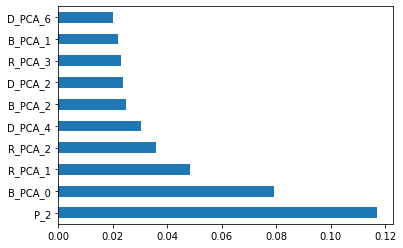

In [155]:
model = RandomForestClassifier()
x_train_sin_customer = x_train.drop(['customer_ID', 'target'], axis='columns', inplace=False)
model.fit(x_train_sin_customer,y_train)
feat_importances = pd.Series(model.feature_importances_, index=x_train_sin_customer.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Prediccion con el conjunto de prueba balanceado

In [156]:
x_test_sin_customer = x_test.drop(['customer_ID'], axis='columns', inplace=False)

predicted_categories = model.predict(x_test_sin_customer)

bf_acc, bf_recall, bf_f1 = metrics_by_client("Random Forest cust_id feature importance", y_test, predicted_categories)

print("La precision es {}".format(bf_acc))

print("El recall es {}".format(bf_recall))

print("F1 es {}".format(bf_f1))

La precision es 0.8677361258369523
El recall es 0.7844943012964959
F1 es 0.8190167727072721


Observamos la matriz de confusion para tener mas detalle sobre la prediccion de clientes deudores y no deudores.

Text(33.0, 0.5, 'True')

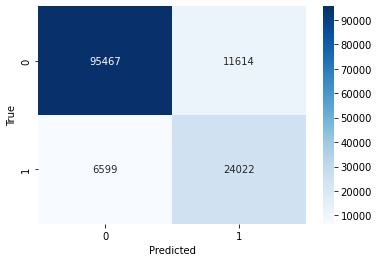

In [157]:
balanceado_important_columns_cm = confusion_matrix_by_client(y_test, predicted_categories)
sns.heatmap(balanceado_important_columns_cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Nos quedamos con las siguientes variables, que fueron las que mas influyeron con diferencia respecto del resto.

In [158]:
columnas_importantes = ["B_PCA_0","P_2"]

Para las columnas con mayor importancia, agregamos una nueva feature por columna con la media agrupada por cliente

In [159]:
completo_medias = completo.copy()
completo_balanceado_medias = completo_balanceado.copy()

for column in columnas_importantes:
    completo_medias[column + "_mean"] = (completo_medias.groupby("customer_ID")[column].transform('mean'))
    completo_balanceado_medias[column + "_mean"] = (completo_balanceado_medias.groupby("customer_ID")[column].transform('mean'))

In [160]:
completo_medias

B_PCA_0   B_PCA_1  B_PCA_10  B_PCA_11  B_PCA_12  B_PCA_13  B_PCA_14  \
0       0.162177  0.497247  0.420407  0.248038  0.385563  0.421157  0.500195   
1       0.573864  0.452974  0.468121  0.327648  0.376918  0.475512  0.495627   
2       0.331679  0.421577  0.430228  0.259875  0.385957  0.410099  0.499605   
3       0.640849  0.328510  0.388784  0.228884  0.390210  0.404259  0.499784   
4       0.474994  0.401194  0.465945  0.320262  0.377856  0.424713  0.498457   
...          ...       ...       ...       ...       ...       ...       ...   
271485  0.155213  0.515416  0.424046  0.254911  0.390280  0.421526  0.499720   
271486  0.782380  0.578216  0.444391  0.246287  0.382550  0.415565  0.499229   
271487  0.160846  0.500809  0.422088  0.238698  0.386225  0.424154  0.498384   
271488  0.290816  0.519639  0.434847  0.252175  0.389887  0.418292  0.500542   
271489  0.311373  0.476899  0.431747  0.283909  0.383613  0.410485  0.499647   

        B_PCA_15  B_PCA_16  B_PCA_17  ...  D_63_CL  D_63_CO  D_63_CR  D_63_XL  \
0       0.489923  0.428065  0.345855  ...        0        1        0        0   
1       0.490716  0.428829  0.336549  ...        0        1        0        0   
2       0.490103  0.424273  0.352300  ...        0        1        0        0   
3       0.490951  0.418695  0.351157  ...        0        1        0        0   
4       0.492339  0.424398  0.337250  ...        0        1        0        0   
...          ...       ...       ...  ...      ...      ...      ...      ...   
271485  0.490045  0.424889  0.347746  ...        0        1        0        0   
271486  0.490164  0.424923  0.353476  ...        0        1        0        0   
271487  0.489409  0.428038  0.345773  ...        0        1        0        0   
271488  0.491213  0.428552  0.346256  ...        0        1        0        0   
271489  0.491186  0.424005  0.352244  ...        1        0        0        0   

        D_63_XM  D_63_XZ  D_63_nan  target  B_PCA_0_mean  P_2_mean  
0             0        0         0       0      0.162177  0.713168  
1             0        0         0       0      0.573864  0.571284  
2             0        0         0       0      0.331679  0.996534  
3             0        0         0       1      0.640849  0.566202  
4             0        0         0       1      0.474994  0.502968  
...         ...      ...       ...     ...           ...       ...  
271485        0        0         0       0      0.155213  0.859519  
271486        0        0         0       0      0.782380  0.896842  
271487        0        0         0       0      0.160846  0.841271  
271488        0        0         0       1      0.290816  0.888263  
271489        0        0         0       0      0.311373  0.996992  

[271490 rows x 101 columns]

In [161]:
completo_balanceado_medias

B_PCA_0   B_PCA_1  B_PCA_10  B_PCA_11  B_PCA_12  B_PCA_13  B_PCA_14  \
0       0.162177  0.497247  0.420407  0.248038  0.385563  0.421157  0.500195   
1       0.573864  0.452974  0.468121  0.327648  0.376918  0.475512  0.495627   
2       0.331679  0.421577  0.430228  0.259875  0.385957  0.410099  0.499605   
5       0.362012  0.351307  0.425116  0.229999  0.388869  0.449600  0.498300   
6       0.323677  0.460179  0.421053  0.270355  0.382748  0.394895  0.499926   
...          ...       ...       ...       ...       ...       ...       ...   
271470  0.576664  0.453020  0.407157  0.297324  0.423735  0.445386  0.505232   
271471  0.508197  0.568043  0.440351  0.295365  0.361769  0.405516  0.495663   
271482  0.120555  0.298450  0.345612  0.306815  0.397544  0.385880  0.502520   
271483  0.703368  0.462303  0.458042  0.239908  0.394382  0.434461  0.499341   
271488  0.290816  0.519639  0.434847  0.252175  0.389887  0.418292  0.500542   

        B_PCA_15  B_PCA_16  B_PCA_17  ...  D_63_CL  D_63_CO  D_63_CR  D_63_XL  \
0       0.489923  0.428065  0.345855  ...        0        1        0        0   
1       0.490716  0.428829  0.336549  ...        0        1        0        0   
2       0.490103  0.424273  0.352300  ...        0        1        0        0   
5       0.490099  0.429661  0.348108  ...        1        0        0        0   
6       0.492072  0.423907  0.344987  ...        0        1        0        0   
...          ...       ...       ...  ...      ...      ...      ...      ...   
271470  0.492218  0.434276  0.326221  ...        0        1        0        0   
271471  0.489323  0.420194  0.352077  ...        0        0        1        0   
271482  0.490455  0.423729  0.344528  ...        0        1        0        0   
271483  0.507771  0.427467  0.343708  ...        0        1        0        0   
271488  0.491213  0.428552  0.346256  ...        0        1        0        0   

        D_63_XM  D_63_XZ  D_63_nan  target  B_PCA_0_mean  P_2_mean  
0             0        0         0       0      0.162177  0.713168  
1             0        0         0       0      0.573864  0.571284  
2             0        0         0       0      0.331679  0.996534  
5             0        0         0       0      0.362012  0.624826  
6             0        0         0       0      0.323677  0.918067  
...         ...      ...       ...     ...           ...       ...  
271470        0        0         0       1      0.713702  0.495665  
271471        0        0         0       1      0.508197  0.684931  
271482        0        0         0       1      0.120555  0.739022  
271483        0        0         0       1      0.703368  0.384131  
271488        0        0         0       1      0.290816  0.888263  

[224198 rows x 101 columns]

Dividimos al dataset con las columnas nuevas y creamos dos dataset para testear cada modelo entrenado. En uno guardamos el conjunto de test agrupado por cliente y el target real de cada uno, en el otro vamos a guardar una copia del conjunto de pruebas sin la columna de target, para completarla luego con las predicciones y tomar la media del target predicho por cliente (si la media es menor a 0.5 se considera target = 0, si no se considera target = 1)

In [162]:
x_train, x_test, y_train, y_test = split_por_cliente(completo_balanceado_medias, completo_medias, 0.4)

x_train_copy = x_train.copy()
x_test_copy = x_test.copy()

Para hacer las pruebas de cada modelo, vamos a considerar en nuestro conjunto de test a todos los registros que no consideramos en el set de entrenamiento, y vamos a entrenar cada modelo con el set balanceado a un ratio de 60-40 (target 0 (%) - target 1 (%))

Vamos a realizar una transformación en el dataset de forma que los datos tengan la forma de una desviación estandar.

In [163]:
#Armo una version estandarizada
stand_scaler = preprocessing.StandardScaler()
x_train = stand_scaler.fit_transform(x_train.drop(['customer_ID'], axis='columns', inplace=False))
x_test = stand_scaler.fit_transform(x_test.drop(['customer_ID'], axis='columns', inplace=False))

## Generación y evaluación de modelos

Vamos a buscar los mejores hiperparámetros con KFOLD CV Random Search, usaremos sólo 2 folds ya que el dataset es muy grande y puede demorar demasiado tiempo.

#### Random Forest

Buscamos los mejores hiperparámetros.

In [164]:
%%time
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import make_scorer

n=10

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'bootstrap': [True, False],
               'n_estimators': [75, 100, 150],
               'min_samples_leaf':[1,3,5],
               'max_depth':[3,5,8,10,15]}
                
#Cantidad de splits para el Cross Validation
folds=2

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = RandomForestClassifier(n_jobs=-1) 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions=params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n,
                              n_jobs=-1,
                              random_state=420
                             ) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

#Mejores hiperparametros del arbol
print(f"Best params: {randomcv.best_params_}")
#Mejor métrica
print(f"Best score: {randomcv.best_score_}")

Best params: {'n_estimators': 100, 'min_samples_leaf': 1, 'max_depth': 15, 'criterion': 'gini', 'bootstrap': False}
Best score: 0.767017048430702
CPU times: user 3min 20s, sys: 463 ms, total: 3min 20s
Wall time: 5min 46s


Entrenamos el clasificador con pesos que permitan ajustar mejor el target:

In [165]:
%%time
#Creo el árbol
arbol = RandomForestClassifier(n_jobs=-1,
                               random_state=420
                              ).set_params(**randomcv.best_params_)

n=10

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

predicted_categories1 = arbol.predict(x_test)

rf_acc1, rf_recall1, rf_f11 = metrics_by_client("Random Forest", y_test, predicted_categories1)

print("La precision es {}".format(rf_acc1))

print("El recall es {}".format(rf_recall1))

print("F1 es {}".format(rf_f11))

La precision es 0.8515417350510522
El recall es 0.8603899284804546
F1 es 0.8097037265636273
CPU times: user 3min 28s, sys: 267 ms, total: 3min 28s
Wall time: 55.9 s


Observamos que las columnas que agregamos se estan teniendo en cuenta por los arboles de clasificacion.

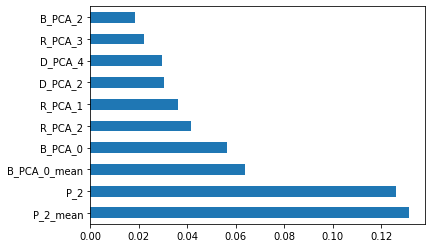

In [166]:
feat_importances_rfc = pd.Series(arbol.feature_importances_, index=x_train_copy.drop(['customer_ID'], axis='columns', inplace=False).columns)
feat_importances_rfc.nlargest(10).plot(kind='barh')
plt.show()

Luego la prediccion por customer 

Text(33.0, 0.5, 'True')

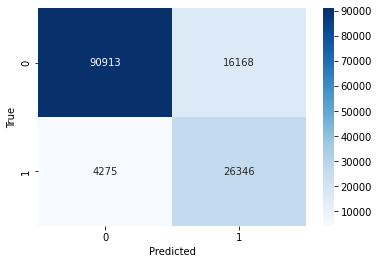

In [167]:
rfc_cm = confusion_matrix_by_client(y_test, predicted_categories1)
sns.heatmap(rfc_cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#### XGBoost

Como primer approach vemos cómo se comporta XGBoost sin tunear sus hiperparámetros

In [168]:
%%time
xgb_model_default = xgb.XGBClassifier(random_state=420)

xgb_model_default.fit(x_train, y_train)

predicted_categories_xgb_def = xgb_model_default.predict(x_test)

xgb_acc, xgb_recall, xgb_f1 = metrics_by_client("XGBoost default", y_test, predicted_categories_xgb_def)

print("La precision es {}".format(xgb_acc))

print("El recall es {}".format(xgb_recall))

print("F1 es {}".format(xgb_f1))

La precision es 0.8553906261346966
El recall es 0.8421997975245746
F1 es 0.8119035254375584
CPU times: user 5min 42s, sys: 288 ms, total: 5min 43s
Wall time: 1min 28s


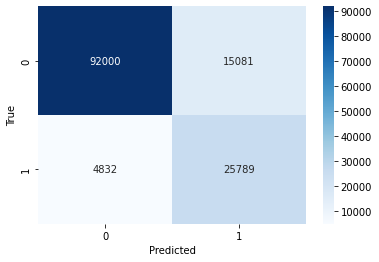

In [169]:
xgb_cm = confusion_matrix_by_client(y_test, predicted_categories_xgb_def)
sns.heatmap(xgb_cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Buscamos los mejores hiperparámetros

In [170]:
%%time
##KFOLD CV Random Search para buscar el mejor clasificador (los mejores atributos, hiperparametros,etc)

n=10

#Conjunto de parámetros que quiero usar
params_grid = {'n_estimators':[50,75,100],
               'learning_rate': [0.3, 0.1, 0.01],
               'max_depth':list(range(3,7)),
               'subsample': [0.6, 1],
               'colsample_bytree': [0.6, 1],
               'eval_metric':list(["auc", "error"])
              }
                
#Cantidad de splits para el Cross Validation
folds=2

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_model = xgb.XGBClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv_xgb = RandomizedSearchCV(estimator=base_model,
                              param_distributions=params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n,
                              n_jobs=-1,
                              random_state=420) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv_xgb.fit(x_train,y_train);

#Mejores hiperparametros del arbol
print(f"Best params: {randomcv_xgb.best_params_}")
#Mejor métrica
print(f"Best scope: {randomcv_xgb.best_score_}")

Best params: {'subsample': 1, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'eval_metric': 'error', 'colsample_bytree': 0.6}
Best scope: 0.7718755515055178
CPU times: user 3min 37s, sys: 345 ms, total: 3min 37s
Wall time: 5min 27s


Creamos el modelo con los hiperparámetros calculados

In [171]:
%%time
xgb_model = xgb.XGBClassifier(random_state=420).set_params(**randomcv_xgb.best_params_)

xgb_model.fit(x_train, y_train)

predicted_categories2 = xgb_model.predict(x_test)

xgb_acc, xgb_recall, xgb_f1 = metrics_by_client("XGBoost", y_test, predicted_categories2)

print("La precision es {}".format(xgb_acc))

print("El recall es {}".format(xgb_recall))

print("F1 es {}".format(xgb_f1))

La precision es 0.8573078096178705
El recall es 0.8595408379870024
F1 es 0.815724971722677
CPU times: user 3min 42s, sys: 463 ms, total: 3min 42s
Wall time: 58.8 s


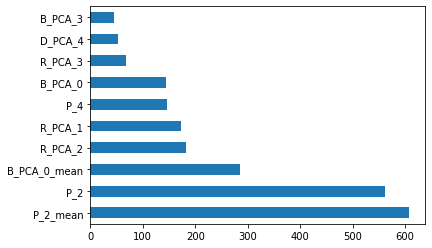

In [172]:
train_features = x_train_copy.drop(['customer_ID'], axis='columns', inplace=False).columns
feature_names = [train_features[int(x[1:])] for x in xgb_model.get_booster().get_score(importance_type='gain').keys()]
feat_importances_xgb = pd.Series(list(xgb_model.get_booster().get_score(importance_type='gain').values()), index=feature_names)
feat_importances_xgb.nlargest(10).plot(kind='barh')
plt.show()

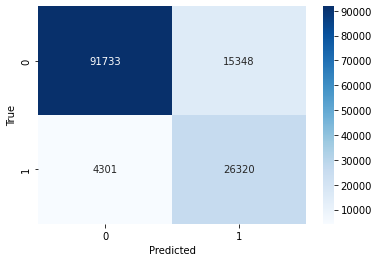

In [173]:
xgb_cm = confusion_matrix_by_client(y_test, predicted_categories2)
sns.heatmap(xgb_cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### SVM

Primero probamos el modelo sin tuneo de hiperparámetros

La precision es 0.8631900771230628
El recall es 0.829398125469449
F1 es 0.8189498788693401


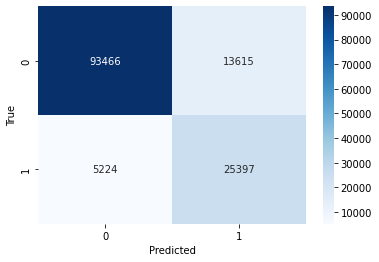

CPU times: user 1min 22s, sys: 622 ms, total: 1min 23s
Wall time: 1min 22s


In [174]:
%%time
# Usamos svm.LinearSVC ya que está hecho para datasets grandes
svm_model = svm.LinearSVC(random_state=420)

svm_model.fit(x_train, y_train)

predicted_categories3_def = svm_model.predict(x_test)

svm_acc_def, svm_recall_def, svm_f1_def = metrics_by_client("LinearSVC default", y_test, predicted_categories3_def)

print("La precision es {}".format(svm_acc_def))

print("El recall es {}".format(svm_recall_def))

print("F1 es {}".format(svm_f1_def))

svm_cm = confusion_matrix_by_client(y_test, predicted_categories3_def)
sns.heatmap(svm_cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Buscamos los mejores hiperparámetros.

In [175]:
%%time
##KFOLD CV Random Search para buscar el mejor clasificador (los mejores atributos, hiperparametros,etc)
n=10
#Conjunto de parámetros que quiero usar
params_grid = {'fit_intercept': list([True, False]),
               'dual': list([True, False]),
               'C': [0.1, 1, 10, 100],
               'tol': [0.1, 0.01, 0.001, 0.0001]
              }
                
#Cantidad de splits para el Cross Validation
folds=2

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_model = svm.LinearSVC() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv_svm = RandomizedSearchCV(estimator=base_model,
                              param_distributions=params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n,
                              n_jobs=-1,
                              random_state=420) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv_svm.fit(x_train,y_train);

#Mejores hiperparametros del arbol
print(f"Best Params: {randomcv_svm.best_params_}")
#Mejor métrica
print(f"Best score: {randomcv_svm.best_score_}")

Best Params: {'tol': 0.001, 'fit_intercept': False, 'dual': True, 'C': 1}
Best score: 0.7762713968959791
CPU times: user 1min 25s, sys: 190 ms, total: 1min 25s
Wall time: 4min 15s


Creamos el modelo.

In [176]:
%%time
# Usamos svm.LinearSVC ya que está hecho para datasets grandes
svm_model = svm.LinearSVC(random_state=420).set_params(**randomcv_svm.best_params_)

svm_model.fit(x_train, y_train)

predicted_categories3 = svm_model.predict(x_test)

svm_acc, svm_recall, svm_f1 = metrics_by_client("LinearSVC tuneado", y_test, predicted_categories3)

print("La precision es {}".format(svm_acc))

print("El recall es {}".format(svm_recall))

print("F1 es {}".format(svm_f1))

La precision es 0.8188116367227781
El recall es 0.9173769635217661
F1 es 0.7820241374758825
CPU times: user 1min 28s, sys: 400 ms, total: 1min 28s
Wall time: 1min 28s


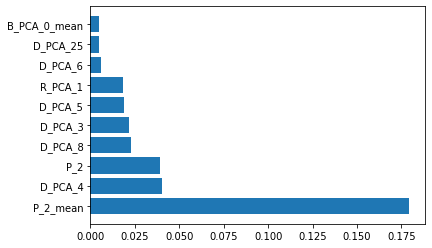

In [177]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(svm_model, x_test, y_test)

feature_names = x_train_copy.drop(['customer_ID'], axis='columns', inplace=False).columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()[::-1][:10]
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.show()

Text(33.0, 0.5, 'True')

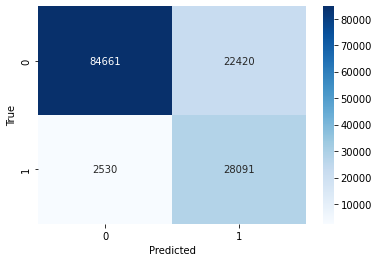

In [178]:
svm_cm = confusion_matrix_by_client(y_test, predicted_categories3)
sns.heatmap(svm_cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

### Ensamble

Realizamos un ensamble de tipo VotingClassifier.

In [179]:
%%time
#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('RF', arbol), ('xGBoost', xgb_model), ('SVM', svm_model)], voting = 'hard')

#Entreno el ensamble
vot_clf.fit(x_train, y_train)

predicted_categoriesE = vot_clf.predict(x_test)

ens_acc, ens_recall, ens_f1 = metrics_by_client("VotingClassifier", y_test, predicted_categoriesE)

print("La precision es {}".format(ens_acc))

print("El recall es {}".format(ens_recall))

print("F1 es {}".format(ens_f1))

La precision es 0.850670288013246
El recall es 0.8782208288429509
F1 es 0.8105720424616709
CPU times: user 5min 15s, sys: 968 ms, total: 5min 16s
Wall time: 3min 21s


Text(33.0, 0.5, 'True')

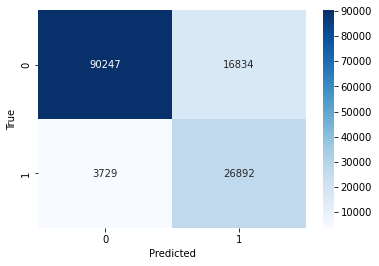

In [180]:
cm = confusion_matrix_by_client(y_test, predicted_categoriesE)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

### Red neuronal

Vamos a empezar por un modelo de red neuronal básico, y luego le vamos a ir agregando complejidad hasta llegar a un modelo predictor que supere a los anteriores

In [181]:
columnas_predictoras=completo.drop(columns=['target', 'customer_ID']).columns.to_list()
d_in=len(columnas_predictoras)

Definimos funciones que nos van a ayudar a comparar a los diferentes modelos

In [182]:
def plot_hist(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.title('Training accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.title('Training loss')
    plt.legend()

    plt.show()
    
def print_score(name, y_test, pred_red):
    
    red_acc, red_recall, red_f1 = metrics_by_client(name, y_test, pred_red)

    print("La precision es {}".format(red_acc))

    print("El recall es {}".format(red_recall))

    print("F1 es {}".format(red_f1))

El primer modelo que vamos a probar es uno básico, con 1 hidden layer de 16 nodos cuya función de regularización L2 es de tipo RELU. Como capa de output, elegimos una función de activación sigmoidea porque queremos clasificar 2 clases excluyentes. Como optimizador elegimos inicialmente SGD

In [183]:
def baseline_red_neuronal():
    features = completo_medias.drop(['customer_ID', 'target'], axis='columns', inplace=False).columns.to_list()
    regularization = 4e-4
    activation_func = 'relu'
    inputs = Input(shape = (len(features)))

    x = Dense(16,
           kernel_regularizer = tf.keras.regularizers.l2(regularization),
           activation = activation_func)(inputs)

    x = Dense(1,
              activation='sigmoid')(x)

    model = Model(inputs, x)
    model.compile(
        optimizer=tf.keras.optimizers.SGD(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy'],
    )

    
    return model

In [184]:
baseline_red = baseline_red_neuronal()
baseline_red.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 99)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,617
Trainable params: 1,617
Non-trainable params: 0
_________________________________________________________________


2022-08-08 00:31:20.265995: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [185]:
%%time
# Entrenamiento del modelo
history_base = baseline_red.fit(x_train,y_train,epochs=10,batch_size=8,verbose=True)

2022-08-08 00:31:20.943275: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
11234/11234 [==============================] - 13s 1ms/step - loss: 0.3254 - accuracy: 0.8549
Epoch 2/10
11234/11234 [==============================] - 12s 1ms/step - loss: 0.3063 - accuracy: 0.8641
Epoch 3/10
11234/11234 [==============================] - 12s 1ms/step - loss: 0.3027 - accuracy: 0.8656
Epoch 4/10
11234/11234 [==============================] - 12s 1ms/step - loss: 0.3006 - accuracy: 0.8670
Epoch 5/10
11234/11234 [==============================] - 13s 1ms/step - loss: 0.2988 - accuracy: 0.8674
Epoch 6/10
11234/11234 [==============================] - 12s 1ms/step - loss: 0.2971 - accuracy: 0.8680
Epoch 7/10
11234/11234 [==============================] - 12s 1ms/step - loss: 0.2960 - accuracy: 0.8686
Epoch 8/10
11234/11234 [==============================] - 13s 1ms/step - loss: 0.2950 - accuracy: 0.8691
Epoch 9/10
11234/11234 [==============================] - 12s 1ms/step - loss: 0.2945 - accuracy: 0.8700
Epoch 10/10
11234/11234 [==============================

Como la función de activación que estamos utilizando en la capa de salida es una función sigmoidea, el output de la red va a ser un número entre 0 y 1. Es por ello que vamos a aproximar según esté más cercano a 0 o a 1 para definir la clase a la que pertenece (pago o impago)

In [186]:
pred_base_red = baseline_red.predict(x_test)

print_score("NN Baseline SGD", y_test, pred_base_red)

La precision es 0.8576709125502897
El recall es 0.8612390189739068
F1 es 0.8162822466983916


Text(33.0, 0.5, 'True')

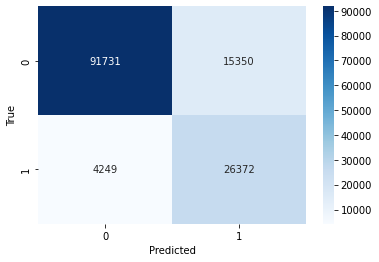

In [187]:
rn1_cm = confusion_matrix_by_client(y_test, pred_base_red)
sns.heatmap(rn1_cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

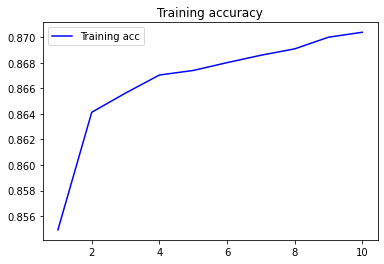

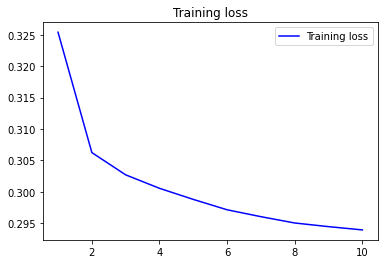

In [188]:
plot_hist(history_base)

Vamos a partir de la misma base del modelo anterior pero ahora modificando el optimizador por Adam, con los valores default (LR 0,001, Beta_1 0,9 y Beta_2 0,999)

In [189]:
def baseline_red_neuronal_v2():
    features = completo_medias.drop(['customer_ID', 'target'], axis='columns', inplace=False).columns.to_list()
    regularization = 4e-4
    activation_func = 'relu'
    inputs = Input(shape = (len(features)))

    x = Dense(16,
           kernel_regularizer = tf.keras.regularizers.l2(regularization),
           activation = activation_func)(inputs)

    x = Dense(1,
              activation='sigmoid')(x)

    model = Model(inputs, x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy'],
    )

    
    return model

In [190]:
baseline_red_v2 = baseline_red_neuronal_v2()
baseline_red_v2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 99)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1600      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,617
Trainable params: 1,617
Non-trainable params: 0
_________________________________________________________________


In [191]:
%%time
# Entrenamiento del modelo
history_base_v2 = baseline_red_v2.fit(x_train,y_train,epochs=10,batch_size=8,verbose=True)

Epoch 1/10
 3103/11234 [=======>......................] - ETA: 10s - loss: 0.3394 - accuracy: 0.8505

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


 3554/11234 [========>.....................] - ETA: 10s - loss: 0.3343 - accuracy: 0.8535

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


 3653/11234 [========>.....................] - ETA: 10s - loss: 0.3342 - accuracy: 0.8534

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


 3818/11234 [=========>....................] - ETA: 10s - loss: 0.3335 - accuracy: 0.8535

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


11234/11234 [==============================] - 16s 1ms/step - loss: 0.3183 - accuracy: 0.8604
Epoch 2/10
11234/11234 [==============================] - 15s 1ms/step - loss: 0.3041 - accuracy: 0.8660
Epoch 3/10
11234/11234 [==============================] - 15s 1ms/step - loss: 0.3018 - accuracy: 0.8666
Epoch 4/10
11234/11234 [==============================] - 15s 1ms/step - loss: 0.3006 - accuracy: 0.8675
Epoch 5/10
11234/11234 [==============================] - 16s 1ms/step - loss: 0.3002 - accuracy: 0.8680
Epoch 6/10
11234/11234 [==============================] - 15s 1ms/step - loss: 0.2998 - accuracy: 0.8680
Epoch 7/10
11234/11234 [==============================] - 16s 1ms/step - loss: 0.2998 - accuracy: 0.8685
Epoch 8/10
11234/11234 [==============================] - 15s 1ms/step - loss: 0.2995 - accuracy: 0.8693
Epoch 9/10
11234/11234 [==============================] - 16s 1ms/step - loss: 0.2993 - accuracy: 0.8690
Epoch 10/10
11234/11234 [==============================] - 16s 1ms

In [192]:
pred_base_red_v2 = baseline_red_v2.predict(x_test)

print_score("NN Baseline Adam", y_test, pred_base_red_v2)

La precision es 0.8568938722749125
El recall es 0.8631984585741811
F1 es 0.8156509736705678


Text(33.0, 0.5, 'True')

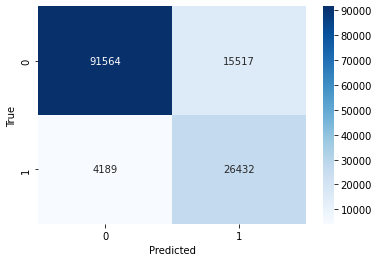

In [193]:
rn2_cm = confusion_matrix_by_client(y_test, pred_base_red_v2)
sns.heatmap(rn2_cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

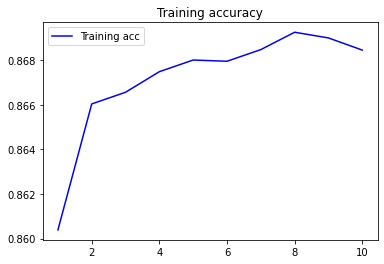

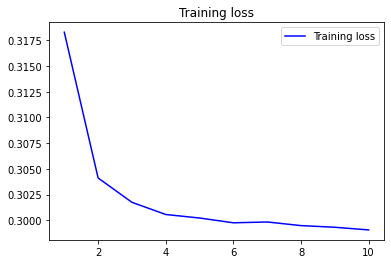

In [194]:
plot_hist(history_base_v2)

Probamos otro modelo agregando una hidden layer después de la input layer, y sumando una capa de dropout entre ambas hidden layers para evitar el overfitting

In [195]:
def red_neuronal_2_hidden_1_drop():
    features = completo_medias.drop(['customer_ID', 'target'], axis='columns', inplace=False).columns.to_list()
    regularization = 4e-4
    activation_func = 'relu'
    inputs = Input(shape = (len(features)))
    
    x = Dense(32,
           kernel_regularizer = tf.keras.regularizers.l2(regularization),
           activation = activation_func)(inputs)
    
    x = Dropout(0.1)(x)


    x = Dense(16,
           kernel_regularizer = tf.keras.regularizers.l2(regularization),
           activation = activation_func)(x)

    x = Dense(1,
              activation='sigmoid')(x)

    model = Model(inputs, x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy'],
    )

    
    return model

In [196]:
red_2h1d = red_neuronal_2_hidden_1_drop()
red_2h1d.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 99)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                3200      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 3,745
Trainable params: 3,745
Non-trainable params: 0
_________________________________________________________________


In [197]:
%%time
# Entrenamiento del modelo
history_2h1d = red_2h1d.fit(x_train,y_train,epochs=10,batch_size=8,verbose=True)

Epoch 1/10
11234/11234 [==============================] - 19s 2ms/step - loss: 0.3318 - accuracy: 0.8587
Epoch 2/10
11234/11234 [==============================] - 18s 2ms/step - loss: 0.3120 - accuracy: 0.8647
Epoch 3/10
11234/11234 [==============================] - 18s 2ms/step - loss: 0.3091 - accuracy: 0.8644
Epoch 4/10
11234/11234 [==============================] - 18s 2ms/step - loss: 0.3084 - accuracy: 0.8645
Epoch 5/10
11234/11234 [==============================] - 18s 2ms/step - loss: 0.3075 - accuracy: 0.8657
Epoch 6/10
11234/11234 [==============================] - 19s 2ms/step - loss: 0.3072 - accuracy: 0.8660
Epoch 7/10
11234/11234 [==============================] - 19s 2ms/step - loss: 0.3070 - accuracy: 0.8660
Epoch 8/10
11234/11234 [==============================] - 18s 2ms/step - loss: 0.3068 - accuracy: 0.8661
Epoch 9/10
11234/11234 [==============================] - 18s 2ms/step - loss: 0.3062 - accuracy: 0.8668
Epoch 10/10
11234/11234 [==============================

In [198]:
pred_red_2h1d = red_2h1d.predict(x_test)
print_score("NN 2 hidden layers con 1 Dropout", y_test, pred_red_2h1d)

La precision es 0.8565525555184383
El recall es 0.8668887364880311
F1 es 0.8156557245537841


Text(33.0, 0.5, 'True')

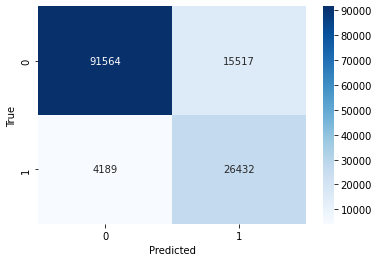

In [199]:
rn3_cm = confusion_matrix_by_client(y_test, pred_base_red_v2)
sns.heatmap(rn3_cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

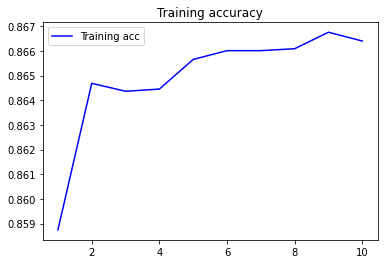

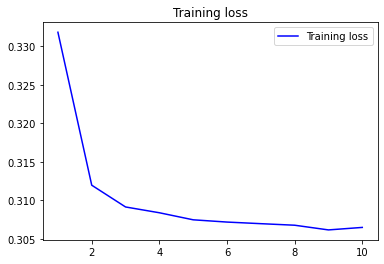

In [200]:
plot_hist(history_2h1d)

Probamos con un modelo similar, pero con menos nodos en las hidden layers

In [201]:
def red_neuronal_2_hidden_1_drop_v2():
    features = completo_medias.drop(['customer_ID', 'target'], axis='columns', inplace=False).columns.to_list()
    regularization = 4e-4
    activation_func = 'relu'
    inputs = Input(shape = (len(features)))
    
    x = Dense(16,
           kernel_regularizer = tf.keras.regularizers.l2(regularization),
           activation = activation_func)(inputs)
    
    x = Dropout(0.1)(x)


    x = Dense(8,
           kernel_regularizer = tf.keras.regularizers.l2(regularization),
           activation = activation_func)(x)

    x = Dense(1,
              activation='sigmoid')(x)

    model = Model(inputs, x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy'],
    )

    
    return model

In [202]:
red_2h1d_v2= red_neuronal_2_hidden_1_drop_v2()
red_2h1d_v2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 99)]              0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 1,745
Trainable params: 1,745
Non-trainable params: 0
_________________________________________________________________


También, a diferencia del resto de los modelos, esta vez entrenamos con más iteraciones (epochs 20 en lugar de 10) y un batch_size mayor (32 en lugar de 8). La idea es entrenar durante más iteraciones y aprovechar la memoria de la máquina para agarrar una muestra más grande para recorrer toda la red.

In [203]:
%%time
# Entrenamiento del modelo
history_2h1d_v2 = red_2h1d_v2.fit(x_train,y_train,epochs=20,batch_size=32,verbose=True)

Epoch 1/20
2809/2809 [==============================] - 5s 2ms/step - loss: 0.3441 - accuracy: 0.8485
Epoch 2/20
2809/2809 [==============================] - 4s 2ms/step - loss: 0.3117 - accuracy: 0.8645
Epoch 3/20
2809/2809 [==============================] - 5s 2ms/step - loss: 0.3064 - accuracy: 0.8654
Epoch 4/20
2809/2809 [==============================] - 4s 2ms/step - loss: 0.3034 - accuracy: 0.8663
Epoch 5/20
2809/2809 [==============================] - 5s 2ms/step - loss: 0.3022 - accuracy: 0.8671
Epoch 6/20
2809/2809 [==============================] - 4s 2ms/step - loss: 0.3009 - accuracy: 0.8678
Epoch 7/20
2809/2809 [==============================] - 5s 2ms/step - loss: 0.3009 - accuracy: 0.8675
Epoch 8/20
2809/2809 [==============================] - 4s 2ms/step - loss: 0.2997 - accuracy: 0.8691
Epoch 9/20
2809/2809 [==============================] - 4s 2ms/step - loss: 0.2993 - accuracy: 0.8686
Epoch 10/20
2809/2809 [==============================] - 4s 2ms/step - loss: 0.299

In [204]:
pred_red_2h1d_v2 = red_2h1d_v2.predict(x_test)

print_score("NN 2 hidden layers con 1 Dropout y menos nodos por capa y más iteraciones", y_test, pred_red_2h1d_v2)

La precision es 0.8629141188944242
El recall es 0.8438979785114791
F1 es 0.8201562130392559


Text(33.0, 0.5, 'True')

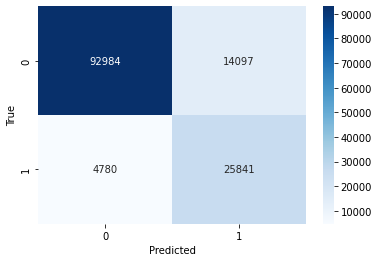

In [205]:
rn4_cm = confusion_matrix_by_client(y_test,pred_red_2h1d_v2)
sns.heatmap(rn4_cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

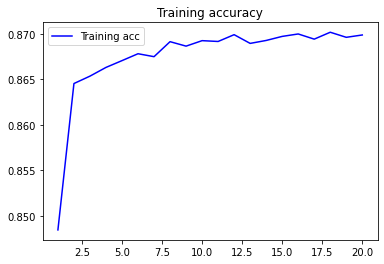

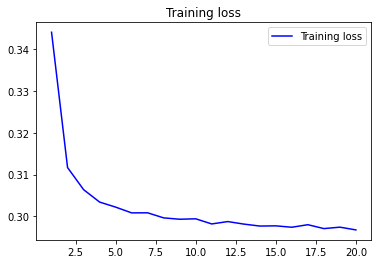

In [206]:
plot_hist(history_2h1d_v2)

Nuevamente volvemos a generar un modelo con una configuración similar, pero luego vamos a cambiar parámetros al entrenar el modelo.

In [207]:
def red_neuronal(x_train, y_train):
    features = completo_medias.drop(['customer_ID', 'target'], axis='columns', inplace=False).columns.to_list()
    regularization = 4e-4
    activation_func = 'relu'
    inputs = Input(shape = (len(features)))
    
    x = Dense(32,
           kernel_regularizer = tf.keras.regularizers.l2(regularization),
           activation = activation_func)(inputs)
    
    x = Dropout(0.1)(x)

    x = Dense(16,
              kernel_regularizer=tf.keras.regularizers.l2(regularization),
              activation=activation_func)(x)

    x = Dense(1,
              activation='sigmoid')(x)

    model = Model(inputs, x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy'],
    )

    
    return model

In [208]:
model_nr = red_neuronal(x_train, y_train)
model_nr.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 99)]              0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                3200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total params: 3,745
Trainable params: 3,745
Non-trainable params: 0
_________________________________________________________________


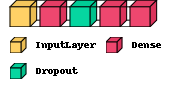

In [209]:
visualkeras.layered_view(model_nr,legend=True) 

Vamos a agregar una función de callback de Early Stopping: si después de 5 iteraciones, la métrica de pérdida se mantiene sin bajar, cortar el entrenamiento. Aprovechando esto, vamos a entrenar una mayor cantidad de epochs, y aumentar el batch_size respecto al modelo anterior.

In [210]:
%%time
# Entrenamiento del modelo
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model_nr.fit(x_train,y_train,epochs=100, batch_size=128, callbacks=[es], verbose=True)

Epoch 1/100
703/703 [==============================] - 2s 2ms/step - loss: 0.3596 - accuracy: 0.8485
Epoch 2/100
703/703 [==============================] - 2s 2ms/step - loss: 0.3201 - accuracy: 0.8631
Epoch 3/100
703/703 [==============================] - 2s 2ms/step - loss: 0.3118 - accuracy: 0.8670
Epoch 4/100
703/703 [==============================] - 2s 2ms/step - loss: 0.3064 - accuracy: 0.8675
Epoch 5/100
703/703 [==============================] - 2s 2ms/step - loss: 0.3033 - accuracy: 0.8685
Epoch 6/100
703/703 [==============================] - 2s 2ms/step - loss: 0.3005 - accuracy: 0.8698
Epoch 7/100
703/703 [==============================] - 2s 2ms/step - loss: 0.2988 - accuracy: 0.8697
Epoch 8/100
703/703 [==============================] - 2s 2ms/step - loss: 0.2968 - accuracy: 0.8709
Epoch 9/100
703/703 [==============================] - 2s 2ms/step - loss: 0.2953 - accuracy: 0.8709
Epoch 10/100
703/703 [==============================] - 2s 2ms/step - loss: 0.2947 - accura

In [211]:
pred_red_r = model_nr.predict(x_test)

print_score("NN 2 hidden layers con 1 Dropout y muchas iteraciones pero con Early Stopping", y_test, pred_red_r)

La precision es 0.8610187215871955
El recall es 0.8399790993109304
F1 es 0.8177051913624063


Text(33.0, 0.5, 'True')

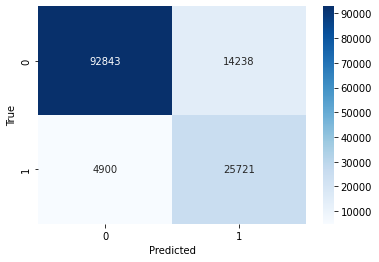

In [212]:
rn5_cm = confusion_matrix_by_client(y_test,pred_red_r)
sns.heatmap(rn5_cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

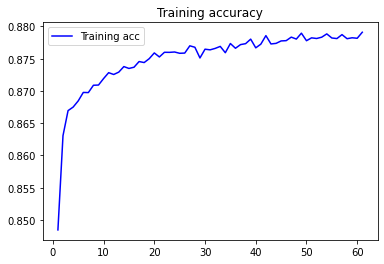

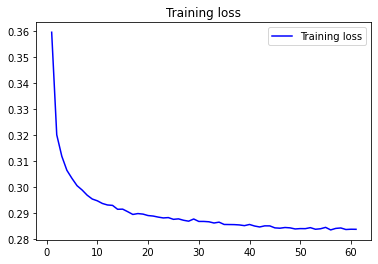

In [213]:
plot_hist(history)

Se ve como a partir de las 20 epochs no hay mucha ganancia en accuracy y el modelo no aprende nada nuevo, por lo que podemos reducir la cantidad de epochs

### Ensamble en cascada

Creamos un nuevo clasificador en base a los modelos ya generados y a la red neuronal. Funciona de la siguiente manera:

Sea X un cliente

X -> RED(X) = P("X NO ES DEUDOR") < ESPECTRO -> RF(X) = P("X NO ES DEUDOR") < ESPECTRO -> XGB(X) = P("X NO ES DEUDOR") < ESPECTRO -> SVM(X) = P("X NO ES DEUDOR") < ESPECTRO -> X ES DEUDOR (PREDICT TARGET = 1)

Si algun modelo predice una probabilidad mayor que el espectro de que ese cliente no sea deudor, se lo considera no deudor (target = 0)

In [214]:
#usar con un solo cliente
def predict_by_client(model, x_test):
    predicts = model.predict_proba(x_test)
    predicts = [x[0] for x in predicts] #me quedo con la prob de target == 0 para cada registro
    temp_x_test = x_test_copy.copy()
    temp_x_test['target_proba'] = predicts
    temp_x_test = temp_x_test[['customer_ID', 'target_proba']].groupby('customer_ID').agg({'target_proba':np.mean}).reset_index()
    return temp_x_test.values.tolist()

class svm_decorator(object):
    def __init__(self, model):
        fittable = CalibratedClassifierCV(model)
        fittable.fit(x_train, y_train)
        self._model = fittable
    
    def predict_proba(self, x_test):
        return self._model.predict_proba(x_test)
    
class red_decorator(object):
    def __init__(self, model):
        self._model = model
        
    def predict_proba(self, x_test):
        probas = self._model.predict(x_test)
        return [1 - x for x in probas]

def cascade_predict(x_test, spectre):
    svm_proba = svm_decorator(svm_model)
    red_model = red_decorator(red_2h1d_v2)
    models = [red_model, arbol, xgb_model, svm_proba]
    predicts_by_customer = []
    predicts_clients = [predict_by_client(x, x_test) for x in models]
    
    for n in range(len(predicts_clients[0])):
        n_client = [item[n] for item in predicts_clients]
        target0 = False
        customer_ID = ''
        for client in n_client:
            customer_ID = client[0]
            proba = client[1]
            if (proba > spectre):
                target0 = True
                predicts_by_customer.append([customer_ID, 0])
                break
        if not target0:
            predicts_by_customer.append([customer_ID, 1])
    
    return predicts_by_customer

def cascade_metrics(name, y_test, cascade_results):
    test_real = x_test_copy
    test_real['target'] = y_test
    test_real = test_real[['customer_ID', 'target']].groupby('customer_ID').agg({'target':custom_predict})
    
    acc = accuracy_score(test_real['target'].values, cascade_results)
    recall = recall_score(test_real['target'].values, cascade_results)
    f1 = f1_score(test_real['target'].values, cascade_results, average='macro')
    
    save_metric(name, acc, recall, f1)
        
    return acc, recall, f1

def cascade_cm(y_test, cascade_results):
    test_real = x_test_copy
    test_real['target'] = y_test
    test_real = test_real[['customer_ID', 'target']].groupby('customer_ID').agg({'target':custom_predict})
    
    return confusion_matrix(test_real['target'].values, cascade_results)

def predict_cascade(x_test, spectre):
    cascade_results = cascade_predict(x_test, spectre)
    predicts = [x[1] for x in cascade_results]
    cascade_acc, cascade_recall, cascade_f1 = cascade_metrics(f"Cascade spectre={spectre:.2f}", y_test, predicts)

    print(f"Metricas con spectre={spectre:.2f}:")
    print("La precision es {}".format(cascade_acc))

    print("El recall es {}".format(cascade_recall))

    print("F1 es {}".format(cascade_f1))
    
    cascada_cm = cascade_cm(y_test, predicts)
    sns.heatmap(cascada_cm, cmap='Blues', annot=True, fmt='g')
    plt.title(f"Confusion Matrix spectre={spectre:.2f}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return predicts

Vamos a probar con varios valores de spectre y analizar los resultados:

Probamos desde valores altos hasta valores más bajos y viendo cómo se comporta el ensamble en cascada. Vamos desde 0.99 hasta 0.51

Metricas con spectre=0.99:
La precision es 0.5028757752247607
El recall es 0.9964076940661637
F1 es 0.5010958225414187


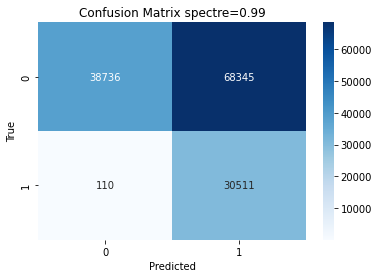

Metricas con spectre=0.90:
La precision es 0.7564160288158487
El recall es 0.9715554684693511
F1 es 0.7277826393690427


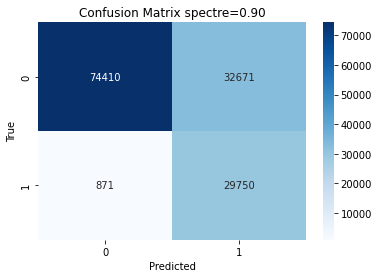

Metricas con spectre=0.85:
La precision es 0.7954350699336248
El recall es 0.9540184840468959
F1 es 0.762755491158321


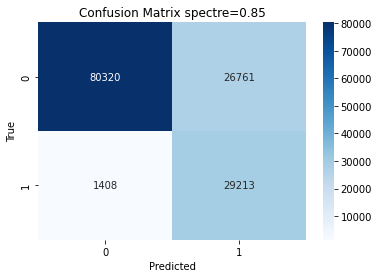

Metricas con spectre=0.80:
La precision es 0.8220069425280678
El recall es 0.9304725515169329
F1 es 0.7864214085689626


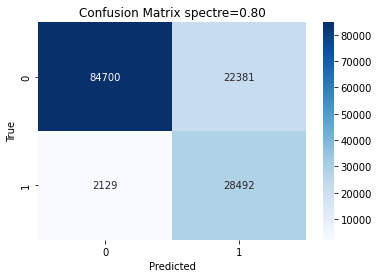

Metricas con spectre=0.70:
La precision es 0.8543739379239227
El recall es 0.8699585251951275
F1 es 0.8136524422391396


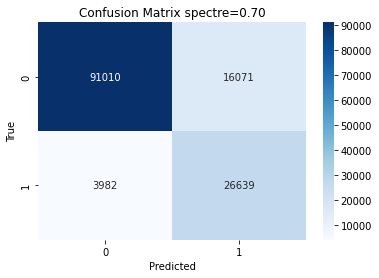

Metricas con spectre=0.51:
La precision es 0.873153621588648
El recall es 0.7179713268671827
F1 es 0.8170292071227538


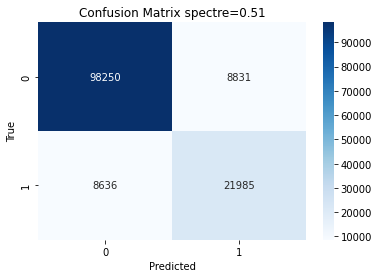

CPU times: user 33min 26s, sys: 26.5 s, total: 33min 53s
Wall time: 32min 38s


In [215]:
%%time
spectre_values = [0.99, 0.9, 0.85, 0.8, 0.7, 0.51]
spectre_predicts = {}
for s in spectre_values:
    spectre_predicts[s] = predict_cascade(x_test, s)

A medida que vamos disminuyendo el valor del espectro, vemos como nuestro modelo predice mejor, disminuyendo la cantidad de Falsos Positivos. Esto tiene sentido, porque quiere cuanto más seguros tenemos que estar para dar una predicción de 0, menor cantidad de 0s voy a predecir, pero los pocos que prediga, la certeza será mayor. Como se aprecia, nuestros modelos no nos garantizan probabilidades muy altas para valores de espectro altas, y a medida que vamos cediendo confianza para la detección de no deudores, mayor es la cantidad de Falsos Negativos que van apareciendo.

Para un valor de spectre=0.51, esto significa que vamos a fijarnos en el modelo 1 si la predicción está más cerca del 0 que del 1. Si está cerca del 0 entonces confirmamos que es 0, caso opuesto se lo pasamos al siguiente modelo y así sucesivamente. Si al menos uno de esos modelos predice que está cerca del 0, entonces confirmaríamos que no es deudor. Al ser 51% una probabilidad muy cercana a la otra clase, perdemos la confianza en nuestra predicción y por eso es que se aprecia mayor cantidad de Falsos Negativos.

Un valor razonable podría ser spectre=0.8, es decir que tenemos que estar 80% seguros de que nuestra predicción sea 0 (no deudor) antes de confirmarla como tal. Si no estamos seguros, se lo pasamos al siguiente modelo y así hasta tener la certeza que sea no deudor. Caso opuesto, asumimos que es deudor no pago.

## Conclusión

In [216]:
metrics_models = get_all_metrics()
metrics_keys = get_metrics_key_order()

In [217]:
metrics_data = []

for k in metrics_keys:
    model_metrics = metrics_models[k]
    metrics_data.append([k, model_metrics['accuracy'], model_metrics['recall'], model_metrics['f1']])

metrics_df = pd.DataFrame(metrics_data, columns=['Name', 'Accuracy', 'Recall', 'F1'])
metrics_df

Name  Accuracy    Recall  \
0            Random Forest cust_id feature importance  0.867736  0.784494   
1                                       Random Forest  0.851542  0.860390   
2                                     XGBoost default  0.855391  0.842200   
3                                             XGBoost  0.857308  0.859541   
4                                   LinearSVC default  0.863190  0.829398   
5                                   LinearSVC tuneado  0.818812  0.917377   
6                                    VotingClassifier  0.850670  0.878221   
7                                     NN Baseline SGD  0.857671  0.861239   
8                                    NN Baseline Adam  0.856894  0.863198   
9                    NN 2 hidden layers con 1 Dropout  0.856553  0.866889   
10  NN 2 hidden layers con 1 Dropout y menos nodos...  0.862914  0.843898   
11  NN 2 hidden layers con 1 Dropout y muchas iter...  0.861019  0.839979   
12                               Cascade spectre=0.99  0.502876  0.996408   
13                               Cascade spectre=0.90  0.756416  0.971555   
14                               Cascade spectre=0.85  0.795435  0.954018   
15                               Cascade spectre=0.80  0.822007  0.930473   
16                               Cascade spectre=0.70  0.854374  0.869959   
17                               Cascade spectre=0.51  0.873154  0.717971   

          F1  
0   0.819017  
1   0.809704  
2   0.811904  
3   0.815725  
4   0.818950  
5   0.782024  
6   0.810572  
7   0.816282  
8   0.815651  
9   0.815656  
10  0.820156  
11  0.817705  
12  0.501096  
13  0.727783  
14  0.762755  
15  0.786421  
16  0.813652  
17  0.817029

Graficamos a continuación una comparativa entre las distintas redes neuronales

Buscamos cuál de todas es la mejor red neuronal, para luego analizarla junto al resto de los modelos.

In [218]:
nn_metrics_df = metrics_df[metrics_df['Name'].str.startswith('NN')]

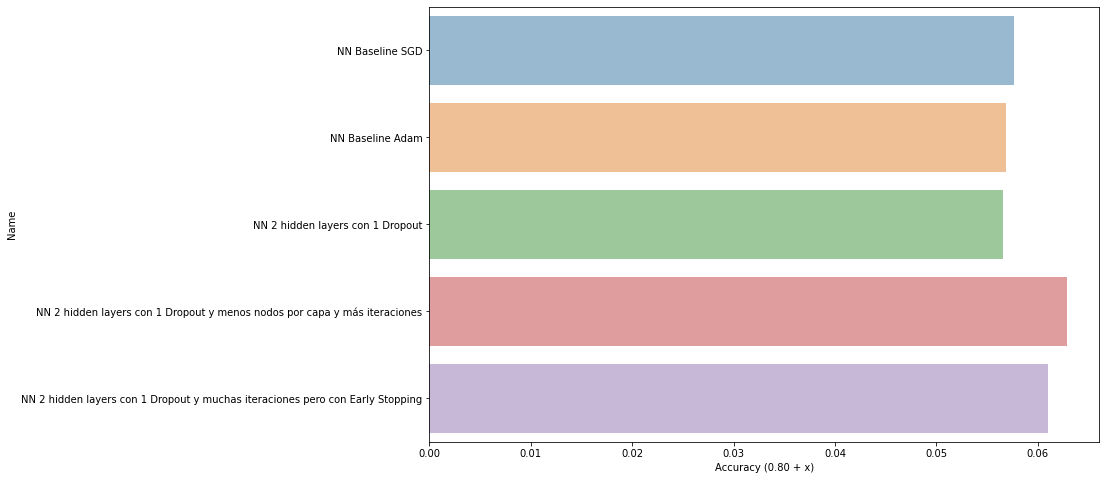

In [219]:
plt.figure(figsize=(12,8))
ax = sns.barplot(y="Name", x=nn_metrics_df["Accuracy"] - 0.80, data=nn_metrics_df, alpha=0.5, orient='h')
ax.set_xlabel("Accuracy (0.80 + x)")
plt.show()

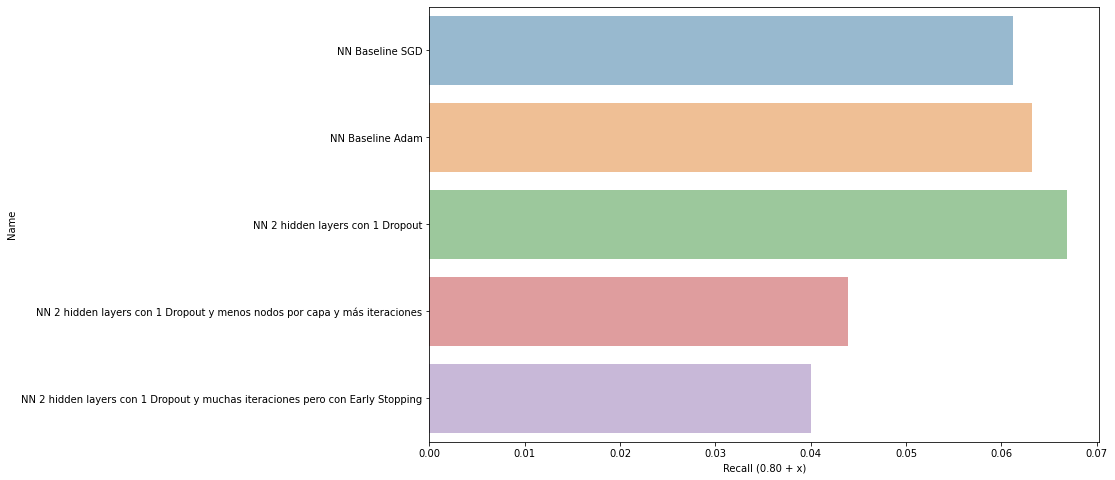

In [220]:
plt.figure(figsize=(12,8))
ax = sns.barplot(y="Name", x=nn_metrics_df["Recall"] - 0.80, data=nn_metrics_df, alpha=0.5, orient='h')
ax.set_xlabel("Recall (0.80 + x)")
plt.show()

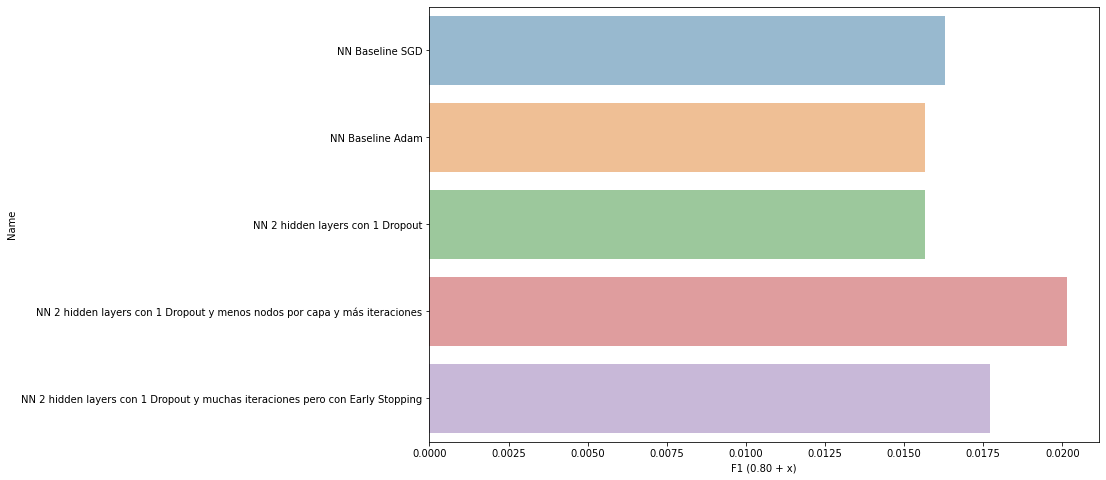

In [221]:
plt.figure(figsize=(12,8))
ax = sns.barplot(y="Name", x=nn_metrics_df["F1"] - 0.80, data=nn_metrics_df, alpha=0.5, orient='h')
ax.set_xlabel("F1 (0.80 + x)")
plt.show()

De los modelos de las redes se observan comportamientos muy similares. Las redes que presentan mejores métricas son las últimas 2, ya que si bien son las que peor recall tienen, presentan mejor accuracy y mejor F1. La que mejor recall presenta, si bien es la que más disminuye los Falsos Negativos, el aumento de los Falsos Positivos no permiten que sea la mejor de todas las redes. Por ello, nos vamos a quedar con la anteúltima red como la mejor red.

In [222]:
metrics_df['Name'] = metrics_df['Name'].str.replace("NN 2 hidden layers con 1 Dropout y menos nodos por capa y más iteraciones", 'Red Neuronal')

Ahora, con la misma motivación, analizaremos los ensambles en cascada

In [223]:
cascade_metrics_df = metrics_df[metrics_df['Name'].str.startswith('Cascade')]

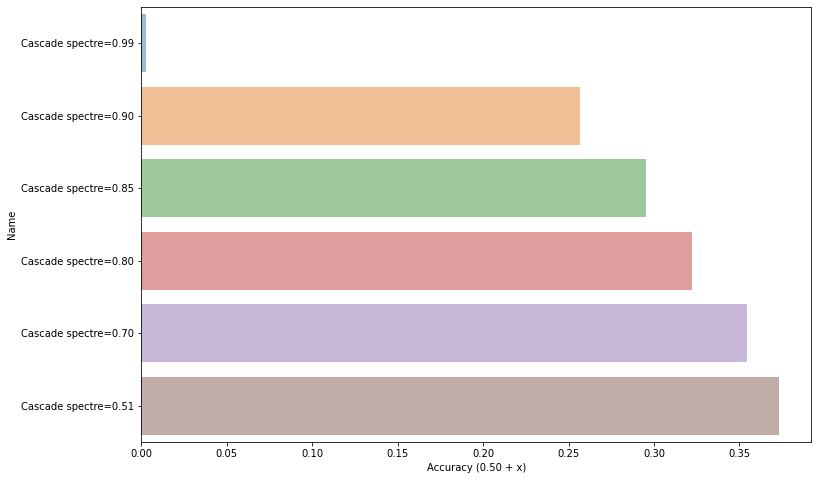

In [224]:
plt.figure(figsize=(12,8))
ax = sns.barplot(y="Name", x=cascade_metrics_df["Accuracy"] - 0.50, data=cascade_metrics_df, alpha=0.5, orient='h')
ax.set_xlabel("Accuracy (0.50 + x)")
plt.show()

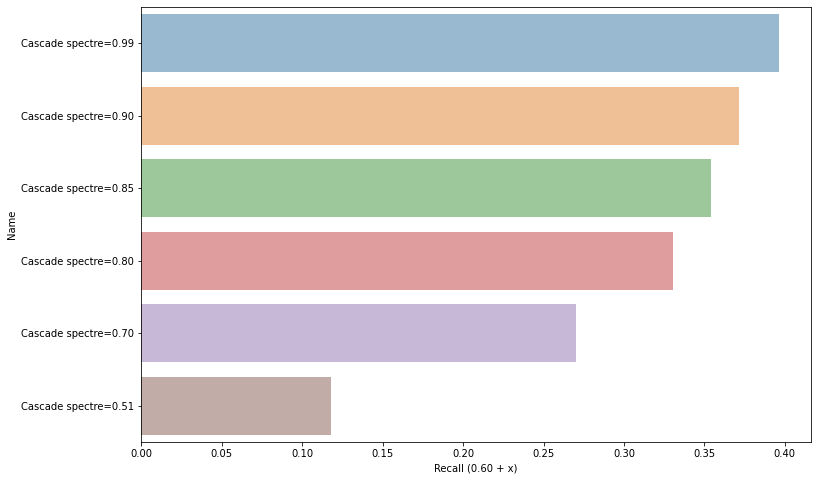

In [225]:
plt.figure(figsize=(12,8))
ax = sns.barplot(y="Name", x=cascade_metrics_df["Recall"] - 0.60, data=cascade_metrics_df, alpha=0.5, orient='h')
ax.set_xlabel("Recall (0.60 + x)")
plt.show()

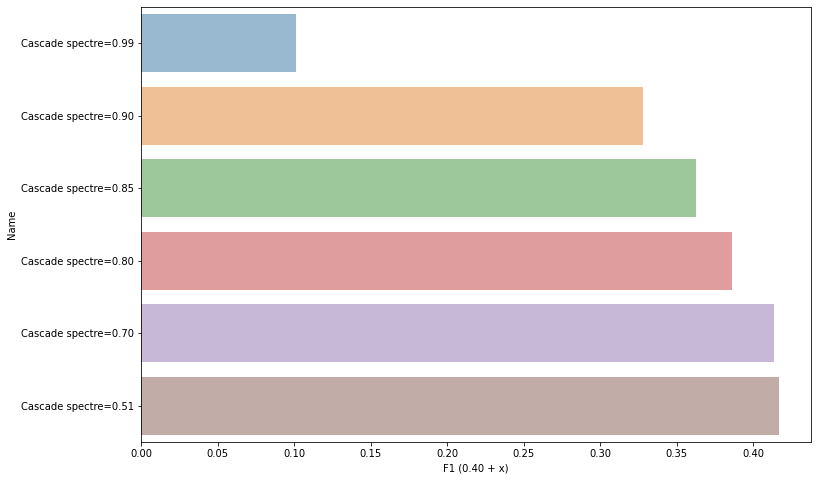

In [226]:
plt.figure(figsize=(12,8))
ax = sns.barplot(y="Name", x=cascade_metrics_df["F1"] - 0.40, data=cascade_metrics_df, alpha=0.5, orient='h')
ax.set_xlabel("F1 (0.40 + x)")
plt.show()

Para los distintos modelos, en este caso los cambios son mucho más notorios. Como ya vimos en la sección del ensamble en cascada, la única forma que tenemos de confirmar que se trata de un target 0 (cliente no deudor), es que estemos seguros en un porcentaje definido por el espectro (spectre). Para el caso de spectre=0.99, esto implica que tenemos que estar 99% seguros de que pertenezca a esta clase para poder confirmarlo. Es decir, dicho de otra forma, la probabilidad de que nuestro modelo de cascada prediga un 0 depende de que uno de los modelos esté prediciendo la clase 0 con una probabilidad del 99%. Esto hace que el recall, sea muy elevado, casi del 100%, porque hay muy pocos Falsos Negativos. El problema de este modelo es que los Falsos Positivos y por ende que la métrica de accuracy dé muy baja, del 50%, lo cual lo hace un modelo aleatorio y no nos sirve. A medida que vamos bajando nuestra medida de certeza (spectre), vamos viendo el comportamiento inverso... predecimos 0 con más facilidad, pero a costa de aumentar mucho los Falsos Negativos.

Viendo las métricas y teniendo en cuenta un modelo balanceado, los mejores son los de spectre=0.8 y spectre=0.7, siendo este último un poco mejor que el otro. Pero si bien la diferencia es mínima, preferimos quedarnos con el de 0.8 ya que tenemos mayor certeza al predecir.

In [227]:
metrics_df['Name'] = metrics_df['Name'].str.replace("Cascade spectre=0.80", 'Ensamble en cascada -- >80%')

Ahora analizamos el resto de los modelos junto a la mejor red y mejor ensamble:

In [228]:
best_metrics_df = metrics_df[((~metrics_df['Name'].str.startswith('NN')) & ((~metrics_df['Name'].str.startswith('Cascade'))))]

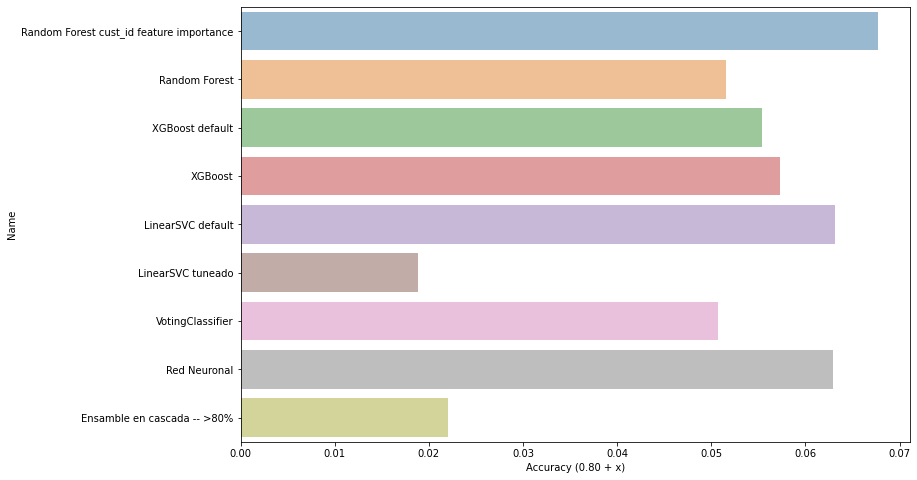

In [229]:
plt.figure(figsize=(12,8))
ax = sns.barplot(y="Name", x=best_metrics_df["Accuracy"] - 0.8, data=best_metrics_df, alpha=0.5, orient='h')
ax.set_xlabel("Accuracy (0.80 + x)")
plt.show()

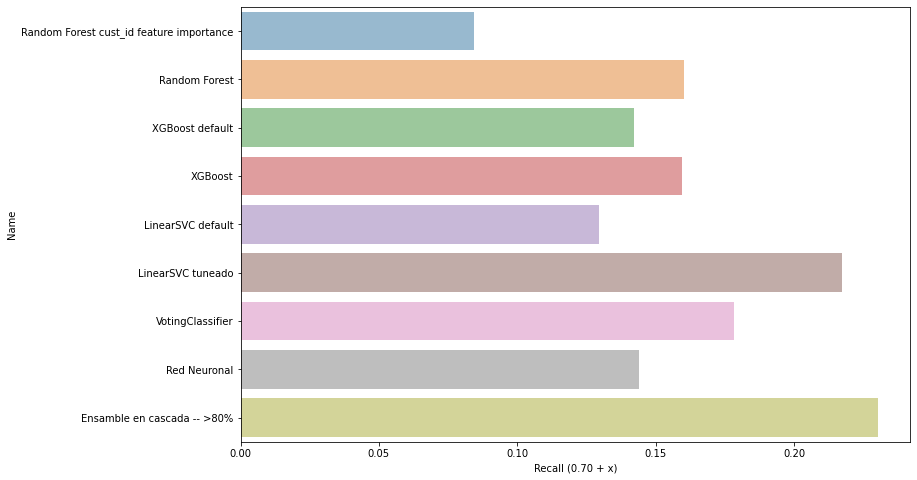

In [230]:
plt.figure(figsize=(12,8))
ax = sns.barplot(y="Name", x=best_metrics_df["Recall"] - 0.7, data=best_metrics_df, alpha=0.5, orient='h')
ax.set_xlabel("Recall (0.70 + x)")
plt.show()

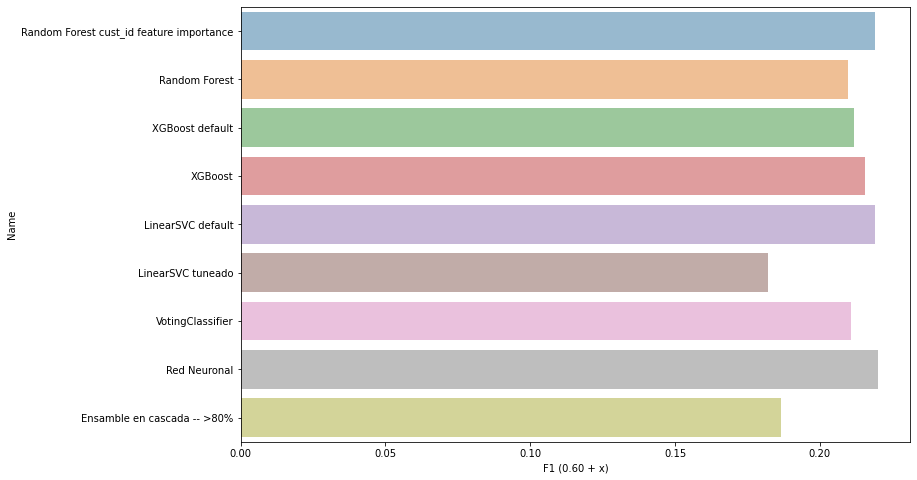

In [231]:
plt.figure(figsize=(12,8))
ax = sns.barplot(y="Name", x=best_metrics_df["F1"] - 0.6, data=best_metrics_df, alpha=0.5, orient='h')
ax.set_xlabel("F1 (0.60 + x)")
plt.show()

Respecto a SVM, notamos que al tunear el modelo con los mejores hiperparámetros, aumenta bastante el recall. Esto se puede apreciar viendo que los Falsos Negativos en la matriz de confusión son muy bajos respecto al resto de los modelos. Pero esto es a costa de sacrificar accuracy y la métrica de F1. Si necesitáramos un buen modelo donde lo que importe es no perdernos estos casos de deudores no pagos (Falsos Negativos), sin duda sería un modelo a tener en cuenta. Lo mismo se aprecia para los ensambles en cascada con un espectro alto, como analizamos anteriormente.

Siguiendo el análisis, con Random Forest pudimos hacer un análisis inicial bastante acertado y que nos permitió ver con certeza cuáles eran los features más importantes de manera rápida. Al tunear los hiperparámetros, si bien la F1 se mantuvo parecida y el accuracy bajó un 1%, donde más se aprecia la mejora es en el recall. Al tener árboles un poco más complejos pero sin llegar a overfittear, logramos reducir las predicciones de falsos no deudores sin perder tanto respecto a las demás métricas. Con XGBoost, que también usa árboles ya que usamos el booster gbtree, observamos lo mismo, con la diferencia que todas las métricas se ven mejoradas levemente al tunearlo, viendo la mayor mejora respecto al recall.

El ensamble de todos estos modelos con Voting, por todo lo mencionado anteriormente, junta lo mejor de todos estos modelos, generando un modelo balanceado con las mejores cualidades de los modelos ya analizados. Gracias a SVM, el recall es el más alto, solo por detrás de justamente SVM, y a diferencia de este, las métricas de accuracy y F1 son altas, es decir que lo que no predice bien SVM, lo predice bien gracias a Random Forest y XGBoost. Este consideramos que es un buen modelo y es candidato a ser uno de los mejores.

La mejor de las redes neuronales también es un buen modelo, ya que si bien la métrica de recall no es tan buena como la del VotingClassifier, en el resto de las métricas compite par a par, logrando mejor accuracy y F1. Es por esto que también lo consideramos un buen modelo y candidato a ser uno de los mejores.

#### El mejor modelo

Vamos a hacer un voting manual con las predicciones ya hechas de los mejores modelos, aprovechando que los modelos ya estan entrenados.

In [232]:
test_by_customer_real = x_test_copy.copy()
test_by_customer_real['target'] = y_test
test_by_customer_real = test_by_customer_real[['customer_ID', 'target']].groupby('customer_ID').agg({'target':custom_predict})

y_test_grouped = test_by_customer_real['target'].values

In [233]:
def predict_by_client(predict):
    test_by_customer_predict = x_test_copy.copy()
    test_by_customer_predict['target'] = predict
    test_by_customer_predict = test_by_customer_predict[['customer_ID', 'target']].groupby('customer_ID').agg({'target':custom_predict})
    
    return np.array(test_by_customer_predict['target'])

In [234]:
%%time
predicted_ensamble = predict_by_client(predicted_categoriesE)
predicted_red = predict_by_client(pred_red_2h1d_v2)
predicted_cascada = spectre_predicts[0.8]

predicted = np.around((predicted_ensamble + predicted_red + predicted_cascada) / 3)
predicted = [int(x) for x in predicted]

best_acc, best_recall, best_f1 = get_metrics(y_test_grouped, predicted)


print("La precision es {}".format(best_acc))

print("El recall es {}".format(best_recall))

print("F1 es {}".format(best_f1))

La precision es 0.848353691304411
El recall es 0.8904673263446654
F1 es 0.809346444790082
CPU times: user 2.78 s, sys: 43.9 ms, total: 2.82 s
Wall time: 2.82 s


In [235]:
best_metrics_df = best_metrics_df.append({
    'Name': "Best Model",
    'Accuracy': best_acc,
    'Recall': best_recall,
    'F1': best_f1
}, ignore_index=True)

Con este nuevo modelo calculado, volvemos a ver las métricas comparadas:

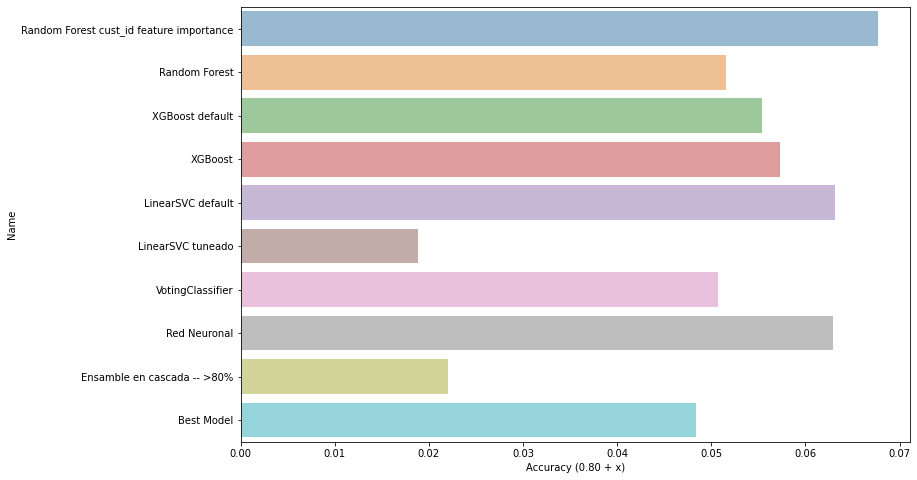

In [236]:
plt.figure(figsize=(12,8))
ax = sns.barplot(y="Name", x=best_metrics_df["Accuracy"] - 0.8, data=best_metrics_df, alpha=0.5, orient='h')
ax.set_xlabel("Accuracy (0.80 + x)")
plt.show()

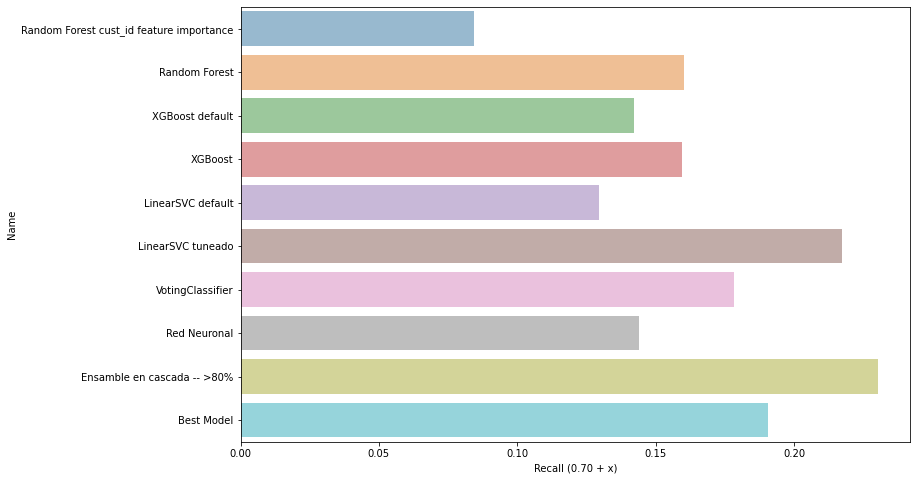

In [237]:
plt.figure(figsize=(12,8))
ax = sns.barplot(y="Name", x=best_metrics_df["Recall"] - 0.7, data=best_metrics_df, alpha=0.5, orient='h')
ax.set_xlabel("Recall (0.70 + x)")
plt.show()

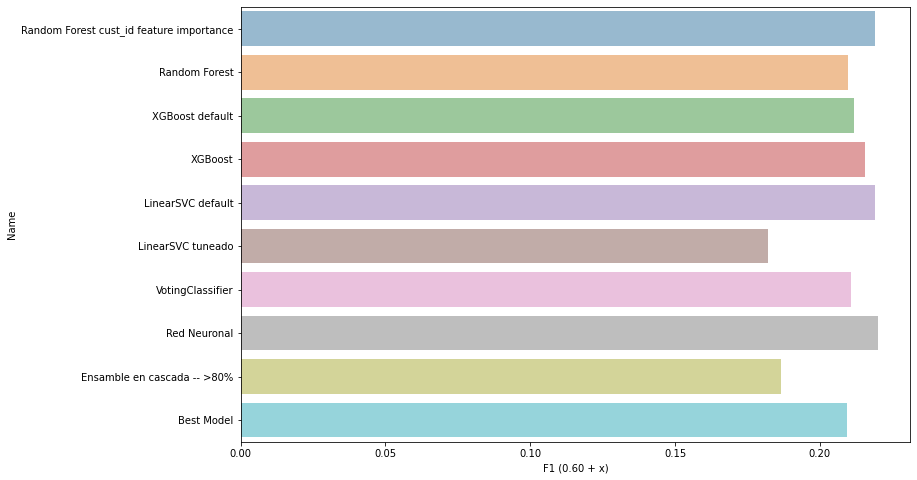

In [238]:
plt.figure(figsize=(12,8))
ax = sns.barplot(y="Name", x=best_metrics_df["F1"] - 0.6, data=best_metrics_df, alpha=0.5, orient='h')
ax.set_xlabel("F1 (0.60 + x)")
plt.show()

A modo de conclusión, si bien varios de los modelos resultaron en métricas parecidas, el que creemos que es el mejor modelo es este último voting entre el VotingClassifier, la mejor red neuronal y el ensamble en cascada con espectro 80%.

**Sintesis sobre los modelos entrenados y los resultados obtenidos**

En este informe pudimos observar resumenes de clientes que puso American Express a disposicion y entrenar modelos que puedan detectar aquellos que pueden llegar a no pagar a fin de mes. 

Los resultados obtenidos para cada modelo muestran que existen features que estan relacionadas con deudores morosos y que pueden hallarse valores que indiquen una probable morosidad a futuro. 

Las matrices de confusion de cada modelo nos indican que existen casos borde en donde un cliente puede reunir todas las caracteristicas de un deudor y resultar no serlo, para explicar este comportamiento debiera analizarse los falsos positivos de cada prediccion y encontrar similitudes y diferencias con respecto a los clasificados correctamente. 

Para poder hacer un analisis exhaustivo de los clientes que no pueden ser clasificados como morosos, habria que considerar todos los resumenes disponibles en el dataset original de esos clientes y buscar diferencias con los que se utilizaron para entrenar nuestros modelos. Una primera aproximacion seria observar la distribucion de las variables que fueron mas importantes para cada modelo a la hora de decidir su clasificacion y encontrar diferencias entre los deudores mal clasificados y bien clasificados.

#### Comentarios finales sobre despliegue en producción

Si el sistema entrase en producción, se podría incluir actividad humana para la revisión de casos específicos en donde la predicción del modelo esté en el límite de ambas clases (como valores entre 0.4 a 0.6), ya que para los cuales la probabilidad de error sea mayor. También se puede incluir para la revisión de registros random con el fin de hacer pruebas de calidad e introducir mejoras, correcciones y nuevos features al sistema. Otra de las revisiones que se puede realizar es hacer un énfasis en los casos que no pudimos resolver, poder buscar los features más importantes del modelo, y fijarnos si esos features muestran una distribución distinta de las que si se pudieron clasificar. Por ejemplo, en nuestros modelos, predominaba como feature más importante la columna **P_2**, de la categoría de pagos. Esta variable, por la importancia que posee, podría tratarse de antecedentes en falta de pago, o algún campo similar que denote la probabilidad en la falta de pago. Al ver las distribuciones de P_2 durante el análisis de datos, encontramos que la distribución entre deudores y no deudores estaba bien marcada.

Un dato no menor es que el dataset del cual partimos para el análisis representa un 5% del dataset original. En el dataset de la competencia se observan los statements de los clientes por un período de 18 meses, y en nuestro split el máximo de registros que tenemos para un mismo cliente es de 6. Si en el modelo pudiéramos incluir la totalidad de los statements, no sólo tendríamos más datos sino que podríamos calcular mejores features, para analizar el comportamiento del cliente para todo el período presentado. En sintonía con la presencia de un período de meses, si quisiéramos llevar este modelo a producción, con el paso del tiempo el comportamiento de los clientes puede variar, y esto por ende implicaria que nuestro modelo también pueda cambiar. No solo deberíamos nutrir al modelo de los nuevos registros, sino que también deberíamos hacer revisiones como búsqueda de nuevos features y entrenamiento de los modelos. Un ejemplo de esto podría ser un pipeline del estilo cascada, donde lo que no puede resolver el modelo productivo, se lo paso a un siguiente modelo que contenga la información novedosa, para identificar casos nuevos o preexistentes.

